# Problem statement: To Predict the Prices of private residential properties.

In [1]:
import pandas as pd
import numpy as np
import pylab
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import re
import optuna
from optuna.samplers import TPESampler
from xgboost import XGBRegressor

from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn import metrics,linear_model
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression,Lasso

# Using previous data for merged_house_data

In [2]:
merged_house_data = pd.read_csv('./dataset_asof_051121/merged_house_data.csv')

In [3]:
merged_house_data.shape

(9240, 45)

In [4]:
merged_house_data.head()

,index,project name,street name,tenure,no. of units,price,nett price,areasq,type of area,floor level,...,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
0,0,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,86,1.0,16550000.0,-,8940.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
1,1,LANDED HOUSING DEVELOPMENT,MERRYN ROAD,999,1.0,16550000.0,-,8878.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
2,2,LANDED HOUSING DEVELOPMENT,COVE DRIVE,85,1.0,16500000.0,-,7281.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
3,3,LANDED HOUSING DEVELOPMENT,WALTON ROAD,999,1.0,16300000.0,-,8673.0,Land,-,...,0,0,0,0,1,0,0,0,1,0
4,4,SANNY PARK,MERRYN ROAD,999,1.0,16300000.0,-,9064.0,Land,-,...,0,0,0,0,1,0,0,0,1,0


In [5]:
merged_house_data.tail()

,index,project name,street name,tenure,no. of units,price,nett price,areasq,type of area,floor level,...,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
9235,9235,LOYANG VILLAS,LOYANG VIEW,71,1.0,1490000.0,-,1615.0,Land,-,...,0,0,0,0,0,0,1,0,1,0
9236,9236,MACPHERSON GARDEN ESTATE,JALAN SETIA,999,1.0,1490000.0,-,886.0,Land,-,...,0,0,0,0,0,0,1,0,1,0
9237,9237,LOYANG VILLAS,LOYANG RISE,71,1.0,1490000.0,-,1658.0,Land,-,...,0,0,0,0,0,0,1,0,1,0
9238,9238,LOYANG VILLAS,LOYANG RISE,71,1.0,1490000.0,-,2153.0,Land,-,...,0,0,0,0,0,0,1,0,1,0
9239,9239,LOYANG VILLAS,LOYANG VIEW,71,1.0,1488888.0,-,1615.0,Land,-,...,0,0,0,0,0,0,1,0,1,0


In [6]:
merged_house_data['type of area'].nunique()

1

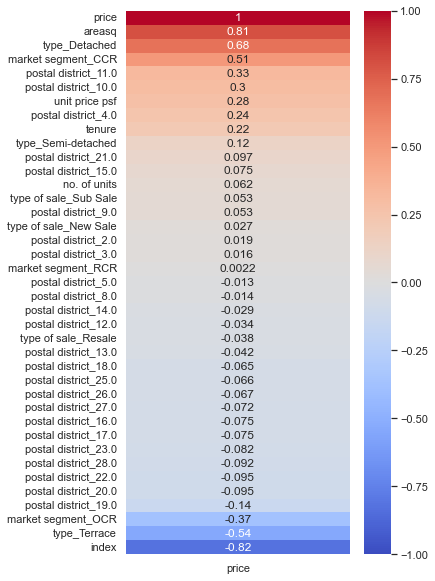

In [7]:
sns.set(font_scale=1)
plt.figure(figsize =(5,10))
sns.heatmap(merged_house_data.corr()[['price']].sort_values('price', ascending =False), annot=True, vmin = -1, vmax = 1, cmap = 'coolwarm');

In [8]:
pd.set_option('max_columns',None)

In [9]:
merged_house_data.head(1)

,index,project name,street name,tenure,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale,market segment_CCR,market segment_OCR,market segment_RCR,postal district_2.0,postal district_3.0,postal district_4.0,postal district_5.0,postal district_8.0,postal district_9.0,postal district_10.0,postal district_11.0,postal district_12.0,postal district_13.0,postal district_14.0,postal district_15.0,postal district_16.0,postal district_17.0,postal district_18.0,postal district_19.0,postal district_20.0,postal district_21.0,postal district_22.0,postal district_23.0,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
0,0,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,86,1.0,16550000.0,-,8940.0,Land,-,1851.0,Jun-2017,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [10]:
X = merged_house_data.drop(columns =['price', 'unit price psf', 'index', 'project name', 'street name', 'nett price', 'type of area','floor level','date of sale',])
y = merged_house_data['price']

In [11]:
X.head(1)

,tenure,no. of units,areasq,market segment_CCR,market segment_OCR,market segment_RCR,postal district_2.0,postal district_3.0,postal district_4.0,postal district_5.0,postal district_8.0,postal district_9.0,postal district_10.0,postal district_11.0,postal district_12.0,postal district_13.0,postal district_14.0,postal district_15.0,postal district_16.0,postal district_17.0,postal district_18.0,postal district_19.0,postal district_20.0,postal district_21.0,postal district_22.0,postal district_23.0,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
0,86,1.0,8940.0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


In [12]:
# Create train/test splits.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.25, random_state=42)

In [13]:
# instantiate the model
lr = LinearRegression()
#fit using the training data
lr.fit(X_train, y_train);

In [14]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [15]:
# instantiate the model
lr = LinearRegression()
#fit using the training data
lr.fit(Z_train, y_train);

In [16]:
lr.score(Z_train, y_train)

0.8349638543014354

In [17]:
lr.score(Z_test, y_test)

0.833369844387237

In [18]:
y_pred = lr.predict(Z_train)

In [19]:
metrics.r2_score(y_train, y_pred)

0.8349638543014354

In [20]:
metrics.mean_squared_error(y_train, y_pred)

887617750885.3368

In [21]:
np.sqrt(metrics.mean_squared_error(y_train, y_pred))

942134.6776790125

### There is no overfitting, we can try Lasso to see if there is any difference

In [22]:
# State the parameters you want to search for lasso regularisation
# we want to go through 1000 different alpha values
parameters = {
                'alpha': [x/1 for x in range(1000)]
             }

# Instantiate the model
lasso = Lasso()

# Instantiate Gridsearch (use previous instantiated parameters and model)
lasso_lr = GridSearchCV(lasso, parameters, 
                     scoring='neg_mean_squared_error', 
                     cv=5, verbose=1, n_jobs=-1)

In [23]:
lasso_lr.fit(Z_train, y_train);

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


In [24]:
print(lasso_lr.best_params_)

{'alpha': 999.0}


In [25]:
lasso_reg = linear_model.Lasso(alpha = 999, max_iter=10000000, tol=0.1)

In [26]:
lasso_reg.fit(Z_train, y_train)

Lasso(alpha=999, max_iter=10000000, tol=0.1)

In [27]:
lasso_reg.score(Z_train, y_train)

0.8306967984468927

In [28]:
lasso_reg.score(Z_test, y_test)

0.8302861466394799

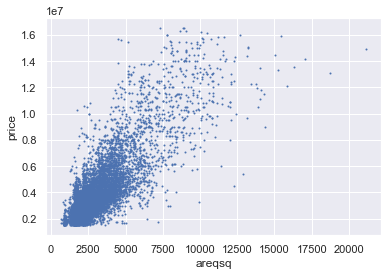

In [29]:
plt.scatter(merged_house_data["areasq"], merged_house_data["price"], s=1)
plt.xlabel('areqsq')
plt.ylabel('price');

### Prices increases as the areasq increases

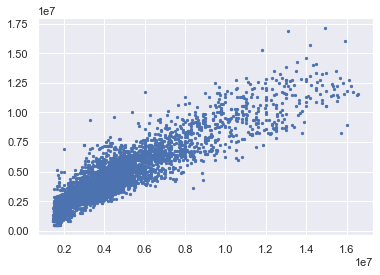

In [30]:
# Linearity
plt.scatter(y_train, y_pred, s = 5)

### Linearity corelation

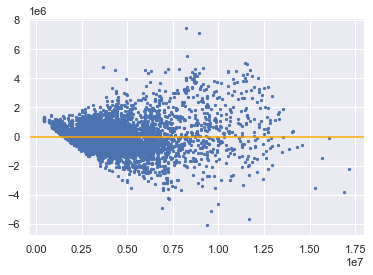

In [31]:
plt.scatter(y_pred, y_train - y_pred, s=5)
plt.axhline(0, color ='orange');

### Homoscedasticity, The results becomes more uneven towards the high price

# USing XGB for this data without hyper parameter tuning

In [32]:
XGB = XGBRegressor()
XGB.fit(Z_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [33]:
XGB.score(Z_train, y_train)

0.9454731435655597

In [34]:
XGB.score(Z_test, y_test)

0.8732925850070037

In [35]:
y_pred1 = XGB.predict(Z_train)
print(metrics.r2_score(y_train, y_pred1))
print(metrics.mean_squared_error(y_train, y_pred1))
print(np.sqrt(metrics.mean_squared_error(y_train, y_pred1)))

0.9454731435655597
293263063472.08014
541537.6842585197


In [36]:
def xgb(search):
    colsample_bytree = search.suggest_float("colsample_bytree", 0.1, 1.0)
    learning_rate = search.suggest_float("learning_rate", 0.1, 1.0) 
    max_depth = search.suggest_int("max_depth",1, 5)
    min_child_weight = search.suggest_int("min_child_weight", 1, 5)
    n_estimator = search.suggest_int("n_estimators", 100, 300)
    reg_lambda = search.suggest_loguniform("reg_lambda", 1e-8, 100)
    reg_alpha = search.suggest_loguniform("reg_alpha", 1e-8, 100)
    sub_sample = search.suggest_float("sub_sample", 0.1, 1.0)
    
    model = XGBRegressor(random_state = 42,
                         colsample_bytree = colsample_bytree,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         min_child_weight = min_child_weight,
                         n_estimator = n_estimator,
                         reg_lambda = reg_lambda, 
                         reg_alpha = reg_alpha,
                         sub_sample = sub_sample,
                         n_jobs = -1
                        )
    
    score = cross_val_score(model, Z_train, y_train, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 1)
    mean_score = score.mean()
    std_score = score.std()
    
    accuracy = mean_score - std_score
    
    return accuracy

study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed =42))
study.optimize(xgb, n_trials=100)

[I 2022-01-05 00:52:34,139] A new study created in memory with name: no-name-15f307cf-0c1d-4125-8009-e3902d5be7a0


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:34,698] Trial 0 finished with value: -947877.5843474511 and parameters: {'colsample_bytree': 0.4370861069626263, 'learning_rate': 0.9556428757689246, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 131, 'reg_lambda': 3.6303224667798554e-07, 'reg_alpha': 3.809220577048033e-08, 'sub_sample': 0.8795585311974417}. Best is trial 0 with value: -947877.5843474511.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:52:35,002] Trial 1 finished with value: -977752.6290902907 and parameters: {'colsample_bytree': 0.6410035105688879, 'learning_rate': 0.737265320016441, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 267, 'reg_lambda': 1.3285903900544182e-06, 'reg_alpha': 6.580360277501306e-07, 'sub_sample': 0.2650640588680905}. Best is trial 0 with value: -947877.5843474511.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:52:35,449] Trial 2 finished with value: -869995.3307118821 and parameters: {'colsample_bytree': 0.373818018663584, 'learning_rate': 0.5722807884690141, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 222, 'reg_lambda': 2.4827821051950883e-07, 'reg_alpha': 8.345387083873532e-06, 'sub_sample': 0.4297256589643226}. Best is trial 2 with value: -869995.3307118821.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:52:35,750] Trial 3 finished with value: -978282.8602361236 and parameters: {'colsample_bytree': 0.5104629857953323, 'learning_rate': 0.8066583652537123, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 219, 'reg_lambda': 2.9140978279786215e-08, 'reg_alpha': 0.011897302909454906, 'sub_sample': 0.2534717113185624}. Best is trial 2 with value: -869995.3307118821.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:36,349] Trial 4 finished with value: -907379.968428757 and parameters: {'colsample_bytree': 0.1585464336867516, 'learning_rate': 0.9539969835279999, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 161, 'reg_lambda': 9.478096804784244e-08, 'reg_alpha': 0.06955530592645753, 'sub_sample': 0.4961372443656412}. Best is trial 2 with value: -869995.3307118821.


[00:52:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:52:36,643] Trial 5 finished with value: -1023059.177903133 and parameters: {'colsample_bytree': 0.20983441136030095, 'learning_rate': 0.5456592191001431, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 152, 'reg_lambda': 0.042191293826476094, 'reg_alpha': 1.3095158546031483e-05, 'sub_sample': 0.5680612190600297}. Best is trial 2 with value: -869995.3307118821.


[00:52:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:52:37,522] Trial 6 finished with value: -849232.7262238595 and parameters: {'colsample_bytree': 0.5920392514089517, 'learning_rate': 0.26636900997297436, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 288, 'reg_lambda': 8.8771488946556, 'reg_alpha': 0.00952795699161383, 'sub_sample': 0.9296868115208051}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:52:37,805] Trial 7 finished with value: -1050371.4158046818 and parameters: {'colsample_bytree': 0.17964325184672755, 'learning_rate': 0.27638457617723067, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 178, 'reg_lambda': 5.169997317292732e-06, 'reg_alpha': 1.9380951355796903, 'sub_sample': 0.4210779940242304}. Best is trial 6 with value: -849232.7262238595.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:52:38,100] Trial 8 finished with value: -1000969.7811064887 and parameters: {'colsample_bytree': 0.3528410587186427, 'learning_rate': 0.5884264748424236, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 114, 'reg_lambda': 73.9382838287635, 'reg_alpha': 0.5277736371601186, 'sub_sample': 0.2788441133807552}. Best is trial 6 with value: -849232.7262238595.


[00:52:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:52:38,508] Trial 9 finished with value: -930536.1010190848 and parameters: {'colsample_bytree': 0.10496990541124217, 'learning_rate': 0.8339152856093507, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 255, 'reg_lambda': 5.50106171658889e-08, 'reg_alpha': 3.842884090673403e-05, 'sub_sample': 0.20428215357261675}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:52:39,428] Trial 10 finished with value: -853228.4950509727 and parameters: {'colsample_bytree': 0.9497157666716347, 'learning_rate': 0.10539746466023536, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 297, 'reg_lambda': 11.930206277066471, 'reg_alpha': 39.6011191452442, 'sub_sample': 0.9790910709802578}. Best is trial 6 with value: -849232.7262238595.


[00:52:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:52:40,387] Trial 11 finished with value: -869711.9400319369 and parameters: {'colsample_bytree': 0.9522656887511342, 'learning_rate': 0.10326321505087403, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 82.82843195255043, 'reg_alpha': 73.24607527580478, 'sub_sample': 0.971643831619738}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:52:41,169] Trial 12 finished with value: -856204.0458726216 and parameters: {'colsample_bytree': 0.9925005566564994, 'learning_rate': 0.10376349477481495, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 0.5154377331302434, 'reg_alpha': 90.4650741825025, 'sub_sample': 0.7633847055950665}. Best is trial 6 with value: -849232.7262238595.


[00:52:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:52:42,012] Trial 13 finished with value: -853329.366967187 and parameters: {'colsample_bytree': 0.7310463358543839, 'learning_rate': 0.31176902969578846, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 256, 'reg_lambda': 0.7443377343642432, 'reg_alpha': 0.0006426234450833537, 'sub_sample': 0.7339148735304308}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:42,621] Trial 14 finished with value: -852492.9807799173 and parameters: {'colsample_bytree': 0.8333053471044078, 'learning_rate': 0.26682484317247296, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 275, 'reg_lambda': 0.0014616829044245118, 'reg_alpha': 0.004929458493315183, 'sub_sample': 0.9964152904250921}. Best is trial 6 with value: -849232.7262238595.


[00:52:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:43,222] Trial 15 finished with value: -858436.6512323712 and parameters: {'colsample_bytree': 0.7995504846011804, 'learning_rate': 0.3315144570723555, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 235, 'reg_lambda': 0.00018025803962518349, 'reg_alpha': 0.005279799119149583, 'sub_sample': 0.7932276086133865}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:52:43,696] Trial 16 finished with value: -880394.3023554663 and parameters: {'colsample_bytree': 0.8411119333921335, 'learning_rate': 0.42502313336727593, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 194, 'reg_lambda': 0.0005060686689995872, 'reg_alpha': 0.0005552780198752926, 'sub_sample': 0.6755216196437899}. Best is trial 6 with value: -849232.7262238595.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:52:44,147] Trial 17 finished with value: -882140.8821984464 and parameters: {'colsample_bytree': 0.6528434656751618, 'learning_rate': 0.23311013176611864, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 279, 'reg_lambda': 0.003946016809606652, 'reg_alpha': 0.10895761268128272, 'sub_sample': 0.8841430043100764}. Best is trial 6 with value: -849232.7262238595.


[00:52:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:52:44,589] Trial 18 finished with value: -875651.2732947246 and parameters: {'colsample_bytree': 0.5847305271269805, 'learning_rate': 0.4631535691248656, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 247, 'reg_lambda': 1.5973399460805282e-05, 'reg_alpha': 0.005456255201362009, 'sub_sample': 0.6305837049043285}. Best is trial 6 with value: -849232.7262238595.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:45,184] Trial 19 finished with value: -853074.1977894672 and parameters: {'colsample_bytree': 0.8372123135522872, 'learning_rate': 0.20459846763998135, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 273, 'reg_lambda': 0.008225772800973861, 'reg_alpha': 2.8372887348478772, 'sub_sample': 0.8961892181367869}. Best is trial 6 with value: -849232.7262238595.


[00:52:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:52:45,903] Trial 20 finished with value: -865621.6227820206 and parameters: {'colsample_bytree': 0.715529838050747, 'learning_rate': 0.4093186459347317, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 207, 'reg_lambda': 0.2925658621687246, 'reg_alpha': 0.00014535056444722288, 'sub_sample': 0.8309944237896358}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:46,493] Trial 21 finished with value: -853979.8260994658 and parameters: {'colsample_bytree': 0.8548557313328711, 'learning_rate': 0.18515791432178796, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 276, 'reg_lambda': 0.010473767734267307, 'reg_alpha': 2.8106705074413334, 'sub_sample': 0.9921244670412308}. Best is trial 6 with value: -849232.7262238595.


[00:52:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:47,094] Trial 22 finished with value: -853713.3733192848 and parameters: {'colsample_bytree': 0.760951959930388, 'learning_rate': 0.20241719210094272, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 278, 'reg_lambda': 0.00010874231567026336, 'reg_alpha': 0.07060397408496116, 'sub_sample': 0.8990641257622032}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:52:47,567] Trial 23 finished with value: -875137.755518996 and parameters: {'colsample_bytree': 0.8783113908931095, 'learning_rate': 0.3576477443534788, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 235, 'reg_lambda': 0.047413753969123604, 'reg_alpha': 7.523901789310669, 'sub_sample': 0.9084751752780125}. Best is trial 6 with value: -849232.7262238595.


[00:52:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:48,221] Trial 24 finished with value: -852801.9052465787 and parameters: {'colsample_bytree': 0.5524429123497481, 'learning_rate': 0.2001523067711965, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 265, 'reg_lambda': 2.6044536882249822, 'reg_alpha': 0.2957167973649262, 'sub_sample': 0.7012754888435588}. Best is trial 6 with value: -849232.7262238595.


[00:52:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:48,867] Trial 25 finished with value: -850428.7569685933 and parameters: {'colsample_bytree': 0.49726246625787623, 'learning_rate': 0.2757979651189561, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 260, 'reg_lambda': 4.7697414720168085, 'reg_alpha': 0.01736247305951857, 'sub_sample': 0.7037429364837153}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:49,487] Trial 26 finished with value: -853610.326935648 and parameters: {'colsample_bytree': 0.47814473121018525, 'learning_rate': 0.46996772837345824, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 243, 'reg_lambda': 11.397199234057046, 'reg_alpha': 0.012889067126042538, 'sub_sample': 0.8216599841083435}. Best is trial 6 with value: -849232.7262238595.


[00:52:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:50,098] Trial 27 finished with value: -850267.6381745393 and parameters: {'colsample_bytree': 0.2744406219238189, 'learning_rate': 0.2719864893358429, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 287, 'reg_lambda': 6.567268536451881, 'reg_alpha': 0.0011154890146189852, 'sub_sample': 0.6689636984933633}. Best is trial 6 with value: -849232.7262238595.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:50,738] Trial 28 finished with value: -846782.7358456381 and parameters: {'colsample_bytree': 0.311750042010534, 'learning_rate': 0.37460299702404226, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 289, 'reg_lambda': 7.628130825742994, 'reg_alpha': 0.0005216397194030308, 'sub_sample': 0.5690090448044548}. Best is trial 28 with value: -846782.7358456381.


[00:52:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:51,369] Trial 29 finished with value: -848529.2618700876 and parameters: {'colsample_bytree': 0.3008634073330153, 'learning_rate': 0.3819930884061705, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 284, 'reg_lambda': 0.18307237714414876, 'reg_alpha': 4.448996188984284e-07, 'sub_sample': 0.5805602491963737}. Best is trial 28 with value: -846782.7358456381.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:52:52,122] Trial 30 finished with value: -903014.5463316501 and parameters: {'colsample_bytree': 0.3948679550768903, 'learning_rate': 0.6485441231867455, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 300, 'reg_lambda': 0.15436963360649322, 'reg_alpha': 2.67578861029397e-08, 'sub_sample': 0.3757186392946558}. Best is trial 28 with value: -846782.7358456381.


[00:52:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:52:52,860] Trial 31 finished with value: -847616.7639166738 and parameters: {'colsample_bytree': 0.27875495870469563, 'learning_rate': 0.36886671028018236, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 285, 'reg_lambda': 1.9077924262156944, 'reg_alpha': 6.099130701935286e-07, 'sub_sample': 0.611071740059575}. Best is trial 28 with value: -846782.7358456381.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:52:53,600] Trial 32 finished with value: -845120.9608778292 and parameters: {'colsample_bytree': 0.3154972086669717, 'learning_rate': 0.3702873588747773, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 285, 'reg_lambda': 1.5560814646125969, 'reg_alpha': 4.2644824679631346e-07, 'sub_sample': 0.527957859939988}. Best is trial 32 with value: -845120.9608778292.


[00:52:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:52:54,378] Trial 33 finished with value: -849637.981139071 and parameters: {'colsample_bytree': 0.2954685762621032, 'learning_rate': 0.40270658638459156, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 284, 'reg_lambda': 1.5013804311388796, 'reg_alpha': 2.926630587246198e-07, 'sub_sample': 0.5692131118786752}. Best is trial 32 with value: -845120.9608778292.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:55,026] Trial 34 finished with value: -861680.3470132584 and parameters: {'colsample_bytree': 0.28659281335602477, 'learning_rate': 0.529846667678978, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 263, 'reg_lambda': 0.04078191176617942, 'reg_alpha': 2.717147394622849e-07, 'sub_sample': 0.5083653015667781}. Best is trial 32 with value: -845120.9608778292.


[00:52:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:52:55,774] Trial 35 finished with value: -860208.0956477005 and parameters: {'colsample_bytree': 0.42820182976469934, 'learning_rate': 0.36714094758219, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 226, 'reg_lambda': 0.1361879606861658, 'reg_alpha': 2.4046223223722707e-06, 'sub_sample': 0.6314764212779954}. Best is trial 32 with value: -845120.9608778292.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:56,438] Trial 36 finished with value: -862507.8067956145 and parameters: {'colsample_bytree': 0.34099130269368566, 'learning_rate': 0.4753915058604615, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 249, 'reg_lambda': 29.737272235125083, 'reg_alpha': 9.809523905774674e-08, 'sub_sample': 0.503930212911186}. Best is trial 32 with value: -845120.9608778292.


[00:52:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:57,088] Trial 37 finished with value: -860679.0794561778 and parameters: {'colsample_bytree': 0.23703734720361297, 'learning_rate': 0.6599295957732865, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 140, 'reg_lambda': 1.4463329631912971, 'reg_alpha': 1.9893179762673695e-06, 'sub_sample': 0.44033254768602925}. Best is trial 32 with value: -845120.9608778292.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:52:57,557] Trial 38 finished with value: -936174.9375060899 and parameters: {'colsample_bytree': 0.10715979573960041, 'learning_rate': 0.3794427251256534, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 268, 'reg_lambda': 1.0633582693547669e-08, 'reg_alpha': 1.6222278733428704e-08, 'sub_sample': 0.5976991427275078}. Best is trial 32 with value: -845120.9608778292.


[00:52:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:52:58,272] Trial 39 finished with value: -851334.7663353643 and parameters: {'colsample_bytree': 0.23058260043340778, 'learning_rate': 0.5209610639448671, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 287, 'reg_lambda': 29.50016423200976, 'reg_alpha': 1.7313925554557817e-06, 'sub_sample': 0.3677863546527169}. Best is trial 32 with value: -845120.9608778292.


[00:52:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:52:58,891] Trial 40 finished with value: -839211.07246092 and parameters: {'colsample_bytree': 0.3210453302143611, 'learning_rate': 0.3202090726592401, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 209, 'reg_lambda': 0.06671435437091235, 'reg_alpha': 1.4470092001124865e-05, 'sub_sample': 0.10335355878436842}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:52:59,465] Trial 41 finished with value: -844712.3395595141 and parameters: {'colsample_bytree': 0.32544313835915256, 'learning_rate': 0.31729344673825083, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 175, 'reg_lambda': 0.15717649460218525, 'reg_alpha': 1.3978358929653757e-05, 'sub_sample': 0.13816273553979258}. Best is trial 40 with value: -839211.07246092.


[00:52:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:52:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:52:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:00,116] Trial 42 finished with value: -853271.261007305 and parameters: {'colsample_bytree': 0.4209017643891836, 'learning_rate': 0.33330583827895516, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 176, 'reg_lambda': 0.07362020088082594, 'reg_alpha': 1.4045794359270108e-05, 'sub_sample': 0.10129073080358977}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:00,701] Trial 43 finished with value: -866749.4354174546 and parameters: {'colsample_bytree': 0.33866418315143804, 'learning_rate': 0.439055039322264, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 166, 'reg_lambda': 0.7965914105745775, 'reg_alpha': 5.183857443986828e-05, 'sub_sample': 0.10696912200860045}. Best is trial 40 with value: -839211.07246092.


[00:53:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:01,196] Trial 44 finished with value: -912449.9278621158 and parameters: {'colsample_bytree': 0.17192736011774515, 'learning_rate': 0.16043170855090444, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 0.017841046163281568, 'reg_alpha': 6.815807793543878e-08, 'sub_sample': 0.26548010874733274}. Best is trial 40 with value: -839211.07246092.


[00:53:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:01,767] Trial 45 finished with value: -851880.1097358025 and parameters: {'colsample_bytree': 0.3828516722231653, 'learning_rate': 0.2964196386965175, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 197, 'reg_lambda': 27.1515826762274, 'reg_alpha': 1.1319587275329852e-05, 'sub_sample': 0.18975869618347826}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:02,499] Trial 46 finished with value: -877498.1935791348 and parameters: {'colsample_bytree': 0.4602520707497766, 'learning_rate': 0.6012287623736561, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 150, 'reg_lambda': 2.7822823656720836, 'reg_alpha': 4.1455881449494044e-06, 'sub_sample': 0.15892331758788547}. Best is trial 40 with value: -839211.07246092.


[00:53:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:03,000] Trial 47 finished with value: -867122.3936242252 and parameters: {'colsample_bytree': 0.2109433078487778, 'learning_rate': 0.2466042111916819, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 211, 'reg_lambda': 0.2632658140412755, 'reg_alpha': 9.328524655067888e-05, 'sub_sample': 0.3247625145460552}. Best is trial 40 with value: -839211.07246092.


[00:53:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:03,628] Trial 48 finished with value: -850448.3799784165 and parameters: {'colsample_bytree': 0.26123028782316915, 'learning_rate': 0.332260782123204, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 179, 'reg_lambda': 0.46047841043593535, 'reg_alpha': 9.335020749139693e-07, 'sub_sample': 0.4543626995122644}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:04,293] Trial 49 finished with value: -861451.1199040905 and parameters: {'colsample_bytree': 0.32784118075533736, 'learning_rate': 0.5153388245867507, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 120, 'reg_lambda': 4.3081939060312563e-07, 'reg_alpha': 0.0002610567178504104, 'sub_sample': 0.5347564671884248}. Best is trial 40 with value: -839211.07246092.


[00:53:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:04,978] Trial 50 finished with value: -968886.7903553059 and parameters: {'colsample_bytree': 0.3692726279013039, 'learning_rate': 0.9889298712426184, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 171, 'reg_lambda': 0.026148537272421012, 'reg_alpha': 2.0817247818235677e-05, 'sub_sample': 0.16405917560838804}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:05,637] Trial 51 finished with value: -847510.6387601548 and parameters: {'colsample_bytree': 0.3131235232857788, 'learning_rate': 0.3885043275024802, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 185, 'reg_lambda': 1.290669211605086, 'reg_alpha': 3.318539294960671e-07, 'sub_sample': 0.5769435258134326}. Best is trial 40 with value: -839211.07246092.


[00:53:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:06,224] Trial 52 finished with value: -878143.2833780819 and parameters: {'colsample_bytree': 0.1535112020248691, 'learning_rate': 0.308389834957291, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 195, 'reg_lambda': 1.2243140776552057, 'reg_alpha': 1.0947723743940513e-07, 'sub_sample': 0.6224062680776007}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:06,903] Trial 53 finished with value: -843147.9164956321 and parameters: {'colsample_bytree': 0.3140816798393669, 'learning_rate': 0.432550500919666, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 154, 'reg_lambda': 3.7494848288496923, 'reg_alpha': 8.061030264955958e-07, 'sub_sample': 0.2187670962204723}. Best is trial 40 with value: -839211.07246092.


[00:53:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:07,466] Trial 54 finished with value: -852013.3569698188 and parameters: {'colsample_bytree': 0.3123967878014575, 'learning_rate': 0.44474783449096433, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 156, 'reg_lambda': 12.784082835074372, 'reg_alpha': 4.3367412841297694e-06, 'sub_sample': 0.23009309790724541}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:53:08,259] Trial 55 finished with value: -860852.2409336987 and parameters: {'colsample_bytree': 0.4022929442387743, 'learning_rate': 0.4799163326154178, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 185, 'reg_lambda': 4.4808064434135275, 'reg_alpha': 6.082524303084486e-06, 'sub_sample': 0.1409217024660253}. Best is trial 40 with value: -839211.07246092.


[00:53:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:53:08,733] Trial 56 finished with value: -896355.2010867654 and parameters: {'colsample_bytree': 0.19665562843601472, 'learning_rate': 0.4201579502636004, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 139, 'reg_lambda': 74.24696578622084, 'reg_alpha': 1.1238795541964986e-06, 'sub_sample': 0.23121112598578125}. Best is trial 40 with value: -839211.07246092.


[00:53:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:09,455] Trial 57 finished with value: -854735.2933529468 and parameters: {'colsample_bytree': 0.4528715421341145, 'learning_rate': 0.3372915904063293, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 188, 'reg_lambda': 0.5110530898806979, 'reg_alpha': 1.5836434952825646e-07, 'sub_sample': 0.5408238505694146}. Best is trial 40 with value: -839211.07246092.


[00:53:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:10,055] Trial 58 finished with value: -898647.9040450227 and parameters: {'colsample_bytree': 0.24750627004782716, 'learning_rate': 0.83267277647489, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 208, 'reg_lambda': 0.0025717870719530614, 'reg_alpha': 3.5782805494101036e-05, 'sub_sample': 0.31511212619765916}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:10,808] Trial 59 finished with value: -852558.9775413723 and parameters: {'colsample_bytree': 0.5275570945389987, 'learning_rate': 0.1462836451516302, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 164, 'reg_lambda': 18.96009400262803, 'reg_alpha': 0.0016547271682846368, 'sub_sample': 0.4687403871395188}. Best is trial 40 with value: -839211.07246092.


[00:53:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:11,404] Trial 60 finished with value: -845784.4865789717 and parameters: {'colsample_bytree': 0.3556717659182083, 'learning_rate': 0.24276218286383144, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 146, 'reg_lambda': 0.08010701466930989, 'reg_alpha': 9.127442729694797e-05, 'sub_sample': 0.40091422729415194}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:11,989] Trial 61 finished with value: -839231.0553269768 and parameters: {'colsample_bytree': 0.3607033617694542, 'learning_rate': 0.24092969190179175, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 152, 'reg_lambda': 0.10650632544105097, 'reg_alpha': 7.12562608286971e-05, 'sub_sample': 0.20304258288789934}. Best is trial 40 with value: -839211.07246092.


[00:53:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:12,579] Trial 62 finished with value: -841729.3416060063 and parameters: {'colsample_bytree': 0.35597800764654786, 'learning_rate': 0.2163573200834485, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 148, 'reg_lambda': 0.07424847792666571, 'reg_alpha': 0.00031225673810763536, 'sub_sample': 0.19176583905700317}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:13,170] Trial 63 finished with value: -844943.8410318928 and parameters: {'colsample_bytree': 0.3473612849738896, 'learning_rate': 0.23114637277067054, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 147, 'reg_lambda': 0.07410525518934637, 'reg_alpha': 0.00013985930025315973, 'sub_sample': 0.20102071665019872}. Best is trial 40 with value: -839211.07246092.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:13,679] Trial 64 finished with value: -859759.0142520709 and parameters: {'colsample_bytree': 0.3902148133508591, 'learning_rate': 0.22461743357215003, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 156, 'reg_lambda': 0.008304782041682838, 'reg_alpha': 0.00025176205215121373, 'sub_sample': 0.20246684471509907}. Best is trial 40 with value: -839211.07246092.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:14,313] Trial 65 finished with value: -842491.5260304793 and parameters: {'colsample_bytree': 0.42303982285583336, 'learning_rate': 0.1470013527703911, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 119, 'reg_lambda': 0.000915690821255026, 'reg_alpha': 3.7334056426183264e-05, 'sub_sample': 0.12465530960167515}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:14,948] Trial 66 finished with value: -846057.7648559357 and parameters: {'colsample_bytree': 0.4299549944255445, 'learning_rate': 0.13302673362826642, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 130, 'reg_lambda': 0.0003529358643568183, 'reg_alpha': 2.183228261257432e-05, 'sub_sample': 0.1275496972376497}. Best is trial 40 with value: -839211.07246092.


[00:53:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:15,597] Trial 67 finished with value: -843984.8605367633 and parameters: {'colsample_bytree': 0.48583429923161897, 'learning_rate': 0.1798357307784335, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 128, 'reg_lambda': 0.003994078686023554, 'reg_alpha': 0.0002297448456818247, 'sub_sample': 0.30144319287147203}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:16,250] Trial 68 finished with value: -842534.1231836528 and parameters: {'colsample_bytree': 0.5238807151293126, 'learning_rate': 0.17723851613216396, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 126, 'reg_lambda': 2.4666566540281926e-05, 'reg_alpha': 0.0022456438182567135, 'sub_sample': 0.2869499587344325}. Best is trial 40 with value: -839211.07246092.


[00:53:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:16,830] Trial 69 finished with value: -857742.6061614422 and parameters: {'colsample_bytree': 0.5953738788347303, 'learning_rate': 0.17353245045198254, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 122, 'reg_lambda': 2.5826099659514026e-05, 'reg_alpha': 0.0021141906312902603, 'sub_sample': 0.29452610825842857}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:17,489] Trial 70 finished with value: -847198.2414538842 and parameters: {'colsample_bytree': 0.4974660753079261, 'learning_rate': 0.12234027011010848, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 109, 'reg_lambda': 0.0007472180832418995, 'reg_alpha': 4.839491442647258e-05, 'sub_sample': 0.23593001756478219}. Best is trial 40 with value: -839211.07246092.


[00:53:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:18,161] Trial 71 finished with value: -847971.9818960001 and parameters: {'colsample_bytree': 0.5525968973054015, 'learning_rate': 0.18967919294425595, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 134, 'reg_lambda': 3.125904215753792e-06, 'reg_alpha': 0.0007068598829734642, 'sub_sample': 0.17303854068031144}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:18,791] Trial 72 finished with value: -856818.2966916552 and parameters: {'colsample_bytree': 0.4673056484714825, 'learning_rate': 0.29052920678928135, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 126, 'reg_lambda': 0.002846175941336217, 'reg_alpha': 0.0003472588200492078, 'sub_sample': 0.12642224353465165}. Best is trial 40 with value: -839211.07246092.


[00:53:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:19,445] Trial 73 finished with value: -853605.5219545275 and parameters: {'colsample_bytree': 0.5213748590341409, 'learning_rate': 0.2117571286435125, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 140, 'reg_lambda': 0.00015116637184820026, 'reg_alpha': 0.028813635038644127, 'sub_sample': 0.2531103701382633}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:19,999] Trial 74 finished with value: -859279.1720916522 and parameters: {'colsample_bytree': 0.6342103999127695, 'learning_rate': 0.2612272641816764, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 117, 'reg_lambda': 0.0015138970896456756, 'reg_alpha': 0.003996097350376678, 'sub_sample': 0.16941573914207267}. Best is trial 40 with value: -839211.07246092.


[00:53:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:20,614] Trial 75 finished with value: -842835.3633445828 and parameters: {'colsample_bytree': 0.4106765602153504, 'learning_rate': 0.1731659971486538, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 132, 'reg_lambda': 3.8034250201928134e-05, 'reg_alpha': 0.0001270954619389153, 'sub_sample': 0.2903122908449817}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:21,226] Trial 76 finished with value: -842826.4372358134 and parameters: {'colsample_bytree': 0.4070517948781098, 'learning_rate': 0.16494734365993968, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 109, 'reg_lambda': 5.603843632392172e-05, 'reg_alpha': 0.00019562829318187973, 'sub_sample': 0.2922219859626496}. Best is trial 40 with value: -839211.07246092.


[00:53:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:21,733] Trial 77 finished with value: -865146.7721629231 and parameters: {'colsample_bytree': 0.4102957600935671, 'learning_rate': 0.10263298916835978, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 109, 'reg_lambda': 5.290106070661404e-05, 'reg_alpha': 0.0011518411317316829, 'sub_sample': 0.3413481620291902}. Best is trial 40 with value: -839211.07246092.


[00:53:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:22,335] Trial 78 finished with value: -849880.179876831 and parameters: {'colsample_bytree': 0.3724041267919906, 'learning_rate': 0.14986261698403447, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 109, 'reg_lambda': 2.524873673702265e-05, 'reg_alpha': 0.00011408337604206604, 'sub_sample': 0.26380021269690684}. Best is trial 40 with value: -839211.07246092.


[00:53:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:22,945] Trial 79 finished with value: -847185.3413121321 and parameters: {'colsample_bytree': 0.4305562282914391, 'learning_rate': 0.13024111899933277, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 134, 'reg_lambda': 9.78259824511963e-06, 'reg_alpha': 6.261200291419135e-05, 'sub_sample': 0.22284056124507778}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:23,564] Trial 80 finished with value: -841417.38822656 and parameters: {'colsample_bytree': 0.44588230924147976, 'learning_rate': 0.20400164633417384, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 114, 'reg_lambda': 7.611255705672492e-05, 'reg_alpha': 0.0029870670975148316, 'sub_sample': 0.18816197430746665}. Best is trial 40 with value: -839211.07246092.


[00:53:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:24,283] Trial 81 finished with value: -842857.3749387955 and parameters: {'colsample_bytree': 0.4512092007454934, 'learning_rate': 0.16152398158675518, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 104, 'reg_lambda': 8.204070475844889e-05, 'reg_alpha': 0.0029381641609345327, 'sub_sample': 0.27803124564376086}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:25,005] Trial 82 finished with value: -842003.2115466913 and parameters: {'colsample_bytree': 0.4449950013736754, 'learning_rate': 0.16569080653499973, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 101, 'reg_lambda': 0.00028603098915892615, 'reg_alpha': 0.0034736325089523424, 'sub_sample': 0.2778133436488443}. Best is trial 40 with value: -839211.07246092.


[00:53:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:25,716] Trial 83 finished with value: -849501.879783478 and parameters: {'colsample_bytree': 0.5332643756049318, 'learning_rate': 0.21032772298728794, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 114, 'reg_lambda': 0.0002822697588821668, 'reg_alpha': 0.0063894058083781525, 'sub_sample': 0.33913588170179887}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:26,334] Trial 84 finished with value: -845907.8443438631 and parameters: {'colsample_bytree': 0.4053255849630584, 'learning_rate': 0.1822370530897242, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 122, 'reg_lambda': 8.907881106872281e-06, 'reg_alpha': 0.0005460952605323532, 'sub_sample': 0.1813664911984822}. Best is trial 40 with value: -839211.07246092.


[00:53:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:26,924] Trial 85 finished with value: -851237.3777657071 and parameters: {'colsample_bytree': 0.3600457726571702, 'learning_rate': 0.25746448358907303, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 114, 'reg_lambda': 5.2574966018221336e-05, 'reg_alpha': 0.008827265174952328, 'sub_sample': 0.11779810871211929}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:53:27,609] Trial 86 finished with value: -844606.0599330175 and parameters: {'colsample_bytree': 0.5663067162187863, 'learning_rate': 0.12069942724888032, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 100, 'reg_lambda': 2.8384013676376474e-06, 'reg_alpha': 0.021190438917153262, 'sub_sample': 0.14684459752798062}. Best is trial 40 with value: -839211.07246092.


[00:53:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:28,259] Trial 87 finished with value: -849949.1833869453 and parameters: {'colsample_bytree': 0.4999904621270459, 'learning_rate': 0.2123522439474374, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 217, 'reg_lambda': 0.000730816018652169, 'reg_alpha': 0.0014704765087899653, 'sub_sample': 0.3747010083320563}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:28,891] Trial 88 finished with value: -848813.3573035032 and parameters: {'colsample_bytree': 0.4431997282694614, 'learning_rate': 0.1621586058239431, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 105, 'reg_lambda': 0.00019080139300417162, 'reg_alpha': 3.1336743296797945e-05, 'sub_sample': 0.19512670389182163}. Best is trial 40 with value: -839211.07246092.


[00:53:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:29,540] Trial 89 finished with value: -903070.5229959489 and parameters: {'colsample_bytree': 0.4728943411042269, 'learning_rate': 0.7450565378568512, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 117, 'reg_lambda': 3.729318776369021e-05, 'reg_alpha': 0.00039906745630403884, 'sub_sample': 0.2450973272470335}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:30,144] Trial 90 finished with value: -928371.5670797213 and parameters: {'colsample_bytree': 0.38767493937213976, 'learning_rate': 0.9088587441762224, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 134, 'reg_lambda': 8.244377564616802e-05, 'reg_alpha': 0.00020089809791544623, 'sub_sample': 0.30101515109712407}. Best is trial 40 with value: -839211.07246092.


[00:53:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:30,771] Trial 91 finished with value: -841554.1446189167 and parameters: {'colsample_bytree': 0.41782811517796487, 'learning_rate': 0.14500988991246688, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 107, 'reg_lambda': 0.00010280863515796273, 'reg_alpha': 0.0031151723519407255, 'sub_sample': 0.2823235216679403}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:31,372] Trial 92 finished with value: -846751.534183474 and parameters: {'colsample_bytree': 0.37143883026164687, 'learning_rate': 0.14484656856728081, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 125, 'reg_lambda': 1.3064047768935053e-05, 'reg_alpha': 0.0008036343624105995, 'sub_sample': 0.279969548547046}. Best is trial 40 with value: -839211.07246092.


[00:53:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:31,981] Trial 93 finished with value: -843760.9487180145 and parameters: {'colsample_bytree': 0.413740633693629, 'learning_rate': 0.19262834849028565, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 114, 'reg_lambda': 0.00042874345571846826, 'reg_alpha': 0.03621274043868008, 'sub_sample': 0.3553158932951884}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:32,614] Trial 94 finished with value: -845692.9555276454 and parameters: {'colsample_bytree': 0.4830878470276895, 'learning_rate': 0.22957131306800854, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 105, 'reg_lambda': 0.00018915551950539968, 'reg_alpha': 0.012302418238259694, 'sub_sample': 0.4067948770755706}. Best is trial 40 with value: -839211.07246092.


[00:53:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:33,234] Trial 95 finished with value: -848438.1161800519 and parameters: {'colsample_bytree': 0.43497678129324907, 'learning_rate': 0.11218753978640242, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 143, 'reg_lambda': 0.013618092679473694, 'reg_alpha': 0.0023832096818669477, 'sub_sample': 0.15251591824156013}. Best is trial 40 with value: -839211.07246092.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:33,546] Trial 96 finished with value: -991736.8966949882 and parameters: {'colsample_bytree': 0.3371319160665911, 'learning_rate': 0.279395912588154, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 202, 'reg_lambda': 0.0011638779719117978, 'reg_alpha': 8.075893083044014e-05, 'sub_sample': 0.27297852016204416}. Best is trial 40 with value: -839211.07246092.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:53:34,150] Trial 97 finished with value: -844173.008452178 and parameters: {'colsample_bytree': 0.3959030168842368, 'learning_rate': 0.1699467479168408, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 119, 'reg_lambda': 2.0190306102327074e-05, 'reg_alpha': 0.00407058825643798, 'sub_sample': 0.21276423673633466}. Best is trial 40 with value: -839211.07246092.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:34,662] Trial 98 finished with value: -857355.7412220293 and parameters: {'colsample_bytree': 0.45796447383390226, 'learning_rate': 0.14103429320523894, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 112, 'reg_lambda': 0.00011303227456612316, 'reg_alpha': 0.1491377377504677, 'sub_sample': 0.2532712813828924}. Best is trial 40 with value: -839211.07246092.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:53:35,206] Trial 99 finished with value: -850965.352839872 and parameters: {'colsample_bytree': 0.28126662097613453, 'learning_rate': 0.25020646479177766, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 123, 'reg_lambda': 6.70371507068887e-07, 'reg_alpha': 8.213018060411023e-06, 'sub_sample': 0.10265080073421462}. Best is trial 40 with value: -839211.07246092.


[00:53:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [37]:
study.best_params

{'colsample_bytree': 0.3210453302143611,
 'learning_rate': 0.3202090726592401,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 209,
 'reg_lambda': 0.06671435437091235,
 'reg_alpha': 1.4470092001124865e-05,
 'sub_sample': 0.10335355878436842}

In [38]:
study.best_trial.value

-839211.07246092

In [39]:
XGB2 = XGBRegressor(colsample_bytree= 0.3210453302143611, learning_rate= 0.3202090726592401, max_depth= 4, min_child_weight= 5, n_estimators= 209,
reg_alpha= 1.4470092001124865e-05, reg_lambda=  0.06671435437091235, sub_sample=  0.10335355878436842)
XGB2.fit(Z_train, y_train)

[00:53:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3210453302143611,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.3202090726592401,
             max_delta_step=0, max_depth=4, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=209, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1.4470092001124865e-05, reg_lambda=0.06671435437091235,
             scale_pos_weight=1, sub_sample=0.10335355878436842, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [40]:
XGB2.score(Z_train, y_train)

0.9115984814688769

In [41]:
XGB2.score(Z_test, y_test)

0.8769648974874138

In [42]:
y_pred3 = XGB2.predict(Z_train)
print(metrics.r2_score(y_train, y_pred3))
print(metrics.mean_squared_error(y_train, y_pred3))
print(np.sqrt(metrics.mean_squared_error(y_train, y_pred3)))

0.9115984814688769
475451948549.271
689530.2375888029


## 3.5% of overfitting

## Split up the merged_house_data tenures within 99 years and >99 years

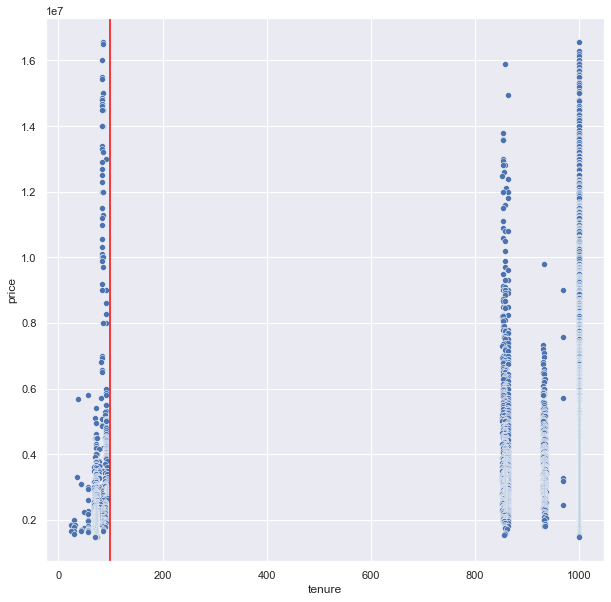

In [43]:
plt.figure(figsize=(10,10))
sns.scatterplot(y = merged_house_data['price'], x = merged_house_data['tenure'])
plt.axvline(x=99, color = 'red')

# To split up tenure within 99 years and >99 years

## House tenure within 99 years

In [44]:
merged_house99 = merged_house_data[merged_house_data['tenure'] <=99]

In [45]:
merged_house99.shape

(1340, 45)

In [46]:
merged_house99.head()

,index,project name,street name,tenure,no. of units,price,nett price,areasq,type of area,floor level,unit price psf,date of sale,market segment_CCR,market segment_OCR,market segment_RCR,postal district_2.0,postal district_3.0,postal district_4.0,postal district_5.0,postal district_8.0,postal district_9.0,postal district_10.0,postal district_11.0,postal district_12.0,postal district_13.0,postal district_14.0,postal district_15.0,postal district_16.0,postal district_17.0,postal district_18.0,postal district_19.0,postal district_20.0,postal district_21.0,postal district_22.0,postal district_23.0,postal district_25.0,postal district_26.0,postal district_27.0,postal district_28.0,type_Detached,type_Semi-detached,type_Terrace,type of sale_New Sale,type of sale_Resale,type of sale_Sub Sale
0,0,LANDED HOUSING DEVELOPMENT,PEARL ISLAND,86,1.0,16550000.0,-,8940.0,Land,-,1851.0,Jun-2017,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,2,LANDED HOUSING DEVELOPMENT,COVE DRIVE,85,1.0,16500000.0,-,7281.0,Land,-,2266.0,Sep-2020,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
7,7,LANDED HOUSING DEVELOPMENT,OCEAN DRIVE,83,1.0,16000000.0,-,7816.0,Land,-,2047.0,Feb-2021,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
19,19,LANDED HOUSING DEVELOPMENT,LAKESHORE VIEW,83,1.0,15500000.0,-,8576.0,Land,-,1807.0,Jul-2017,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
24,24,LANDED HOUSING DEVELOPMENT,LAKESHORE VIEW,84,1.0,15450000.0,-,10181.0,Land,-,1518.0,Aug-2020,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0


## House tenure > 99 years

In [47]:
freehold = merged_house_data[merged_house_data['tenure'] >=99]

In [48]:
freehold.shape

(7900, 45)

# Modelling for within 99 years

<AxesSubplot:xlabel='tenure', ylabel='price'>

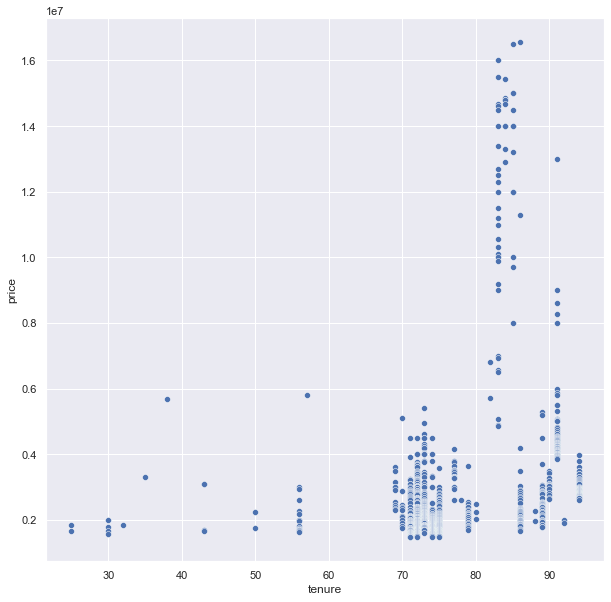

In [49]:
plt.figure(figsize=(10,10))
sns.scatterplot(y = merged_house99['price'], x = merged_house99['tenure'])

In [50]:
X99 = merged_house99.drop(columns =['price', 'unit price psf', 'index', 'project name', 'street name', 'nett price', 'type of area','floor level','date of sale',])
y99 = merged_house99['price']

In [51]:
# Create train/test splits.
X99_train, X99_test, y99_train, y99_test = train_test_split(X99, y99, test_size =0.25, random_state=42)

In [52]:
sc = StandardScaler()
Z99_train = sc.fit_transform(X99_train)
Z99_test = sc.transform(X99_test)

In [53]:
#fit using the training data
lr.fit(Z99_train, y99_train);

In [54]:
lr.score(Z99_train, y99_train)

0.9319000854832667

In [55]:
lr.score(Z99_test, y99_test)

0.8739396932241588

In [56]:
y_pred99 = lr.predict(Z99_train)
print(metrics.r2_score(y99_train, y_pred99))
print(metrics.mean_squared_error(y99_train, y_pred99))
print(np.sqrt(metrics.mean_squared_error(y99_train, y_pred99)))

0.9319000854832667
361425637015.134
601186.85698802


In [57]:
XGB99 = XGBRegressor()
XGB99.fit(Z99_train, y99_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [58]:
def xgb99(search):
    colsample_bytree = search.suggest_float("colsample_bytree", 0.1, 1.0)
    learning_rate = search.suggest_float("learning_rate", 0.1, 1.0) 
    max_depth = search.suggest_int("max_depth",1, 5)
    min_child_weight = search.suggest_int("min_child_weight", 1, 5)
    n_estimator = search.suggest_int("n_estimators", 100, 300)
    reg_lambda = search.suggest_loguniform("reg_lambda", 1e-8, 100)
    reg_alpha = search.suggest_loguniform("reg_alpha", 1e-8, 100)
    sub_sample = search.suggest_float("sub_sample", 0.1, 1.0)
    
    model = XGBRegressor(random_state = 42,
                         colsample_bytree = colsample_bytree,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         min_child_weight = min_child_weight,
                         n_estimator = n_estimator,
                         reg_lambda = reg_lambda, 
                         reg_alpha = reg_alpha,
                         sub_sample = sub_sample,
                         n_jobs = -1
                        )
    
    score = cross_val_score(model, Z99_train, y99_train, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 1)
    mean_score = score.mean()
    std_score = score.std()
    
    accuracy = mean_score - std_score
    
    return accuracy

study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed =42))
study.optimize(xgb99, n_trials=100)

[I 2022-01-05 00:53:36,199] A new study created in memory with name: no-name-5db652de-ce43-4430-aa19-d6677b81ce31


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:36,442] Trial 0 finished with value: -893299.0736329807 and parameters: {'colsample_bytree': 0.4370861069626263, 'learning_rate': 0.9556428757689246, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 131, 'reg_lambda': 3.6303224667798554e-07, 'reg_alpha': 3.809220577048033e-08, 'sub_sample': 0.8795585311974417}. Best is trial 0 with value: -893299.0736329807.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:53:36,592] Trial 1 finished with value: -700879.1058512873 and parameters: {'colsample_bytree': 0.6410035105688879, 'learning_rate': 0.737265320016441, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 267, 'reg_lambda': 1.3285903900544182e-06, 'reg_alpha': 6.580360277501306e-07, 'sub_sample': 0.2650640588680905}. Best is trial 1 with value: -700879.1058512873.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:36,791] Trial 2 finished with value: -791267.1278146202 and parameters: {'colsample_bytree': 0.373818018663584, 'learning_rate': 0.5722807884690141, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 222, 'reg_lambda': 2.4827821051950883e-07, 'reg_alpha': 8.345387083873532e-06, 'sub_sample': 0.4297256589643226}. Best is trial 1 with value: -700879.1058512873.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:53:36,937] Trial 3 finished with value: -705716.763838036 and parameters: {'colsample_bytree': 0.5104629857953323, 'learning_rate': 0.8066583652537123, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 219, 'reg_lambda': 2.9140978279786215e-08, 'reg_alpha': 0.011897302909454906, 'sub_sample': 0.2534717113185624}. Best is trial 1 with value: -700879.1058512873.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:37,140] Trial 4 finished with value: -806390.744508994 and parameters: {'colsample_bytree': 0.1585464336867516, 'learning_rate': 0.9539969835279999, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 161, 'reg_lambda': 9.478096804784244e-08, 'reg_alpha': 0.06955530592645753, 'sub_sample': 0.4961372443656412}. Best is trial 1 with value: -700879.1058512873.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:53:37,280] Trial 5 finished with value: -725755.142680755 and parameters: {'colsample_bytree': 0.20983441136030095, 'learning_rate': 0.5456592191001431, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 152, 'reg_lambda': 0.042191293826476094, 'reg_alpha': 1.3095158546031483e-05, 'sub_sample': 0.5680612190600297}. Best is trial 1 with value: -700879.1058512873.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:37,542] Trial 6 finished with value: -718798.103570287 and parameters: {'colsample_bytree': 0.5920392514089517, 'learning_rate': 0.26636900997297436, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 288, 'reg_lambda': 8.8771488946556, 'reg_alpha': 0.00952795699161383, 'sub_sample': 0.9296868115208051}. Best is trial 1 with value: -700879.1058512873.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:53:37,683] Trial 7 finished with value: -705725.2689650697 and parameters: {'colsample_bytree': 0.17964325184672755, 'learning_rate': 0.27638457617723067, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 178, 'reg_lambda': 5.169997317292732e-06, 'reg_alpha': 1.9380951355796903, 'sub_sample': 0.4210779940242304}. Best is trial 1 with value: -700879.1058512873.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:53:37,829] Trial 8 finished with value: -682622.2468465839 and parameters: {'colsample_bytree': 0.3528410587186427, 'learning_rate': 0.5884264748424236, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 114, 'reg_lambda': 73.9382838287635, 'reg_alpha': 0.5277736371601186, 'sub_sample': 0.2788441133807552}. Best is trial 8 with value: -682622.2468465839.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:38,004] Trial 9 finished with value: -752346.5930377294 and parameters: {'colsample_bytree': 0.10496990541124217, 'learning_rate': 0.8339152856093507, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 255, 'reg_lambda': 5.50106171658889e-08, 'reg_alpha': 3.842884090673403e-05, 'sub_sample': 0.20428215357261675}. Best is trial 8 with value: -682622.2468465839.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:38,207] Trial 10 finished with value: -616861.0466340006 and parameters: {'colsample_bytree': 0.9506228898073478, 'learning_rate': 0.10539746466023536, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 102, 'reg_lambda': 11.930206277066471, 'reg_alpha': 45.49871720727091, 'sub_sample': 0.7087760628118753}. Best is trial 10 with value: -616861.0466340006.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:38,412] Trial 11 finished with value: -632269.7494189957 and parameters: {'colsample_bytree': 0.9522656887511342, 'learning_rate': 0.10610829917726136, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 104, 'reg_lambda': 90.35283961927644, 'reg_alpha': 83.84571938920826, 'sub_sample': 0.6991240752081704}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:38,617] Trial 12 finished with value: -629678.7829233246 and parameters: {'colsample_bytree': 0.9949059251685877, 'learning_rate': 0.10704430136662829, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 108, 'reg_lambda': 0.44351354567392476, 'reg_alpha': 93.67984207486326, 'sub_sample': 0.7219088554958463}. Best is trial 10 with value: -616861.0466340006.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:38,827] Trial 13 finished with value: -625137.3621014663 and parameters: {'colsample_bytree': 0.9923889994877089, 'learning_rate': 0.13022729644102515, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 134, 'reg_lambda': 0.09235972019527162, 'reg_alpha': 98.54268387927638, 'sub_sample': 0.7475614345893371}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:39,033] Trial 14 finished with value: -721769.9341294917 and parameters: {'colsample_bytree': 0.8036258778955916, 'learning_rate': 0.27682502484650573, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 144, 'reg_lambda': 0.0010884139851548998, 'reg_alpha': 4.5752397106404175, 'sub_sample': 0.7679467651162889}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:39,279] Trial 15 finished with value: -797343.5072000982 and parameters: {'colsample_bytree': 0.823214227786357, 'learning_rate': 0.36235729756492396, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 190, 'reg_lambda': 0.06203653651522203, 'reg_alpha': 9.558060978793435, 'sub_sample': 0.6225878728371756}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:39,490] Trial 16 finished with value: -779052.3662849267 and parameters: {'colsample_bytree': 0.8293137156620446, 'learning_rate': 0.4163694923198906, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 128, 'reg_lambda': 0.0007474444225712796, 'reg_alpha': 0.1744462493858267, 'sub_sample': 0.8165262447469124}. Best is trial 10 with value: -616861.0466340006.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:39,731] Trial 17 finished with value: -690939.1125937502 and parameters: {'colsample_bytree': 0.7039253366568207, 'learning_rate': 0.18908964944524217, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 166, 'reg_lambda': 1.8406766812160393, 'reg_alpha': 0.0013120455121716985, 'sub_sample': 0.9729647009914558}. Best is trial 10 with value: -616861.0466340006.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:40,007] Trial 18 finished with value: -784888.6412860779 and parameters: {'colsample_bytree': 0.9157352703442062, 'learning_rate': 0.4079921863917569, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 132, 'reg_lambda': 0.0011688601937396826, 'reg_alpha': 15.707640665054475, 'sub_sample': 0.6457895271776356}. Best is trial 10 with value: -616861.0466340006.


[00:53:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:40,251] Trial 19 finished with value: -684905.1785424912 and parameters: {'colsample_bytree': 0.7569125565135283, 'learning_rate': 0.18877739730254822, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 101, 'reg_lambda': 0.013674632547227507, 'reg_alpha': 0.8258719413474764, 'sub_sample': 0.8341568535785884}. Best is trial 10 with value: -616861.0466340006.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:40,571] Trial 20 finished with value: -788939.9755436111 and parameters: {'colsample_bytree': 0.8916395286510828, 'learning_rate': 0.46675518284192513, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 214, 'reg_lambda': 4.172345382886041, 'reg_alpha': 0.00029054946794909085, 'sub_sample': 0.5314178596512185}. Best is trial 10 with value: -616861.0466340006.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:40,809] Trial 21 finished with value: -627692.6585441222 and parameters: {'colsample_bytree': 0.9994806195535555, 'learning_rate': 0.11876435199847771, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 119, 'reg_lambda': 0.4256087674144116, 'reg_alpha': 98.25029605473303, 'sub_sample': 0.7399850182276808}. Best is trial 10 with value: -616861.0466340006.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:41,056] Trial 22 finished with value: -669242.034818204 and parameters: {'colsample_bytree': 0.9744437694789931, 'learning_rate': 0.1856099067993533, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 121, 'reg_lambda': 0.3014488650432597, 'reg_alpha': 80.03830051951881, 'sub_sample': 0.7539999904211074}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:41,289] Trial 23 finished with value: -629699.6994994307 and parameters: {'colsample_bytree': 0.883544086085835, 'learning_rate': 0.10294625569227764, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 142, 'reg_lambda': 0.006284167255049018, 'reg_alpha': 5.736197871540903, 'sub_sample': 0.6463751756000873}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:41,553] Trial 24 finished with value: -741346.1163991448 and parameters: {'colsample_bytree': 0.9941453085536469, 'learning_rate': 0.22514161039887431, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 119, 'reg_lambda': 0.4411461848021559, 'reg_alpha': 31.263737372030754, 'sub_sample': 0.8529764891708528}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:41,761] Trial 25 finished with value: -666849.820006303 and parameters: {'colsample_bytree': 0.7269641297463799, 'learning_rate': 0.331793305575265, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 178, 'reg_lambda': 12.915874296754978, 'reg_alpha': 0.201580167799955, 'sub_sample': 0.9994721446789164}. Best is trial 10 with value: -616861.0466340006.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:42,018] Trial 26 finished with value: -694124.800399665 and parameters: {'colsample_bytree': 0.881762217652429, 'learning_rate': 0.14427791529164263, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 143, 'reg_lambda': 5.805764848594342e-05, 'reg_alpha': 2.1567896866416385, 'sub_sample': 0.797436228642996}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:42,226] Trial 27 finished with value: -720481.7349240229 and parameters: {'colsample_bytree': 0.6683246672814683, 'learning_rate': 0.32464282310494535, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'reg_lambda': 1.2936967133270245, 'reg_alpha': 0.024918831485673563, 'sub_sample': 0.6963260712516087}. Best is trial 10 with value: -616861.0466340006.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:42,404] Trial 28 finished with value: -683620.0470623008 and parameters: {'colsample_bytree': 0.7830435383272368, 'learning_rate': 0.2300227848117237, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 160, 'reg_lambda': 0.06717231818711769, 'reg_alpha': 27.28497175216972, 'sub_sample': 0.5903633429509636}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:42,654] Trial 29 finished with value: -631029.8796996765 and parameters: {'colsample_bytree': 0.9272081822445771, 'learning_rate': 0.16492188373103128, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 132, 'reg_lambda': 22.89125140692687, 'reg_alpha': 4.448996188984284e-07, 'sub_sample': 0.9068348799832459}. Best is trial 10 with value: -616861.0466340006.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:42,868] Trial 30 finished with value: -839907.0712288349 and parameters: {'colsample_bytree': 0.8530573897926655, 'learning_rate': 0.6485441231867455, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 119, 'reg_lambda': 0.18457701358795642, 'reg_alpha': 2.67578861029397e-08, 'sub_sample': 0.8764870646294168}. Best is trial 10 with value: -616861.0466340006.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:43,086] Trial 31 finished with value: -627345.0705382483 and parameters: {'colsample_bytree': 0.9977018587989268, 'learning_rate': 0.10461748349235318, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 112, 'reg_lambda': 0.8770757290636861, 'reg_alpha': 88.7532140159273, 'sub_sample': 0.6976490054953512}. Best is trial 10 with value: -616861.0466340006.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:43,305] Trial 32 finished with value: -661968.3181349679 and parameters: {'colsample_bytree': 0.9318095802899232, 'learning_rate': 0.16389491327839595, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 135, 'reg_lambda': 1.6476329451439953, 'reg_alpha': 18.284131376660234, 'sub_sample': 0.6840660681057262}. Best is trial 10 with value: -616861.0466340006.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:43,489] Trial 33 finished with value: -673753.2576326842 and parameters: {'colsample_bytree': 0.9652252991274453, 'learning_rate': 0.23651977992101075, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 114, 'reg_lambda': 21.3616344754501, 'reg_alpha': 2.722981424005247, 'sub_sample': 0.7644267880719944}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:43,743] Trial 34 finished with value: -705441.9676353182 and parameters: {'colsample_bytree': 0.8550642654096356, 'learning_rate': 0.1432354929072751, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 124, 'reg_lambda': 0.01125011648447957, 'reg_alpha': 94.77454842626149, 'sub_sample': 0.4607791700652666}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:43,920] Trial 35 finished with value: -704175.355239096 and parameters: {'colsample_bytree': 0.4962159427434817, 'learning_rate': 0.1046378550555239, 'max_depth': 1, 'min_child_weight': 1, 'n_estimators': 245, 'reg_lambda': 1.217554988284851, 'reg_alpha': 0.7796352213730863, 'sub_sample': 0.7336026412617459}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=

[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:44,137] Trial 36 finished with value: -681599.1682235617 and parameters: {'colsample_bytree': 0.997121040723448, 'learning_rate': 0.29841991220832487, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 111, 'reg_lambda': 6.349596529931782, 'reg_alpha': 10.529593389116911, 'sub_sample': 0.6473579890007042}. Best is trial 10 with value: -616861.0466340006.


[00:53:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:53:44,312] Trial 37 finished with value: -723996.6074023994 and parameters: {'colsample_bytree': 0.3206185109329741, 'learning_rate': 0.9939148177478547, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 157, 'reg_lambda': 0.09981925853791275, 'reg_alpha': 26.712667994404924, 'sub_sample': 0.5944759756189265}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:44,520] Trial 38 finished with value: -694101.4727155631 and parameters: {'colsample_bytree': 0.6015501129979423, 'learning_rate': 0.22354260847544402, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 172, 'reg_lambda': 1.0633582693547669e-08, 'reg_alpha': 2.4208801196017427e-07, 'sub_sample': 0.8029498364036411}. Best is trial 10 with value: -616861.0466340006.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:44,778] Trial 39 finished with value: -798125.1966342767 and parameters: {'colsample_bytree': 0.9189682558542958, 'learning_rate': 0.49826417252379696, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 149, 'reg_lambda': 0.022889462940453395, 'reg_alpha': 0.1706958375349935, 'sub_sample': 0.534244775870094}. Best is trial 10 with value: -616861.0466340006.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:44,959] Trial 40 finished with value: -681451.2470039851 and parameters: {'colsample_bytree': 0.7636259607307713, 'learning_rate': 0.7090825835080673, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 206, 'reg_lambda': 0.0035315546432173875, 'reg_alpha': 0.0020831986245043936, 'sub_sample': 0.37428233723633575}. Best is trial 10 with value: -616861.0466340006.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:45,179] Trial 41 finished with value: -617158.8126114951 and parameters: {'colsample_bytree': 0.996433184578389, 'learning_rate': 0.10078216231848316, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 108, 'reg_lambda': 0.4646234568459599, 'reg_alpha': 96.75969123889459, 'sub_sample': 0.715577775781112}. Best is trial 10 with value: -616861.0466340006.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:45,397] Trial 42 finished with value: -662640.6618267793 and parameters: {'colsample_bytree': 0.9475731238970762, 'learning_rate': 0.1510362725481755, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 100, 'reg_lambda': 3.580362306743817, 'reg_alpha': 32.66311935433884, 'sub_sample': 0.677804546398193}. Best is trial 10 with value: -616861.0466340006.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:45,628] Trial 43 finished with value: -700347.3404270693 and parameters: {'colsample_bytree': 0.9523852237006878, 'learning_rate': 0.21163264767546272, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 113, 'reg_lambda': 0.433801804862025, 'reg_alpha': 5.395704332540935, 'sub_sample': 0.7326988730702403}. Best is trial 10 with value: -616861.0466340006.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:45,850] Trial 44 finished with value: -607337.9087324705 and parameters: {'colsample_bytree': 0.9977014108202379, 'learning_rate': 0.1338121618053207, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 135, 'reg_lambda': 48.62467354798181, 'reg_alpha': 44.90391624150602, 'sub_sample': 0.7695860031820653}. Best is trial 44 with value: -607337.9087324705.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:46,034] Trial 45 finished with value: -678699.0206633512 and parameters: {'colsample_bytree': 0.8721279591859201, 'learning_rate': 0.2636641254742337, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 134, 'reg_lambda': 27.1515826762274, 'reg_alpha': 1.3404598534400818, 'sub_sample': 0.8685891924144581}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:46,253] Trial 46 finished with value: -654517.4099917068 and parameters: {'colsample_bytree': 0.9173039171198504, 'learning_rate': 0.8474424692580206, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 111, 'reg_lambda': 53.173018987931556, 'reg_alpha': 6.624931440197125, 'sub_sample': 0.9311914480876413}. Best is trial 44 with value: -607337.9087324705.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:46,477] Trial 47 finished with value: -670191.9133949653 and parameters: {'colsample_bytree': 0.29157971698914037, 'learning_rate': 0.14511101460917902, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 150, 'reg_lambda': 5.951251609541822, 'reg_alpha': 42.36827848130525, 'sub_sample': 0.7998866525180711}. Best is trial 44 with value: -607337.9087324705.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:46,808] Trial 48 finished with value: -777384.9541122111 and parameters: {'colsample_bytree': 0.4168252879466232, 'learning_rate': 0.19029193213420148, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 126, 'reg_lambda': 0.00015438616158794047, 'reg_alpha': 12.459556726076146, 'sub_sample': 0.6048062801539189}. Best is trial 44 with value: -607337.9087324705.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:46,987] Trial 49 finished with value: -683464.6291429474 and parameters: {'colsample_bytree': 0.8255231626897888, 'learning_rate': 0.25670679658914075, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 140, 'reg_lambda': 9.364404674614759e-07, 'reg_alpha': 7.304130187020202e-05, 'sub_sample': 0.7816202156901586}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:47,265] Trial 50 finished with value: -613536.5057847041 and parameters: {'colsample_bytree': 0.9673969610854026, 'learning_rate': 0.1317356531279237, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 288, 'reg_lambda': 89.53486031864597, 'reg_alpha': 2.9266422945425634, 'sub_sample': 0.6732839262668425}. Best is trial 44 with value: -607337.9087324705.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:47,479] Trial 51 finished with value: -622732.1535722964 and parameters: {'colsample_bytree': 0.9519815463485992, 'learning_rate': 0.13321613658361398, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 239, 'reg_lambda': 84.72090521061666, 'reg_alpha': 2.6108163899128094, 'sub_sample': 0.674034856757176}. Best is trial 44 with value: -607337.9087324705.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:47,762] Trial 52 finished with value: -631263.7325779317 and parameters: {'colsample_bytree': 0.9085503871905056, 'learning_rate': 0.18850660898848476, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 299, 'reg_lambda': 67.88517526743452, 'reg_alpha': 0.33853985827722444, 'sub_sample': 0.5583960309694821}. Best is trial 44 with value: -607337.9087324705.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:48,039] Trial 53 finished with value: -613789.6065031982 and parameters: {'colsample_bytree': 0.9532866129093132, 'learning_rate': 0.1374891534879191, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 275, 'reg_lambda': 89.03299594793566, 'reg_alpha': 0.04224644706179857, 'sub_sample': 0.6405841208036333}. Best is trial 44 with value: -607337.9087324705.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:48,315] Trial 54 finished with value: -616996.7634750325 and parameters: {'colsample_bytree': 0.9526269242009668, 'learning_rate': 0.1429219689825147, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 274, 'reg_lambda': 91.21029458012954, 'reg_alpha': 0.052343289466430055, 'sub_sample': 0.6523108338916186}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:48,596] Trial 55 finished with value: -666026.931796237 and parameters: {'colsample_bytree': 0.8441057874547704, 'learning_rate': 0.29620057726253474, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 273, 'reg_lambda': 33.85663426688646, 'reg_alpha': 0.0481665849848168, 'sub_sample': 0.4995834728354398}. Best is trial 44 with value: -607337.9087324705.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:48,872] Trial 56 finished with value: -739824.637867834 and parameters: {'colsample_bytree': 0.7970905019684874, 'learning_rate': 0.3792976989386495, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 274, 'reg_lambda': 11.64334899061037, 'reg_alpha': 0.0054680688504179665, 'sub_sample': 0.6402750175163073}. Best is trial 44 with value: -607337.9087324705.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:49,187] Trial 57 finished with value: -617141.9538540907 and parameters: {'colsample_bytree': 0.9532636848738947, 'learning_rate': 0.1727875235669007, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 295, 'reg_lambda': 99.60750240146065, 'reg_alpha': 0.06979535115948056, 'sub_sample': 0.5654775863681578}. Best is trial 44 with value: -607337.9087324705.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:49,499] Trial 58 finished with value: -624427.7604854754 and parameters: {'colsample_bytree': 0.8898590158853095, 'learning_rate': 0.1736971245675357, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 289, 'reg_lambda': 88.56189580002834, 'reg_alpha': 0.08628319582060937, 'sub_sample': 0.1541569856321262}. Best is trial 44 with value: -607337.9087324705.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:49,817] Trial 59 finished with value: -673256.6395918472 and parameters: {'colsample_bytree': 0.9581943629118108, 'learning_rate': 0.20830801033593516, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 259, 'reg_lambda': 14.273541746558061, 'reg_alpha': 0.005882980433799722, 'sub_sample': 0.4970005046356142}. Best is trial 44 with value: -607337.9087324705.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:50,098] Trial 60 finished with value: -749591.4481412105 and parameters: {'colsample_bytree': 0.9001979847782918, 'learning_rate': 0.24276218286383144, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 283, 'reg_lambda': 3.0304819692968388, 'reg_alpha': 0.01865304488347072, 'sub_sample': 0.40091422729415194}. Best is trial 44 with value: -607337.9087324705.


[00:53:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:50,380] Trial 61 finished with value: -634251.5337568988 and parameters: {'colsample_bytree': 0.9677059181079625, 'learning_rate': 0.12971212141571836, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 298, 'reg_lambda': 39.785885371469526, 'reg_alpha': 0.4953550281602985, 'sub_sample': 0.5689459265304427}. Best is trial 44 with value: -607337.9087324705.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:50,664] Trial 62 finished with value: -704980.4986402374 and parameters: {'colsample_bytree': 0.9462876048535419, 'learning_rate': 0.15794076478766353, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 286, 'reg_lambda': 10.409908904766876, 'reg_alpha': 0.0024231493010252974, 'sub_sample': 0.712940723902945}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:50,985] Trial 63 finished with value: -634513.9013519682 and parameters: {'colsample_bytree': 0.9740771908593022, 'learning_rate': 0.10121925334393272, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 264, 'reg_lambda': 93.10295434389664, 'reg_alpha': 0.047786070082571595, 'sub_sample': 0.6115538133859351}. Best is trial 44 with value: -607337.9087324705.


[00:53:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:51,297] Trial 64 finished with value: -645955.246658325 and parameters: {'colsample_bytree': 0.9267912729681911, 'learning_rate': 0.20009508252228173, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 276, 'reg_lambda': 32.13990152372138, 'reg_alpha': 0.09848694908716575, 'sub_sample': 0.6701862690568609}. Best is trial 44 with value: -607337.9087324705.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:51,578] Trial 65 finished with value: -672063.0975870055 and parameters: {'colsample_bytree': 0.8633583110490674, 'learning_rate': 0.13168121846443517, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 229, 'reg_lambda': 18.53125124410872, 'reg_alpha': 0.00036526693690586007, 'sub_sample': 0.8317783818184766}. Best is trial 44 with value: -607337.9087324705.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:51,867] Trial 66 finished with value: -723510.3574006396 and parameters: {'colsample_bytree': 0.9758402738632348, 'learning_rate': 0.16953716188905027, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 293, 'reg_lambda': 6.624437179434489, 'reg_alpha': 1.5595354303537114, 'sub_sample': 0.6245434464121151}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:52,119] Trial 67 finished with value: -727880.022032822 and parameters: {'colsample_bytree': 0.8962183633731458, 'learning_rate': 0.2791229192314517, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 252, 'reg_lambda': 2.690951580058709, 'reg_alpha': 0.011618035161849128, 'sub_sample': 0.5768467986560497}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:52,422] Trial 68 finished with value: -627732.2681033008 and parameters: {'colsample_bytree': 0.8150397491797301, 'learning_rate': 0.12232719986458929, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 190, 'reg_lambda': 42.45173107016188, 'reg_alpha': 49.763694765604136, 'sub_sample': 0.6564804582268133}. Best is trial 44 with value: -607337.9087324705.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:52,712] Trial 69 finished with value: -776283.0725185953 and parameters: {'colsample_bytree': 0.9994135999628736, 'learning_rate': 0.5973152237832275, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 281, 'reg_lambda': 11.452172859058846, 'reg_alpha': 0.025638687709815818, 'sub_sample': 0.7080016790706407}. Best is trial 44 with value: -607337.9087324705.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:53,040] Trial 70 finished with value: -674764.7447151052 and parameters: {'colsample_bytree': 0.92844310573576, 'learning_rate': 0.32777033411676093, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 267, 'reg_lambda': 48.4950489215914, 'reg_alpha': 2.797597643562579e-06, 'sub_sample': 0.5271366291557801}. Best is trial 44 with value: -607337.9087324705.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:53,288] Trial 71 finished with value: -612730.3830868462 and parameters: {'colsample_bytree': 0.946889742006211, 'learning_rate': 0.13261039829273194, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 237, 'reg_lambda': 98.06077256265867, 'reg_alpha': 3.3485231383072125, 'sub_sample': 0.7582901523948982}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:53,537] Trial 72 finished with value: -610917.6855268846 and parameters: {'colsample_bytree': 0.9729529251442866, 'learning_rate': 0.16326373628573626, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 234, 'reg_lambda': 94.23158027724881, 'reg_alpha': 3.7685254260860837, 'sub_sample': 0.7732232763483534}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:53,788] Trial 73 finished with value: -642619.4410125518 and parameters: {'colsample_bytree': 0.8735239439095324, 'learning_rate': 0.1702338648041048, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 227, 'reg_lambda': 21.766664959645624, 'reg_alpha': 3.665376101659549, 'sub_sample': 0.7384783413315645}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:54,041] Trial 74 finished with value: -643788.7763354074 and parameters: {'colsample_bytree': 0.9364675867105221, 'learning_rate': 0.20413536920699238, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 215, 'reg_lambda': 57.81817321892861, 'reg_alpha': 0.7995801049543328, 'sub_sample': 0.7743358518701254}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:54,291] Trial 75 finished with value: -608208.8663083004 and parameters: {'colsample_bytree': 0.9707624295663033, 'learning_rate': 0.14922798575901874, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 239, 'reg_lambda': 92.95752426523525, 'reg_alpha': 0.3770579400034316, 'sub_sample': 0.8315969185301204}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:54,551] Trial 76 finished with value: -685931.0311449878 and parameters: {'colsample_bytree': 0.9755505483947225, 'learning_rate': 0.12975586929628308, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 245, 'reg_lambda': 1.1038230959643176e-05, 'reg_alpha': 0.27027512989239494, 'sub_sample': 0.8400798704923338}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:54,803] Trial 77 finished with value: -663675.0086033625 and parameters: {'colsample_bytree': 0.9031005970339822, 'learning_rate': 0.23956118023312734, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 236, 'reg_lambda': 19.933966457259206, 'reg_alpha': 7.716638107313151, 'sub_sample': 0.9026328865468318}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:55,043] Trial 78 finished with value: -665147.476012608 and parameters: {'colsample_bytree': 0.5397187907750919, 'learning_rate': 0.1420737317558285, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 205, 'reg_lambda': 5.361920144923896, 'reg_alpha': 1.1784657624283974, 'sub_sample': 0.813704112684674}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:55,286] Trial 79 finished with value: -656422.9484286336 and parameters: {'colsample_bytree': 0.852829071630408, 'learning_rate': 0.21718181264829034, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 221, 'reg_lambda': 35.22120851887856, 'reg_alpha': 17.376577516618447, 'sub_sample': 0.7499128466360314}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:55,538] Trial 80 finished with value: -770641.132486681 and parameters: {'colsample_bytree': 0.9743771879679423, 'learning_rate': 0.8821800846402603, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 258, 'reg_lambda': 9.03078827277364, 'reg_alpha': 0.37560652268548494, 'sub_sample': 0.7782583671948242}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:55,823] Trial 81 finished with value: -618635.6852111076 and parameters: {'colsample_bytree': 0.944495345826126, 'learning_rate': 0.1696649734547473, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 279, 'reg_lambda': 88.74127507524625, 'reg_alpha': 0.13440088906574607, 'sub_sample': 0.6292117135640243}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:56,147] Trial 82 finished with value: -610727.7370259066 and parameters: {'colsample_bytree': 0.913920923771875, 'learning_rate': 0.15264972738977595, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 264, 'reg_lambda': 94.6830547465012, 'reg_alpha': 0.051626537210083284, 'sub_sample': 0.6945951994609659}. Best is trial 44 with value: -607337.9087324705.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:56,475] Trial 83 finished with value: -637460.7833905986 and parameters: {'colsample_bytree': 0.9270332924175799, 'learning_rate': 0.15295949597913566, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 270, 'reg_lambda': 51.079375391970196, 'reg_alpha': 0.7393151259572341, 'sub_sample': 0.6997241525777964}. Best is trial 44 with value: -607337.9087324705.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:56,783] Trial 84 finished with value: -652525.215566611 and parameters: {'colsample_bytree': 0.9739102599778614, 'learning_rate': 0.11600538642111595, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 249, 'reg_lambda': 23.840424658119073, 'reg_alpha': 2.458119126284255, 'sub_sample': 0.6621199682862904}. Best is trial 44 with value: -607337.9087324705.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:57,109] Trial 85 finished with value: -703384.2891274089 and parameters: {'colsample_bytree': 0.885204444881271, 'learning_rate': 0.18750512635382072, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 230, 'reg_lambda': 15.42401810712783, 'reg_alpha': 0.043190017349603316, 'sub_sample': 0.7913605968210577}. Best is trial 44 with value: -607337.9087324705.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:57,404] Trial 86 finished with value: -629599.204790321 and parameters: {'colsample_bytree': 0.9122622482003508, 'learning_rate': 0.11840951319373873, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 263, 'reg_lambda': 41.9571704572014, 'reg_alpha': 6.992023164783618, 'sub_sample': 0.7574283267355824}. Best is trial 44 with value: -607337.9087324705.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:53:57,694] Trial 87 finished with value: -619978.4370909026 and parameters: {'colsample_bytree': 0.8401263154941595, 'learning_rate': 0.15094960905067484, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 239, 'reg_lambda': 53.15461645353425, 'reg_alpha': 3.6355656477478093, 'sub_sample': 0.8559652043750906}. Best is trial 44 with value: -607337.9087324705.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:57,906] Trial 88 finished with value: -716874.2332823018 and parameters: {'colsample_bytree': 0.1189464517812901, 'learning_rate': 0.21739417400426236, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 253, 'reg_lambda': 2.146888154801832, 'reg_alpha': 18.456922776227767, 'sub_sample': 0.6878302111397355}. Best is trial 44 with value: -607337.9087324705.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:58,147] Trial 89 finished with value: -659342.7387142222 and parameters: {'colsample_bytree': 0.2208402172498602, 'learning_rate': 0.1918967928241379, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 196, 'reg_lambda': 7.63117262372285, 'reg_alpha': 0.22129063983115813, 'sub_sample': 0.823333354116266}. Best is trial 44 with value: -607337.9087324705.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:58,397] Trial 90 finished with value: -618750.1502434267 and parameters: {'colsample_bytree': 0.7279716578906066, 'learning_rate': 0.10130649685826117, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 261, 'reg_lambda': 24.66887464456594, 'reg_alpha': 1.2316042621124705, 'sub_sample': 0.725461733304069}. Best is trial 44 with value: -607337.9087324705.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:58,650] Trial 91 finished with value: -615983.7505377647 and parameters: {'colsample_bytree': 0.9540142806548064, 'learning_rate': 0.16689133443981138, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 286, 'reg_lambda': 97.23357168793392, 'reg_alpha': 0.02300888988236939, 'sub_sample': 0.5891389284790693}. Best is trial 44 with value: -607337.9087324705.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:58,903] Trial 92 finished with value: -608179.9212541676 and parameters: {'colsample_bytree': 0.9826388047397194, 'learning_rate': 0.14407075380728188, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 290, 'reg_lambda': 88.14730486262589, 'reg_alpha': 0.0056543925396989134, 'sub_sample': 0.5880585964983693}. Best is trial 44 with value: -607337.9087324705.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:59,157] Trial 93 finished with value: -641617.590812321 and parameters: {'colsample_bytree': 0.9823977142229813, 'learning_rate': 0.2501446413674686, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 289, 'reg_lambda': 98.19678072043908, 'reg_alpha': 0.017741140630119376, 'sub_sample': 0.5864848644483948}. Best is trial 44 with value: -607337.9087324705.


[00:53:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:59,411] Trial 94 finished with value: -620028.3042705334 and parameters: {'colsample_bytree': 0.9994238108224307, 'learning_rate': 0.12904705504507075, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 284, 'reg_lambda': 55.12290594922058, 'reg_alpha': 0.006600819256974079, 'sub_sample': 0.61800193430185}. Best is trial 44 with value: -607337.9087324705.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:59,668] Trial 95 finished with value: -690945.6957366649 and parameters: {'colsample_bytree': 0.9277503173653215, 'learning_rate': 0.46215743928156927, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 293, 'reg_lambda': 27.58208327754732, 'reg_alpha': 0.03129738442399719, 'sub_sample': 0.7605561317148691}. Best is trial 44 with value: -607337.9087324705.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:53:59,914] Trial 96 finished with value: -684088.5243195059 and parameters: {'colsample_bytree': 0.6389333061907575, 'learning_rate': 0.17948356003617866, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 279, 'reg_lambda': 14.17108359759652, 'reg_alpha': 0.0011677941605189013, 'sub_sample': 0.684571990022367}. Best is trial 44 with value: -607337.9087324705.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:53:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:54:00,178] Trial 97 finished with value: -671708.3001889957 and parameters: {'colsample_bytree': 0.9604966762683801, 'learning_rate': 0.15600774221651198, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 271, 'reg_lambda': 4.335572734277744, 'reg_alpha': 0.002372874302701906, 'sub_sample': 0.5990780409995093}. Best is trial 44 with value: -607337.9087324705.


[00:54:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:54:00,435] Trial 98 finished with value: -689177.5269157623 and parameters: {'colsample_bytree': 0.9034335906248935, 'learning_rate': 0.7186251006939423, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 268, 'reg_lambda': 59.74974637482146, 'reg_alpha': 47.97176741011371, 'sub_sample': 0.7082870645790493}. Best is trial 44 with value: -607337.9087324705.


[00:54:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:54:00,657] Trial 99 finished with value: -631389.7258836566 and parameters: {'colsample_bytree': 0.980801007988271, 'learning_rate': 0.11875738833832611, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 287, 'reg_lambda': 2.0943147251147005e-07, 'reg_alpha': 0.0038344684176806277, 'sub_sample': 0.736341866240802}. Best is trial 44 with value: -607337.9087324705.


[00:54:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [59]:
study.best_params

{'colsample_bytree': 0.9977014108202379,
 'learning_rate': 0.1338121618053207,
 'max_depth': 2,
 'min_child_weight': 2,
 'n_estimators': 135,
 'reg_lambda': 48.62467354798181,
 'reg_alpha': 44.90391624150602,
 'sub_sample': 0.7695860031820653}

In [60]:
study.best_trial.value

-607337.9087324705

In [61]:
XGB99 = XGBRegressor(colsample_bytree=  0.9977014108202379, learning_rate= 0.1338121618053207, max_depth= 2 , min_child_weight= 2, n_estimators= 135,
reg_alpha= 44.90391624150602, reg_lambda= 48.62467354798181, sub_sample=  0.7695860031820653)
XGB99.fit(Z99_train, y99_train)

[00:54:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9977014108202379,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1338121618053207,
             max_delta_step=0, max_depth=2, min_child_weight=2, missing=nan,
             monotone_constraints='()', n_estimators=135, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=44.90391624150602, reg_lambda=48.62467354798181,
             scale_pos_weight=1, sub_sample=0.7695860031820653, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [62]:
XGB99.score(Z99_train, y99_train)

0.9670405494994226

In [63]:
XGB99.score(Z99_test, y99_test)

0.9192816975249573

In [64]:
y_pred99 = XGB99.predict(Z99_train)
print(metrics.r2_score(y99_train, y_pred99))
print(metrics.mean_squared_error(y99_train, y_pred99))
print(np.sqrt(metrics.mean_squared_error(y99_train, y_pred99)))

0.9670405494994226
174925188634.60364
418240.5870245063


# Modelling for >99 years

<AxesSubplot:xlabel='tenure', ylabel='price'>

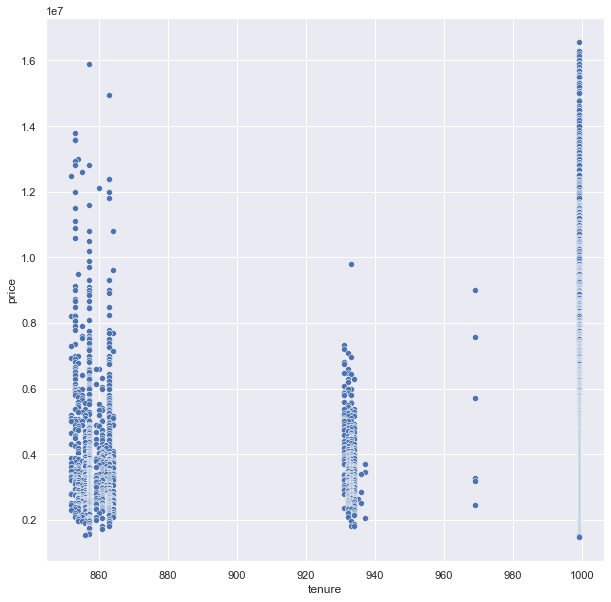

In [65]:
plt.figure(figsize=(10,10))
sns.scatterplot(y = freehold['price'], x = freehold['tenure'])

In [66]:
XFH = freehold.drop(columns =['price', 'unit price psf', 'index', 'project name', 'street name', 'nett price', 'type of area','floor level','date of sale',])
yFH = freehold['price']

In [67]:
# Create train/test splits.
XFH_train, XFH_test, yFH_train, yFH_test = train_test_split(XFH, yFH, test_size =0.25, random_state=42)

In [68]:
sc = StandardScaler()
ZFH_train = sc.fit_transform(XFH_train)
ZFH_test = sc.transform(XFH_test)

In [69]:
lr.fit(ZFH_train, yFH_train)

LinearRegression()

In [70]:
lr.score(ZFH_train, yFH_train)

0.8384543931360614

In [71]:
lr.score(ZFH_test, yFH_test)

0.8372295957007123

In [72]:
y_predFH = lr.predict(ZFH_train)
print(metrics.r2_score(yFH_train, y_predFH))
print(metrics.mean_squared_error(yFH_train, y_predFH))
print(np.sqrt(metrics.mean_squared_error(yFH_train, y_predFH)))

0.8384543931360614
848670566776.0857
921233.1772011284


In [73]:
XGBFH = XGBRegressor()
XGBFH.fit(ZFH_train, yFH_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [74]:
def xgbFH(search):
    colsample_bytree = search.suggest_float("colsample_bytree", 0.1, 1.0)
    learning_rate = search.suggest_float("learning_rate", 0.1, 1.0) 
    max_depth = search.suggest_int("max_depth",1, 5)
    min_child_weight = search.suggest_int("min_child_weight", 1, 5)
    n_estimator = search.suggest_int("n_estimators", 100, 300)
    reg_lambda = search.suggest_loguniform("reg_lambda", 1e-8, 100)
    reg_alpha = search.suggest_loguniform("reg_alpha", 1e-8, 100)
    sub_sample = search.suggest_float("sub_sample", 0.1, 1.0)
    
    model = XGBRegressor(random_state = 42,
                         colsample_bytree = colsample_bytree,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         min_child_weight = min_child_weight,
                         n_estimator = n_estimator,
                         reg_lambda = reg_lambda, 
                         reg_alpha = reg_alpha,
                         sub_sample = sub_sample,
                         n_jobs = -1
                        )
    
    score = cross_val_score(model, ZFH_train, yFH_train, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 1)
    mean_score = score.mean()
    std_score = score.std()
    
    accuracy = mean_score - std_score
    
    return accuracy

study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed =42))
study.optimize(xgbFH, n_trials=100)

[I 2022-01-05 00:54:01,389] A new study created in memory with name: no-name-df9a671c-bcab-457c-83b8-2d4d96d1b786
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:01,903] Trial 0 finished with value: -1012865.1100303921 and parameters: {'colsample_bytree': 0.4370861069626263, 'learning_rate': 0.9556428757689246, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 131, 'reg_lambda': 3.6303224667798554e-07, 'reg_alpha': 3.809220577048033e-08, 'sub_sample': 0.8795585311974417}. Best is trial 0 with value: -1012865.1100303921.


[00:54:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:54:02,198] Trial 1 finished with value: -971619.4127185704 and parameters: {'colsample_bytree': 0.6410035105688879, 'learning_rate': 0.737265320016441, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 267, 'reg_lambda': 1.3285903900544182e-06, 'reg_alpha': 6.580360277501306e-07, 'sub_sample': 0.2650640588680905}. Best is trial 1 with value: -971619.4127185704.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:54:02,632] Trial 2 finished with value: -929478.2798419088 and parameters: {'colsample_bytree': 0.373818018663584, 'learning_rate': 0.5722807884690141, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 222, 'reg_lambda': 2.4827821051950883e-07, 'reg_alpha': 8.345387083873532e-06, 'sub_sample': 0.4297256589643226}. Best is trial 2 with value: -929478.2798419088.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:54:02,913] Trial 3 finished with value: -973063.5075797047 and parameters: {'colsample_bytree': 0.5104629857953323, 'learning_rate': 0.8066583652537123, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 219, 'reg_lambda': 2.9140978279786215e-08, 'reg_alpha': 0.011897302909454906, 'sub_sample': 0.2534717113185624}. Best is trial 2 with value: -929478.2798419088.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:03,374] Trial 4 finished with value: -964754.1609801912 and parameters: {'colsample_bytree': 0.1585464336867516, 'learning_rate': 0.9539969835279999, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 161, 'reg_lambda': 9.478096804784244e-08, 'reg_alpha': 0.06955530592645753, 'sub_sample': 0.4961372443656412}. Best is trial 2 with value: -929478.2798419088.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:54:03,631] Trial 5 finished with value: -999418.50640558 and parameters: {'colsample_bytree': 0.20983441136030095, 'learning_rate': 0.5456592191001431, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 152, 'reg_lambda': 0.042191293826476094, 'reg_alpha': 1.3095158546031483e-05, 'sub_sample': 0.5680612190600297}. Best is trial 2 with value: -929478.2798419088.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:04,426] Trial 6 finished with value: -907062.7752824222 and parameters: {'colsample_bytree': 0.5920392514089517, 'learning_rate': 0.26636900997297436, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 288, 'reg_lambda': 8.8771488946556, 'reg_alpha': 0.00952795699161383, 'sub_sample': 0.9296868115208051}. Best is trial 6 with value: -907062.7752824222.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:54:04,708] Trial 7 finished with value: -1046309.8010280218 and parameters: {'colsample_bytree': 0.17964325184672755, 'learning_rate': 0.27638457617723067, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 178, 'reg_lambda': 5.169997317292732e-06, 'reg_alpha': 1.9380951355796903, 'sub_sample': 0.4210779940242304}. Best is trial 6 with value: -907062.7752824222.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:54:05,014] Trial 8 finished with value: -991774.1853286548 and parameters: {'colsample_bytree': 0.3528410587186427, 'learning_rate': 0.5884264748424236, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 114, 'reg_lambda': 73.9382838287635, 'reg_alpha': 0.5277736371601186, 'sub_sample': 0.2788441133807552}. Best is trial 6 with value: -907062.7752824222.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:54:05,424] Trial 9 finished with value: -933781.7430056953 and parameters: {'colsample_bytree': 0.10496990541124217, 'learning_rate': 0.8339152856093507, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 255, 'reg_lambda': 5.50106171658889e-08, 'reg_alpha': 3.842884090673403e-05, 'sub_sample': 0.20428215357261675}. Best is trial 6 with value: -907062.7752824222.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:54:06,336] Trial 10 finished with value: -891322.9058275828 and parameters: {'colsample_bytree': 0.9497157666716347, 'learning_rate': 0.10539746466023536, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 297, 'reg_lambda': 11.930206277066471, 'reg_alpha': 39.6011191452442, 'sub_sample': 0.9790910709802578}. Best is trial 10 with value: -891322.9058275828.


[00:54:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:54:07,253] Trial 11 finished with value: -917551.3550531934 and parameters: {'colsample_bytree': 0.9522656887511342, 'learning_rate': 0.10326321505087403, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 82.82843195255043, 'reg_alpha': 73.24607527580478, 'sub_sample': 0.971643831619738}. Best is trial 10 with value: -891322.9058275828.


[00:54:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:08,025] Trial 12 finished with value: -888086.6549989047 and parameters: {'colsample_bytree': 0.9925005566564994, 'learning_rate': 0.10376349477481495, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 0.5154377331302434, 'reg_alpha': 90.4650741825025, 'sub_sample': 0.7633847055950665}. Best is trial 12 with value: -888086.6549989047.


[00:54:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:08,646] Trial 13 finished with value: -897544.3475292595 and parameters: {'colsample_bytree': 0.9923243791594821, 'learning_rate': 0.13022729644102515, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 249, 'reg_lambda': 0.09378349935519929, 'reg_alpha': 98.54268387927638, 'sub_sample': 0.7487845791649022}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:09,376] Trial 14 finished with value: -908883.9863154769 and parameters: {'colsample_bytree': 0.8036754238817712, 'learning_rate': 0.31238205620906123, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 299, 'reg_lambda': 0.41076393480226686, 'reg_alpha': 4.597565143126377, 'sub_sample': 0.7485703696085376}. Best is trial 12 with value: -888086.6549989047.


[00:54:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:10,116] Trial 15 finished with value: -926819.580523105 and parameters: {'colsample_bytree': 0.8232606338416846, 'learning_rate': 0.3785650565789229, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 230, 'reg_lambda': 0.00018025803962518349, 'reg_alpha': 0.0004722471113306532, 'sub_sample': 0.7757597941503014}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:10,611] Trial 16 finished with value: -902915.5115122882 and parameters: {'colsample_bytree': 0.8293590883774569, 'learning_rate': 0.18956080791892976, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 272, 'reg_lambda': 0.002422937936560126, 'reg_alpha': 11.53781556702014, 'sub_sample': 0.6382070790266771}. Best is trial 12 with value: -888086.6549989047.



[00:54:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:11,455] Trial 17 finished with value: -947645.5514759329 and parameters: {'colsample_bytree': 0.7040878169584925, 'learning_rate': 0.40646081511251253, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 191, 'reg_lambda': 1.3653413153089615, 'reg_alpha': 0.20909870106086595, 'sub_sample': 0.8224792856088533}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:12,102] Trial 18 finished with value: -901232.7192134788 and parameters: {'colsample_bytree': 0.9157624395296518, 'learning_rate': 0.18794439591766746, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 246, 'reg_lambda': 0.0011688601937396826, 'reg_alpha': 14.248676710490964, 'sub_sample': 0.998671520773638}. Best is trial 12 with value: -888086.6549989047.


[00:54:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:54:13,058] Trial 19 finished with value: -922492.6611595475 and parameters: {'colsample_bytree': 0.7569125565135283, 'learning_rate': 0.42971306230222384, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 273, 'reg_lambda': 0.013674632547227507, 'reg_alpha': 0.0024991632080387707, 'sub_sample': 0.6620191188446702}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:13,653] Trial 20 finished with value: -911974.1071788436 and parameters: {'colsample_bytree': 0.8916395286510828, 'learning_rate': 0.20182904332062757, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 200, 'reg_lambda': 4.172345382886041, 'reg_alpha': 0.6110042540391938, 'sub_sample': 0.8759632190208623}. Best is trial 12 with value: -888086.6549989047.


[00:54:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:14,334] Trial 21 finished with value: -895633.651459765 and parameters: {'colsample_bytree': 0.9994749724944023, 'learning_rate': 0.11850666091376504, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 242, 'reg_lambda': 0.16716923107235643, 'reg_alpha': 98.25029605473303, 'sub_sample': 0.7161339807301532}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:14,838] Trial 22 finished with value: -913921.9669405313 and parameters: {'colsample_bytree': 0.9744423119055271, 'learning_rate': 0.11045886546479783, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 281, 'reg_lambda': 0.3001240077390563, 'reg_alpha': 80.03830051951881, 'sub_sample': 0.679600047948119}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:15,619] Trial 23 finished with value: -898313.2747638171 and parameters: {'colsample_bytree': 0.8835850336084491, 'learning_rate': 0.21857607700191833, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 232, 'reg_lambda': 6.99845301878467, 'reg_alpha': 5.564935246459967, 'sub_sample': 0.8302641399362295}. Best is trial 12 with value: -888086.6549989047.


[00:54:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:16,288] Trial 24 finished with value: -921224.7247860131 and parameters: {'colsample_bytree': 0.994148199052358, 'learning_rate': 0.33371508125247457, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 258, 'reg_lambda': 0.010219701477075157, 'reg_alpha': 31.282208206662975, 'sub_sample': 0.6179786564855541}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:54:17,213] Trial 25 finished with value: -971062.3821950165 and parameters: {'colsample_bytree': 0.7270308022828365, 'learning_rate': 0.47283716310954826, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 283, 'reg_lambda': 0.0001330155704910113, 'reg_alpha': 1.7791705309685055, 'sub_sample': 0.7312285074982868}. Best is trial 12 with value: -888086.6549989047.


[00:54:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:17,852] Trial 26 finished with value: -905860.3259675606 and parameters: {'colsample_bytree': 0.8817601508319566, 'learning_rate': 0.1568831078680074, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 243, 'reg_lambda': 17.630662804756003, 'reg_alpha': 0.06907692048441728, 'sub_sample': 0.919774780106112}. Best is trial 12 with value: -888086.6549989047.


[00:54:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:18,571] Trial 27 finished with value: -896741.7452862051 and parameters: {'colsample_bytree': 0.6685219219339875, 'learning_rate': 0.2519568597055678, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 300, 'reg_lambda': 1.2936967133270245, 'reg_alpha': 10.928664135402979, 'sub_sample': 0.5353708710577317}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:54:19,463] Trial 28 finished with value: -889075.0061807123 and parameters: {'colsample_bytree': 0.7830405519416489, 'learning_rate': 0.10023590107424163, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 211, 'reg_lambda': 0.21571143504465473, 'reg_alpha': 1.1630309868134046, 'sub_sample': 0.847886185131566}. Best is trial 12 with value: -888086.6549989047.


[00:54:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:20,306] Trial 29 finished with value: -975180.2475558794 and parameters: {'colsample_bytree': 0.7725350385835956, 'learning_rate': 0.6401427485130929, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 108, 'reg_lambda': 1.3053546345106075, 'reg_alpha': 1.3233621365064587, 'sub_sample': 0.8468836446503635}. Best is trial 12 with value: -888086.6549989047.


[00:54:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:54:21,186] Trial 30 finished with value: -959211.977581294 and parameters: {'colsample_bytree': 0.8498484175325118, 'learning_rate': 0.474409133346974, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 138, 'reg_lambda': 0.021402106572807635, 'reg_alpha': 2.67578861029397e-08, 'sub_sample': 0.8854383553682931}. Best is trial 12 with value: -888086.6549989047.


[00:54:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:21,948] Trial 31 finished with value: -892428.3700827226 and parameters: {'colsample_bytree': 0.9181054403392357, 'learning_rate': 0.10417975700858578, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 206, 'reg_lambda': 0.1462995691700912, 'reg_alpha': 23.182217214756424, 'sub_sample': 0.7955707339772886}. Best is trial 12 with value: -888086.6549989047.


[00:54:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:54:22,858] Trial 32 finished with value: -911030.4810930353 and parameters: {'colsample_bytree': 0.9289670011645158, 'learning_rate': 0.1637771683085397, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 210, 'reg_lambda': 0.4285289313909562, 'reg_alpha': 22.142301128021423, 'sub_sample': 0.9387448522909138}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:23,601] Trial 33 finished with value: -890677.266543766 and parameters: {'colsample_bytree': 0.9276359002206204, 'learning_rate': 0.23367484159309057, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 178, 'reg_lambda': 22.184298424257253, 'reg_alpha': 0.18386170831617202, 'sub_sample': 0.8078455243269418}. Best is trial 12 with value: -888086.6549989047.


[00:54:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:24,239] Trial 34 finished with value: -899477.0813640085 and parameters: {'colsample_bytree': 0.5320343586253606, 'learning_rate': 0.23516625251142867, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 186, 'reg_lambda': 33.6591241840452, 'reg_alpha': 1.6716843327795758e-07, 'sub_sample': 0.8900865662339552}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:25,023] Trial 35 finished with value: -904756.1795625825 and parameters: {'colsample_bytree': 0.6096607051422166, 'learning_rate': 0.3091861684365056, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 171, 'reg_lambda': 1.6004526918497628, 'reg_alpha': 0.10595240987347121, 'sub_sample': 0.989626977816097}. Best is trial 12 with value: -888086.6549989047.


[00:54:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:25,687] Trial 36 finished with value: -901004.7156095983 and parameters: {'colsample_bytree': 0.858082138042978, 'learning_rate': 0.16217760352815938, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 147, 'reg_lambda': 4.865821117359354, 'reg_alpha': 0.032204876448226255, 'sub_sample': 0.8159779680420627}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:26,563] Trial 37 finished with value: -908206.169825798 and parameters: {'colsample_bytree': 0.940254713479551, 'learning_rate': 0.3543160398111141, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 164, 'reg_lambda': 21.011649518630456, 'reg_alpha': 0.3803933338959721, 'sub_sample': 0.9448321876384475}. Best is trial 12 with value: -888086.6549989047.


[00:54:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:27,364] Trial 38 finished with value: -894117.9111866276 and parameters: {'colsample_bytree': 0.4419217065511291, 'learning_rate': 0.2564898103122538, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 262, 'reg_lambda': 1.0633582693547669e-08, 'reg_alpha': 0.0008195709821487643, 'sub_sample': 0.8744153169540814}. Best is trial 12 with value: -888086.6549989047.


[00:54:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:28,152] Trial 39 finished with value: -888996.2676388973 and parameters: {'colsample_bytree': 0.7785989189756867, 'learning_rate': 0.16317398088920498, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 123, 'reg_lambda': 0.0520727648704896, 'reg_alpha': 3.1814660038932128, 'sub_sample': 0.41203474324417466}. Best is trial 12 with value: -888086.6549989047.


[00:54:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:28,900] Trial 40 finished with value: -966205.5001592798 and parameters: {'colsample_bytree': 0.7867742648906224, 'learning_rate': 0.6982315680015357, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 128, 'reg_lambda': 0.062494034757706485, 'reg_alpha': 0.006076663507348109, 'sub_sample': 0.37428233723633575}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:29,604] Trial 41 finished with value: -891908.3748161196 and parameters: {'colsample_bytree': 0.7142416483864356, 'learning_rate': 0.1462212739358966, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 121, 'reg_lambda': 3.7133740362087586, 'reg_alpha': 2.6326246948704277, 'sub_sample': 0.3542458800763479}. Best is trial 12 with value: -888086.6549989047.


[00:54:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:30,372] Trial 42 finished with value: -894952.1169556556 and parameters: {'colsample_bytree': 0.655132903658286, 'learning_rate': 0.19065265097031497, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 100, 'reg_lambda': 0.0032666893931726625, 'reg_alpha': 0.6478170680494307, 'sub_sample': 0.4686049490890843}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:31,248] Trial 43 finished with value: -903828.7825662694 and parameters: {'colsample_bytree': 0.9482819658985966, 'learning_rate': 0.2815218023913334, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 153, 'reg_lambda': 89.99699687807122, 'reg_alpha': 6.025727602300246, 'sub_sample': 0.5820101465748542}. Best is trial 12 with value: -888086.6549989047.


[00:54:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:31,772] Trial 44 finished with value: -943500.8644450089 and parameters: {'colsample_bytree': 0.2879359304281217, 'learning_rate': 0.9587164841228554, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 217, 'reg_lambda': 0.49295891005989156, 'reg_alpha': 1.8177942687685829, 'sub_sample': 0.4454942684246962}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:32,277] Trial 45 finished with value: -893275.0852142026 and parameters: {'colsample_bytree': 0.5758324098306279, 'learning_rate': 0.14772413976394616, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 179, 'reg_lambda': 0.03613510388655667, 'reg_alpha': 0.00011018453927436406, 'sub_sample': 0.2879379123020175}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:32,970] Trial 46 finished with value: -958334.9773265831 and parameters: {'colsample_bytree': 0.8443744712324764, 'learning_rate': 0.8474424692580206, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 291, 'reg_lambda': 17.260471034530568, 'reg_alpha': 0.02973941143652797, 'sub_sample': 0.15892331758788547}. Best is trial 12 with value: -888086.6549989047.


[00:54:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:33,760] Trial 47 finished with value: -905802.5096692445 and parameters: {'colsample_bytree': 0.7480676106723647, 'learning_rate': 0.22021745177172772, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 133, 'reg_lambda': 1.5026981899247689e-06, 'reg_alpha': 40.13479332240364, 'sub_sample': 0.5194791889935978}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:34,462] Trial 48 finished with value: -922696.6929030648 and parameters: {'colsample_bytree': 0.8057535547034981, 'learning_rate': 0.2901129649634835, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 280, 'reg_lambda': 0.00015438616158794047, 'reg_alpha': 0.20891861274274223, 'sub_sample': 0.7757819187912589}. Best is trial 12 with value: -888086.6549989047.


[00:54:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:35,303] Trial 49 finished with value: -907088.4998024558 and parameters: {'colsample_bytree': 0.9614393397370373, 'learning_rate': 0.1027214223514265, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 229, 'reg_lambda': 37.36819580430204, 'reg_alpha': 5.1427537271548625, 'sub_sample': 0.7059026743259584}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:35,916] Trial 50 finished with value: -895818.242088408 and parameters: {'colsample_bytree': 0.8985376804153726, 'learning_rate': 0.17963380027110673, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 143, 'reg_lambda': 0.007982134779976382, 'reg_alpha': 10.473880777938847, 'sub_sample': 0.9598814975611567}. Best is trial 12 with value: -888086.6549989047.


[00:54:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:36,630] Trial 51 finished with value: -892294.6091114207 and parameters: {'colsample_bytree': 0.632167655614767, 'learning_rate': 0.14019230033545083, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 128, 'reg_lambda': 5.302859650410808, 'reg_alpha': 1.2953614154138603e-06, 'sub_sample': 0.3572870833027611}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:37,234] Trial 52 finished with value: -892302.6792621829 and parameters: {'colsample_bytree': 0.4978298875936215, 'learning_rate': 0.14266297608696116, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 115, 'reg_lambda': 2.100688178466149, 'reg_alpha': 3.5372408993950524, 'sub_sample': 0.3264222987819496}. Best is trial 12 with value: -888086.6549989047.


[00:54:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:37,880] Trial 53 finished with value: -891514.8196312619 and parameters: {'colsample_bytree': 0.7124167690645966, 'learning_rate': 0.223525460408817, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 124, 'reg_lambda': 0.7779104065449944, 'reg_alpha': 0.7059284160381978, 'sub_sample': 0.2368985873314702}. Best is trial 12 with value: -888086.6549989047.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:38,504] Trial 54 finished with value: -883507.0345742081 and parameters: {'colsample_bytree': 0.6852822145175478, 'learning_rate': 0.21846112220974537, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 159, 'reg_lambda': 0.23584334645270583, 'reg_alpha': 1.1810795628294504, 'sub_sample': 0.11050875659303303}. Best is trial 54 with value: -883507.0345742081.


[00:54:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:39,062] Trial 55 finished with value: -904247.3320297179 and parameters: {'colsample_bytree': 0.8066280515440993, 'learning_rate': 0.1901651074027103, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 161, 'reg_lambda': 0.21212917869803694, 'reg_alpha': 34.15352178315327, 'sub_sample': 0.17503700208129264}. Best is trial 54 with value: -883507.0345742081.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:39,743] Trial 56 finished with value: -886523.0022120216 and parameters: {'colsample_bytree': 0.6897611380035086, 'learning_rate': 0.10326139862968903, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 188, 'reg_lambda': 0.08746787386138687, 'reg_alpha': 0.21683038770278518, 'sub_sample': 0.5946439786257198}. Best is trial 54 with value: -883507.0345742081.


[00:54:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:40,521] Trial 57 finished with value: -893723.0725341314 and parameters: {'colsample_bytree': 0.7451310447642076, 'learning_rate': 0.23322682712929665, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 198, 'reg_lambda': 0.07208099941476702, 'reg_alpha': 0.15819434488665116, 'sub_sample': 0.5671437861586166}. Best is trial 54 with value: -883507.0345742081.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:41,359] Trial 58 finished with value: -884895.733085581 and parameters: {'colsample_bytree': 0.6805540672364656, 'learning_rate': 0.13337090676009394, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 181, 'reg_lambda': 0.03241125351297525, 'reg_alpha': 0.0345623455116139, 'sub_sample': 0.6272886569186654}. Best is trial 54 with value: -883507.0345742081.


[00:54:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:42,089] Trial 59 finished with value: -888051.5174807383 and parameters: {'colsample_bytree': 0.6773597006880931, 'learning_rate': 0.10202450088205761, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 170, 'reg_lambda': 0.02797646239658712, 'reg_alpha': 0.03855079413048358, 'sub_sample': 0.6613277198929008}. Best is trial 54 with value: -883507.0345742081.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:42,665] Trial 60 finished with value: -892675.6665117892 and parameters: {'colsample_bytree': 0.6874412295023067, 'learning_rate': 0.14124329067927052, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 170, 'reg_lambda': 0.000508990045703836, 'reg_alpha': 0.009447027252814535, 'sub_sample': 0.6128312791961033}. Best is trial 54 with value: -883507.0345742081.


[00:54:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:43,364] Trial 61 finished with value: -889039.3891719582 and parameters: {'colsample_bytree': 0.6235624811392261, 'learning_rate': 0.10187563844879337, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 188, 'reg_lambda': 0.02676792379940859, 'reg_alpha': 0.03606511938796765, 'sub_sample': 0.6627429907715118}. Best is trial 54 with value: -883507.0345742081.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:44,093] Trial 62 finished with value: -883958.5424507944 and parameters: {'colsample_bytree': 0.5721759763008317, 'learning_rate': 0.1295339414877157, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 188, 'reg_lambda': 0.004074566868367522, 'reg_alpha': 0.03122352332503671, 'sub_sample': 0.6514581272544984}. Best is trial 54 with value: -883507.0345742081.


[00:54:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:44,850] Trial 63 finished with value: -890792.6313466452 and parameters: {'colsample_bytree': 0.48063097631618723, 'learning_rate': 0.18675847817754598, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 194, 'reg_lambda': 0.0019860251209402827, 'reg_alpha': 0.002747325165745739, 'sub_sample': 0.5959013918000257}. Best is trial 54 with value: -883507.0345742081.


[00:54:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:54:45,659] Trial 64 finished with value: -880478.2219746171 and parameters: {'colsample_bytree': 0.5699577314010695, 'learning_rate': 0.12969814738414354, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 181, 'reg_lambda': 0.005674834332124879, 'reg_alpha': 0.05780263458098185, 'sub_sample': 0.679639079208946}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:46,348] Trial 65 finished with value: -883414.5227490597 and parameters: {'colsample_bytree': 0.547751027750571, 'learning_rate': 0.12442456934912832, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 183, 'reg_lambda': 0.0004116085794941093, 'reg_alpha': 0.057231224429414196, 'sub_sample': 0.6716427002221078}. Best is trial 64 with value: -880478.2219746171.


[00:54:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:47,043] Trial 66 finished with value: -882923.8893838607 and parameters: {'colsample_bytree': 0.5629026081011336, 'learning_rate': 0.12876121704076432, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 158, 'reg_lambda': 2.0793842611996746e-05, 'reg_alpha': 0.022015273275450154, 'sub_sample': 0.6912355441167809}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:47,647] Trial 67 finished with value: -892104.3428660916 and parameters: {'colsample_bytree': 0.5820032769390351, 'learning_rate': 0.13140467626154143, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 182, 'reg_lambda': 1.0731739020156236e-05, 'reg_alpha': 0.01699428569108248, 'sub_sample': 0.7024667717553699}. Best is trial 64 with value: -880478.2219746171.


[00:54:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:48,315] Trial 68 finished with value: -988026.3575648133 and parameters: {'colsample_bytree': 0.5458966794673165, 'learning_rate': 0.9126933562305632, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 159, 'reg_lambda': 2.4666566540281926e-05, 'reg_alpha': 0.004314131088395531, 'sub_sample': 0.11947856889555947}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:48,960] Trial 69 finished with value: -888492.8649543638 and parameters: {'colsample_bytree': 0.46253622301769537, 'learning_rate': 0.20039703225175742, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 173, 'reg_lambda': 0.005152785235077317, 'reg_alpha': 0.07292173805722801, 'sub_sample': 0.6319684983178685}. Best is trial 64 with value: -880478.2219746171.


[00:54:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:49,577] Trial 70 finished with value: -890454.6843249882 and parameters: {'colsample_bytree': 0.4089328430722031, 'learning_rate': 0.265020411208706, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 203, 'reg_lambda': 0.0005889887934312, 'reg_alpha': 0.0001980278353354507, 'sub_sample': 0.5053264528972707}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:50,260] Trial 71 finished with value: -886446.4042510831 and parameters: {'colsample_bytree': 0.6706505896393838, 'learning_rate': 0.1279002808663109, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 166, 'reg_lambda': 0.013198294815991997, 'reg_alpha': 0.018165968235975657, 'sub_sample': 0.6791300006856515}. Best is trial 64 with value: -880478.2219746171.


[00:54:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:50,881] Trial 72 finished with value: -884221.5124830646 and parameters: {'colsample_bytree': 0.5188998210431001, 'learning_rate': 0.13022418467479824, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 155, 'reg_lambda': 0.012573882184542702, 'reg_alpha': 0.017642438052290675, 'sub_sample': 0.6762100786062597}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:51,471] Trial 73 finished with value: -885201.4042676417 and parameters: {'colsample_bytree': 0.5229383831393237, 'learning_rate': 0.17003300873889163, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 154, 'reg_lambda': 5.635135769069124e-05, 'reg_alpha': 0.01569917964685205, 'sub_sample': 0.6740698524949298}. Best is trial 64 with value: -880478.2219746171.


[00:54:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:52,059] Trial 74 finished with value: -889076.1807593523 and parameters: {'colsample_bytree': 0.5211638671684066, 'learning_rate': 0.17306761557592756, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 154, 'reg_lambda': 4.8791419050673645e-05, 'reg_alpha': 0.0013389992944169116, 'sub_sample': 0.7268949156075194}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:52,663] Trial 75 finished with value: -886011.5546718407 and parameters: {'colsample_bytree': 0.5635164781908483, 'learning_rate': 0.19993923511982195, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 147, 'reg_lambda': 7.129527417561601e-05, 'reg_alpha': 0.007971520978944624, 'sub_sample': 0.7458331866637082}. Best is trial 64 with value: -880478.2219746171.


[00:54:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:53,286] Trial 76 finished with value: -932594.1586966525 and parameters: {'colsample_bytree': 0.6049383122952112, 'learning_rate': 0.5448033401440927, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 157, 'reg_lambda': 0.0007287527107851443, 'reg_alpha': 0.06451159227218888, 'sub_sample': 0.6449576502469947}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:54:53,726] Trial 77 finished with value: -910400.1874506595 and parameters: {'colsample_bytree': 0.39973005607707024, 'learning_rate': 0.1657844171129263, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 176, 'reg_lambda': 0.0002611537706004186, 'reg_alpha': 0.017808587060906822, 'sub_sample': 0.6896216129504852}. Best is trial 64 with value: -880478.2219746171.


[00:54:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:54,405] Trial 78 finished with value: -885130.5708907141 and parameters: {'colsample_bytree': 0.5031658800872215, 'learning_rate': 0.2128176825987465, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 182, 'reg_lambda': 3.2499276077767443e-06, 'reg_alpha': 0.003005538681013625, 'sub_sample': 0.5601673877643886}. Best is trial 64 with value: -880478.2219746171.


[00:54:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:54:54,943] Trial 79 finished with value: -897609.495409043 and parameters: {'colsample_bytree': 0.4767453961025627, 'learning_rate': 0.3019862777540231, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 195, 'reg_lambda': 3.8046110867312043e-06, 'reg_alpha': 0.0016314000398310105, 'sub_sample': 0.5349508387287456}. Best is trial 64 with value: -880478.2219746171.


[00:54:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:55,621] Trial 80 finished with value: -903943.160582186 and parameters: {'colsample_bytree': 0.5603364315882945, 'learning_rate': 0.34248728960043845, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 182, 'reg_lambda': 2.5342542952637317e-07, 'reg_alpha': 0.0031829245942307572, 'sub_sample': 0.5462096217112724}. Best is trial 64 with value: -880478.2219746171.


[00:54:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:56,280] Trial 81 finished with value: -881717.95438603 and parameters: {'colsample_bytree': 0.5084696803188393, 'learning_rate': 0.2104372027373725, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 142, 'reg_lambda': 1.1039815799238474e-05, 'reg_alpha': 0.0004484207786748806, 'sub_sample': 0.6165481477135761}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:56,945] Trial 82 finished with value: -887632.7192285389 and parameters: {'colsample_bytree': 0.5029663312704152, 'learning_rate': 0.24897342142100273, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 139, 'reg_lambda': 6.378208351009644e-07, 'reg_alpha': 0.0005747549893075489, 'sub_sample': 0.6193187749542345}. Best is trial 64 with value: -880478.2219746171.


[00:54:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:57,565] Trial 83 finished with value: -891318.4868913157 and parameters: {'colsample_bytree': 0.4422656754156654, 'learning_rate': 0.131163076937363, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 166, 'reg_lambda': 8.535318932420528e-06, 'reg_alpha': 0.0053030475085776, 'sub_sample': 0.6469963353023831}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:54:58,225] Trial 84 finished with value: -887358.5082263321 and parameters: {'colsample_bytree': 0.5443226855883389, 'learning_rate': 0.21406987553500478, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 147, 'reg_lambda': 1.5967536723602886e-06, 'reg_alpha': 0.00025558343278975524, 'sub_sample': 0.5643765146599837}. Best is trial 64 with value: -880478.2219746171.


[00:54:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:58,922] Trial 85 finished with value: -882542.1573961381 and parameters: {'colsample_bytree': 0.6043916691956024, 'learning_rate': 0.2046128759153173, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 183, 'reg_lambda': 0.0018809044372194584, 'reg_alpha': 8.540077347342637e-05, 'sub_sample': 0.5995386497703042}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:54:59,626] Trial 86 finished with value: -884020.2771748208 and parameters: {'colsample_bytree': 0.6416928849428488, 'learning_rate': 0.12953613184491064, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 191, 'reg_lambda': 0.0025606757545265364, 'reg_alpha': 4.9188857016892495e-05, 'sub_sample': 0.7650397571599901}. Best is trial 64 with value: -880478.2219746171.


[00:54:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:54:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:54:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:55:00,016] Trial 87 finished with value: -992786.6770748576 and parameters: {'colsample_bytree': 0.595474848106221, 'learning_rate': 0.15745030001170926, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 207, 'reg_lambda': 0.001545118345794065, 'reg_alpha': 2.0824820770304836e-05, 'sub_sample': 0.7744536220338495}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:00,675] Trial 88 finished with value: -896252.3708657734 and parameters: {'colsample_bytree': 0.6328094152695769, 'learning_rate': 0.12189422179736642, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 193, 'reg_lambda': 0.0031632721627193917, 'reg_alpha': 5.055918596627844e-05, 'sub_sample': 0.7366583925958978}. Best is trial 64 with value: -880478.2219746171.


[00:55:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:01,462] Trial 89 finished with value: -903505.5622940845 and parameters: {'colsample_bytree': 0.6440714312406998, 'learning_rate': 0.2489859574329148, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 135, 'reg_lambda': 0.0002959785724571644, 'reg_alpha': 4.379870319623912e-06, 'sub_sample': 0.703326448600395}. Best is trial 64 with value: -880478.2219746171.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:02,146] Trial 90 finished with value: -891996.6896515483 and parameters: {'colsample_bytree': 0.571454996179537, 'learning_rate': 0.27040016030842584, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 175, 'reg_lambda': 0.0009429970181131354, 'reg_alpha': 6.519704442104806e-05, 'sub_sample': 0.5970504201536733}. Best is trial 64 with value: -880478.2219746171.


[00:55:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:02,839] Trial 91 finished with value: -880167.4094752932 and parameters: {'colsample_bytree': 0.6109851425875317, 'learning_rate': 0.1502234274628887, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 187, 'reg_lambda': 0.006749542725149556, 'reg_alpha': 1.8709669168345616e-05, 'sub_sample': 0.6282663397411441}. Best is trial 91 with value: -880167.4094752932.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:03,524] Trial 92 finished with value: -883746.9395592816 and parameters: {'colsample_bytree': 0.6033744371243706, 'learning_rate': 0.18132119661511426, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'reg_lambda': 0.002906430644366092, 'reg_alpha': 7.655875711842336e-06, 'sub_sample': 0.7601533709209712}. Best is trial 91 with value: -880167.4094752932.


[00:55:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:04,216] Trial 93 finished with value: -881218.5237566306 and parameters: {'colsample_bytree': 0.5951787739523305, 'learning_rate': 0.18062640036227381, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'reg_lambda': 0.00603848899451309, 'reg_alpha': 9.712638575067117e-06, 'sub_sample': 0.7602946959863642}. Best is trial 91 with value: -880167.4094752932.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:04,911] Trial 94 finished with value: -879753.1892716187 and parameters: {'colsample_bytree': 0.610085596067029, 'learning_rate': 0.17792847517326818, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 200, 'reg_lambda': 0.008917321681577273, 'reg_alpha': 4.17576446752475e-06, 'sub_sample': 0.7889253612701237}. Best is trial 94 with value: -879753.1892716187.


[00:55:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:05,645] Trial 95 finished with value: -891828.0017062731 and parameters: {'colsample_bytree': 0.6142725442570375, 'learning_rate': 0.18312764788398805, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 215, 'reg_lambda': 0.006206376754409162, 'reg_alpha': 7.474251265195929e-06, 'sub_sample': 0.785977438184739}. Best is trial 94 with value: -879753.1892716187.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:06,338] Trial 96 finished with value: -886168.0928699218 and parameters: {'colsample_bytree': 0.5942446905230093, 'learning_rate': 0.20414760318505087, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 198, 'reg_lambda': 0.018820077351071603, 'reg_alpha': 1.392848222539589e-06, 'sub_sample': 0.8359940336286937}. Best is trial 94 with value: -879753.1892716187.


[00:55:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:07,014] Trial 97 finished with value: -889243.9215100161 and parameters: {'colsample_bytree': 0.5464556023597548, 'learning_rate': 0.15650312930739013, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 221, 'reg_lambda': 0.001571915636278157, 'reg_alpha': 1.6081141302900313e-05, 'sub_sample': 0.7174172196424904}. Best is trial 94 with value: -879753.1892716187.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:07,654] Trial 98 finished with value: -917162.6861942259 and parameters: {'colsample_bytree': 0.657443802074595, 'learning_rate': 0.39010487516617587, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 212, 'reg_lambda': 0.007319126097328126, 'reg_alpha': 3.5535892036091938e-06, 'sub_sample': 0.756965242094742}. Best is trial 94 with value: -879753.1892716187.


[00:55:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:08,319] Trial 99 finished with value: -899104.3177561782 and parameters: {'colsample_bytree': 0.6101665116592145, 'learning_rate': 0.31593920427510824, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 198, 'reg_lambda': 2.0904452398454546e-05, 'reg_alpha': 2.6474932091730416e-05, 'sub_sample': 0.7975837090522144}. Best is trial 94 with value: -879753.1892716187.


In [75]:
study.best_params

{'colsample_bytree': 0.610085596067029,
 'learning_rate': 0.17792847517326818,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 200,
 'reg_lambda': 0.008917321681577273,
 'reg_alpha': 4.17576446752475e-06,
 'sub_sample': 0.7889253612701237}

In [76]:
study.best_trial.value

-879753.1892716187

In [77]:
XGBFH = XGBRegressor(colsample_bytree=  0.610085596067029, learning_rate= 0.17792847517326818, max_depth= 4 , min_child_weight= 5, n_estimators= 200,
reg_alpha= 4.17576446752475e-06, reg_lambda= 0.008917321681577273, sub_sample=  0.7889253612701237)
XGBFH.fit(ZFH_train, yFH_train)

[00:55:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.610085596067029,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.17792847517326818,
             max_delta_step=0, max_depth=4, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=4.17576446752475e-06, reg_lambda=0.008917321681577273,
             scale_pos_weight=1, sub_sample=0.7889253612701237, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [78]:
XGBFH.score(ZFH_train, yFH_train)

0.9039106701348314

In [79]:
XGBFH.score(ZFH_test, yFH_test)

0.8613170360896257

In [80]:
y_predFH1 = XGBFH.predict(ZFH_train)
print(metrics.r2_score(yFH_train, y_predFH1))
print(metrics.mean_squared_error(yFH_train, y_predFH1))
print(np.sqrt(metrics.mean_squared_error(yFH_train, y_predFH1)))

0.9039106701348314
504799775251.64594
710492.628569534


# Using the removal of 10% data

In [81]:
merged_house_10 = pd.read_csv('./dataset_asof_051121/merged_house_10.csv')

In [82]:
merged_house_10.shape

(8753, 45)

(array([350., 373., 401., 566., 564., 731., 550., 639., 512., 448., 411.,
        373., 351., 261., 228., 177., 195., 148., 119., 147.,  80.,  93.,
        104.,  77.,  71.,  78.,  60.,  56.,  42.,  40.,  45.,  43.,  49.,
         25.,  38.,  22.,  26.,  21.,  36.,  19.,  26.,  22.,  16.,  18.,
         21.,  24.,  11.,  17.,  17.,  12.]),
 array([ 1650000.,  1842760.,  2035520.,  2228280.,  2421040.,  2613800.,
         2806560.,  2999320.,  3192080.,  3384840.,  3577600.,  3770360.,
         3963120.,  4155880.,  4348640.,  4541400.,  4734160.,  4926920.,
         5119680.,  5312440.,  5505200.,  5697960.,  5890720.,  6083480.,
         6276240.,  6469000.,  6661760.,  6854520.,  7047280.,  7240040.,
         7432800.,  7625560.,  7818320.,  8011080.,  8203840.,  8396600.,
         8589360.,  8782120.,  8974880.,  9167640.,  9360400.,  9553160.,
         9745920.,  9938680., 10131440., 10324200., 10516960., 10709720.,
        10902480., 11095240., 11288000.]),
 <BarContainer object o

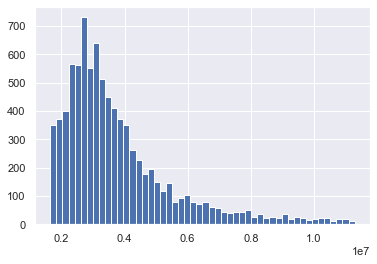

In [83]:
price = merged_house_10['price']

plt.hist(price, bins =50)
# still skewed to left

In [84]:
X10 = merged_house_10.drop(columns =['price', 'unit price psf', 'index', 'project name', 'street name', 'nett price', 'type of area','floor level','date of sale',])
y10 = merged_house_10['price']

In [85]:
# Create train/test splits.
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10, test_size =0.25, random_state=42)

In [86]:
Z10_train = sc.fit_transform(X10_train)
Z10_test = sc.transform(X10_test)

In [87]:
lr.fit(Z10_train, y10_train)

LinearRegression()

In [88]:
lr.score(Z10_train, y10_train)

0.796163256680808

In [89]:
lr.score(Z10_test, y10_test)

0.7847529251183596

In [90]:
XGB10 = XGBRegressor()
XGB10.fit(Z10_train, y10_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [91]:
def xgb10(search):
    colsample_bytree = search.suggest_float("colsample_bytree", 0.1, 1.0)
    learning_rate = search.suggest_float("learning_rate", 0.1, 1.0) 
    max_depth = search.suggest_int("max_depth",1, 5)
    min_child_weight = search.suggest_int("min_child_weight", 1, 5)
    n_estimator = search.suggest_int("n_estimators", 100, 300)
    reg_lambda = search.suggest_loguniform("reg_lambda", 1e-8, 100)
    reg_alpha = search.suggest_loguniform("reg_alpha", 1e-8, 100)
    sub_sample = search.suggest_float("sub_sample", 0.1, 1.0)
    
    model = XGBRegressor(random_state = 42,
                         colsample_bytree = colsample_bytree,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         min_child_weight = min_child_weight,
                         n_estimator = n_estimator,
                         reg_lambda = reg_lambda, 
                         reg_alpha = reg_alpha,
                         sub_sample = sub_sample,
                         n_jobs = -1
                        )
    
    score = cross_val_score(model, Z10_train, y10_train, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 1)
    mean_score = score.mean()
    std_score = score.std()
    
    accuracy = mean_score - std_score
    
    return accuracy

study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed =42))
study.optimize(xgb10, n_trials=100)

[I 2022-01-05 00:55:09,387] A new study created in memory with name: no-name-c2a3923e-cd14-407e-8f77-06e30402c02f
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:10,009] Trial 0 finished with value: -784072.7844767828 and parameters: {'colsample_bytree': 0.4370861069626263, 'learning_rate': 0.9556428757689246, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 131, 'reg_lambda': 3.6303224667798554e-07, 'reg_alpha': 3.809220577048033e-08, 'sub_sample': 0.8795585311974417}. Best is trial 0 with value: -784072.7844767828.


[00:55:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:55:10,350] Trial 1 finished with value: -818654.1809696965 and parameters: {'colsample_bytree': 0.6410035105688879, 'learning_rate': 0.737265320016441, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 267, 'reg_lambda': 1.3285903900544182e-06, 'reg_alpha': 6.580360277501306e-07, 'sub_sample': 0.2650640588680905}. Best is trial 0 with value: -784072.7844767828.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:10,852] Trial 2 finished with value: -728646.0890404525 and parameters: {'colsample_bytree': 0.373818018663584, 'learning_rate': 0.5722807884690141, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 222, 'reg_lambda': 2.4827821051950883e-07, 'reg_alpha': 8.345387083873532e-06, 'sub_sample': 0.4297256589643226}. Best is trial 2 with value: -728646.0890404525.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:55:11,180] Trial 3 finished with value: -818397.0546939196 and parameters: {'colsample_bytree': 0.5104629857953323, 'learning_rate': 0.8066583652537123, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 219, 'reg_lambda': 2.9140978279786215e-08, 'reg_alpha': 0.011897302909454906, 'sub_sample': 0.2534717113185624}. Best is trial 2 with value: -728646.0890404525.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:11,731] Trial 4 finished with value: -758982.9167986339 and parameters: {'colsample_bytree': 0.1585464336867516, 'learning_rate': 0.9539969835279999, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 161, 'reg_lambda': 9.478096804784244e-08, 'reg_alpha': 0.06955530592645753, 'sub_sample': 0.4961372443656412}. Best is trial 2 with value: -728646.0890404525.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:55:12,034] Trial 5 finished with value: -840530.1921495466 and parameters: {'colsample_bytree': 0.20983441136030095, 'learning_rate': 0.5456592191001431, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 152, 'reg_lambda': 0.042191293826476094, 'reg_alpha': 1.3095158546031483e-05, 'sub_sample': 0.5680612190600297}. Best is trial 2 with value: -728646.0890404525.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:12,855] Trial 6 finished with value: -714103.9058199228 and parameters: {'colsample_bytree': 0.5920392514089517, 'learning_rate': 0.26636900997297436, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 288, 'reg_lambda': 8.8771488946556, 'reg_alpha': 0.00952795699161383, 'sub_sample': 0.9296868115208051}. Best is trial 6 with value: -714103.9058199228.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:55:13,134] Trial 7 finished with value: -864850.6068314529 and parameters: {'colsample_bytree': 0.17964325184672755, 'learning_rate': 0.27638457617723067, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 178, 'reg_lambda': 5.169997317292732e-06, 'reg_alpha': 1.9380951355796903, 'sub_sample': 0.4210779940242304}. Best is trial 6 with value: -714103.9058199228.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:55:13,417] Trial 8 finished with value: -845397.5291248857 and parameters: {'colsample_bytree': 0.3528410587186427, 'learning_rate': 0.5884264748424236, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 114, 'reg_lambda': 73.9382838287635, 'reg_alpha': 0.5277736371601186, 'sub_sample': 0.2788441133807552}. Best is trial 6 with value: -714103.9058199228.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:55:13,820] Trial 9 finished with value: -760546.9702906192 and parameters: {'colsample_bytree': 0.10496990541124217, 'learning_rate': 0.8339152856093507, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 255, 'reg_lambda': 5.50106171658889e-08, 'reg_alpha': 3.842884090673403e-05, 'sub_sample': 0.20428215357261675}. Best is trial 6 with value: -714103.9058199228.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:14,694] Trial 10 finished with value: -719394.0778571428 and parameters: {'colsample_bytree': 0.9497157666716347, 'learning_rate': 0.10539746466023536, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 297, 'reg_lambda': 11.930206277066471, 'reg_alpha': 39.6011191452442, 'sub_sample': 0.9790910709802578}. Best is trial 6 with value: -714103.9058199228.


[00:55:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:15,570] Trial 11 finished with value: -742933.9267116576 and parameters: {'colsample_bytree': 0.9522656887511342, 'learning_rate': 0.10326321505087403, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 82.82843195255043, 'reg_alpha': 73.24607527580478, 'sub_sample': 0.971643831619738}. Best is trial 6 with value: -714103.9058199228.


[00:55:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:16,460] Trial 12 finished with value: -722182.1083282076 and parameters: {'colsample_bytree': 0.9925005566564994, 'learning_rate': 0.10376349477481495, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 0.5154377331302434, 'reg_alpha': 90.4650741825025, 'sub_sample': 0.7633847055950665}. Best is trial 6 with value: -714103.9058199228.


[00:55:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:17,394] Trial 13 finished with value: -719211.2007585218 and parameters: {'colsample_bytree': 0.7310463358543839, 'learning_rate': 0.31176902969578846, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 256, 'reg_lambda': 0.7443377343642432, 'reg_alpha': 0.0006426234450833537, 'sub_sample': 0.7339148735304308}. Best is trial 6 with value: -714103.9058199228.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:17,965] Trial 14 finished with value: -719441.0092063443 and parameters: {'colsample_bytree': 0.719809179027759, 'learning_rate': 0.34308626701128486, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 258, 'reg_lambda': 0.0008803383553892593, 'reg_alpha': 0.00041797237987258127, 'sub_sample': 0.728070572892402}. Best is trial 6 with value: -714103.9058199228.


[00:55:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:18,660] Trial 15 finished with value: -724035.3589253131 and parameters: {'colsample_bytree': 0.7701256248171731, 'learning_rate': 0.3315144570723555, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 235, 'reg_lambda': 0.3821520293152025, 'reg_alpha': 0.0009168787473854349, 'sub_sample': 0.707405080891628}. Best is trial 6 with value: -714103.9058199228.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:55:19,117] Trial 16 finished with value: -737794.4355421212 and parameters: {'colsample_bytree': 0.7925758018645216, 'learning_rate': 0.42502313336727593, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 271, 'reg_lambda': 0.0021759123045635882, 'reg_alpha': 0.006309200722510088, 'sub_sample': 0.8450085335117865}. Best is trial 6 with value: -714103.9058199228.


[00:55:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:19,900] Trial 17 finished with value: -711020.7983973032 and parameters: {'colsample_bytree': 0.6190761126749975, 'learning_rate': 0.23311013176611864, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 205, 'reg_lambda': 1.477552839171128, 'reg_alpha': 0.0001815350424081093, 'sub_sample': 0.6396767599776616}. Best is trial 17 with value: -711020.7983973032.


[00:55:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:20,690] Trial 18 finished with value: -716338.43675782 and parameters: {'colsample_bytree': 0.6273714030121061, 'learning_rate': 0.22653262599176494, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 192, 'reg_lambda': 0.0011688601937396826, 'reg_alpha': 0.05913132656838748, 'sub_sample': 0.6137505587072689}. Best is trial 17 with value: -711020.7983973032.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:55:21,109] Trial 19 finished with value: -734801.0088470019 and parameters: {'colsample_bytree': 0.5297384252729742, 'learning_rate': 0.4701211237390746, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 213, 'reg_lambda': 0.03158830044300846, 'reg_alpha': 5.439767303997955e-07, 'sub_sample': 0.8341568535785884}. Best is trial 17 with value: -711020.7983973032.


[00:55:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:21,772] Trial 20 finished with value: -712988.7527226711 and parameters: {'colsample_bytree': 0.610581223456966, 'learning_rate': 0.20077009155680958, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 186, 'reg_lambda': 5.179955919891921, 'reg_alpha': 0.00014535056444722288, 'sub_sample': 0.6314676381988852}. Best is trial 17 with value: -711020.7983973032.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:22,417] Trial 21 finished with value: -716518.2724142192 and parameters: {'colsample_bytree': 0.5927404078909256, 'learning_rate': 0.1986601281533134, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 187, 'reg_lambda': 7.624214029183208, 'reg_alpha': 0.00011007470807617123, 'sub_sample': 0.6592052721508062}. Best is trial 17 with value: -711020.7983973032.


[00:55:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:23,276] Trial 22 finished with value: -711957.9218625374 and parameters: {'colsample_bytree': 0.8740052460436492, 'learning_rate': 0.20087195624132467, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 163, 'reg_lambda': 5.849062655809006, 'reg_alpha': 0.005692050240835444, 'sub_sample': 0.10330266943305699}. Best is trial 17 with value: -711020.7983973032.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:23,984] Trial 23 finished with value: -713046.9478952147 and parameters: {'colsample_bytree': 0.8588985064001662, 'learning_rate': 0.1820552053323891, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 166, 'reg_lambda': 0.048646778682460964, 'reg_alpha': 0.00011562472513934419, 'sub_sample': 0.37669599229273165}. Best is trial 17 with value: -711020.7983973032.


[00:55:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:24,841] Trial 24 finished with value: -735530.9216957312 and parameters: {'colsample_bytree': 0.8791574386886704, 'learning_rate': 0.3910066877119638, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 140, 'reg_lambda': 1.1702793527708817, 'reg_alpha': 7.769769529988958e-07, 'sub_sample': 0.12099498395039976}. Best is trial 17 with value: -711020.7983973032.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:25,500] Trial 25 finished with value: -715035.4278267107 and parameters: {'colsample_bytree': 0.6912553024706534, 'learning_rate': 0.1809741429332014, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 204, 'reg_lambda': 3.501482155098672, 'reg_alpha': 4.55100455140347e-06, 'sub_sample': 0.534335728969184}. Best is trial 17 with value: -711020.7983973032.


[00:55:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:26,070] Trial 26 finished with value: -733187.4160653562 and parameters: {'colsample_bytree': 0.8458833094836274, 'learning_rate': 0.4759689604563459, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 176, 'reg_lambda': 7.92969317124111e-05, 'reg_alpha': 0.0018642191518244502, 'sub_sample': 0.630598672359805}. Best is trial 17 with value: -711020.7983973032.


[00:55:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:26,783] Trial 27 finished with value: -712025.962069206 and parameters: {'colsample_bytree': 0.4477745343002597, 'learning_rate': 0.2358271687386003, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 101, 'reg_lambda': 0.18446010771419888, 'reg_alpha': 0.09869184596800097, 'sub_sample': 0.48568697608451267}. Best is trial 17 with value: -711020.7983973032.


[00:55:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:27,478] Trial 28 finished with value: -731191.5286344042 and parameters: {'colsample_bytree': 0.4420432551377398, 'learning_rate': 0.3981212489463488, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 119, 'reg_lambda': 0.011230482845895439, 'reg_alpha': 1.2790731615724549, 'sub_sample': 0.12279573575101221}. Best is trial 17 with value: -711020.7983973032.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:28,080] Trial 29 finished with value: -743980.3198001765 and parameters: {'colsample_bytree': 0.3008634073330153, 'learning_rate': 0.6522212859070233, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 101, 'reg_lambda': 0.19065749193856238, 'reg_alpha': 0.07783064105923727, 'sub_sample': 0.48161045416561366}. Best is trial 17 with value: -711020.7983973032.


[00:55:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:55:28,485] Trial 30 finished with value: -758203.8256537801 and parameters: {'colsample_bytree': 0.4774507860553824, 'learning_rate': 0.25091855453455075, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 137, 'reg_lambda': 29.20246367905952, 'reg_alpha': 2.67578861029397e-08, 'sub_sample': 0.34747822326396505}. Best is trial 17 with value: -711020.7983973032.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:29,060] Trial 31 finished with value: -711893.1547433914 and parameters: {'colsample_bytree': 0.4081856898095704, 'learning_rate': 0.16603363314745873, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 234, 'reg_lambda': 1.7656510649154649, 'reg_alpha': 0.003958723959610898, 'sub_sample': 0.7962377041534477}. Best is trial 17 with value: -711020.7983973032.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:29,685] Trial 32 finished with value: -710278.7815178146 and parameters: {'colsample_bytree': 0.28830056813215355, 'learning_rate': 0.16077177612715637, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 233, 'reg_lambda': 1.7809926959736633, 'reg_alpha': 0.3207554064251109, 'sub_sample': 0.7932952419621085}. Best is trial 32 with value: -710278.7815178146.


[00:55:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:30,201] Trial 33 finished with value: -727730.5330265937 and parameters: {'colsample_bytree': 0.2573455906321774, 'learning_rate': 0.15056284142979426, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 204, 'reg_lambda': 2.0037769476888734, 'reg_alpha': 0.003067838577438478, 'sub_sample': 0.8052453988856189}. Best is trial 32 with value: -710278.7815178146.


[00:55:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:30,842] Trial 34 finished with value: -725116.9683899591 and parameters: {'colsample_bytree': 0.3828845172667389, 'learning_rate': 0.16400583380783929, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 224, 'reg_lambda': 29.25766925822534, 'reg_alpha': 3.156918549820071, 'sub_sample': 0.7796820338848476}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:31,379] Trial 35 finished with value: -712667.1351848227 and parameters: {'colsample_bytree': 0.3185347948948244, 'learning_rate': 0.3462908785873216, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 235, 'reg_lambda': 0.1361879606861658, 'reg_alpha': 0.02292007294993543, 'sub_sample': 0.8805946059955337}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:31,867] Trial 36 finished with value: -721096.7581897865 and parameters: {'colsample_bytree': 0.4048105270490113, 'learning_rate': 0.28954535741249615, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 234, 'reg_lambda': 0.006991561645630534, 'reg_alpha': 10.529593389116911, 'sub_sample': 0.8745468117335569}. Best is trial 32 with value: -710278.7815178146.


[00:55:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:32,659] Trial 37 finished with value: -761474.3748565828 and parameters: {'colsample_bytree': 0.24982078092755128, 'learning_rate': 0.9939148177478547, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 245, 'reg_lambda': 1.5401834679715658, 'reg_alpha': 0.17782844242895776, 'sub_sample': 0.6805072786303491}. Best is trial 32 with value: -710278.7815178146.


[00:55:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[I 2022-01-05 00:55:33,672] Trial 38 finished with value: -712166.6933232212 and parameters: {'colsample_bytree': 0.5471608950354822, 'learning_rate': 0.13972988002164566, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 213, 'reg_lambda': 1.0633582693547669e-08, 'reg_alpha': 0.29365568712155415, 'sub_sample': 0.9217050955722124}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:34,454] Trial 39 finished with value: -717264.8184963404 and parameters: {'colsample_bytree': 0.6731638001656512, 'learning_rate': 0.23323318018511813, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 276, 'reg_lambda': 0.0001583704639795528, 'reg_alpha': 0.024783482009809198, 'sub_sample': 0.5748418894773702}. Best is trial 32 with value: -710278.7815178146.


[00:55:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:35,152] Trial 40 finished with value: -716340.2640121601 and parameters: {'colsample_bytree': 0.31562010498316245, 'learning_rate': 0.27887420264188306, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 149, 'reg_lambda': 21.529083372901844, 'reg_alpha': 0.00348565420787264, 'sub_sample': 0.776571945249531}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:35,973] Trial 41 finished with value: -715532.9752569103 and parameters: {'colsample_bytree': 0.47741737814024565, 'learning_rate': 0.22411486107419126, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 222, 'reg_lambda': 0.12214254186668466, 'reg_alpha': 0.01874385969237326, 'sub_sample': 0.45787467082424693}. Best is trial 32 with value: -710278.7815178146.


[00:55:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:36,764] Trial 42 finished with value: -711632.1649100762 and parameters: {'colsample_bytree': 0.42628857972427836, 'learning_rate': 0.14642768583078478, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 126, 'reg_lambda': 2.4734596799522497, 'reg_alpha': 0.6527184173517656, 'sub_sample': 0.20850414521171656}. Best is trial 32 with value: -710278.7815178146.


[00:55:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:37,541] Trial 43 finished with value: -712008.1899352911 and parameters: {'colsample_bytree': 0.40097213920907737, 'learning_rate': 0.1401579066228484, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 122, 'reg_lambda': 2.64541431410313, 'reg_alpha': 0.5802207276355349, 'sub_sample': 0.17685972828015045}. Best is trial 32 with value: -710278.7815178146.


[00:55:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:38,213] Trial 44 finished with value: -726174.269448885 and parameters: {'colsample_bytree': 0.2564398643031556, 'learning_rate': 0.14664991952556913, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 158, 'reg_lambda': 6.989562392285278, 'reg_alpha': 7.934152093936075, 'sub_sample': 0.2510970898928867}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:38,918] Trial 45 finished with value: -731728.5332731148 and parameters: {'colsample_bytree': 0.341470159174463, 'learning_rate': 0.28004521157930773, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 170, 'reg_lambda': 88.16508641581378, 'reg_alpha': 2.200351645604305e-05, 'sub_sample': 0.19352454725800244}. Best is trial 32 with value: -710278.7815178146.


[00:55:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:39,572] Trial 46 finished with value: -756023.5531254169 and parameters: {'colsample_bytree': 0.4172869695795843, 'learning_rate': 0.8474424692580206, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 197, 'reg_lambda': 0.537740308600411, 'reg_alpha': 0.007739650730430019, 'sub_sample': 0.15350043729585341}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:40,176] Trial 47 finished with value: -803509.3170699854 and parameters: {'colsample_bytree': 0.16139937688327402, 'learning_rate': 0.1011447803396433, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 244, 'reg_lambda': 1.5026981899247689e-06, 'reg_alpha': 0.0003216514074871045, 'sub_sample': 0.6913288882856652}. Best is trial 32 with value: -710278.7815178146.


[00:55:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:40,750] Trial 48 finished with value: -736031.8915171021 and parameters: {'colsample_bytree': 0.4921352526473226, 'learning_rate': 0.1967018525887178, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 149, 'reg_lambda': 16.2015512163357, 'reg_alpha': 0.0014530336845093514, 'sub_sample': 0.25814194778999994}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:41,377] Trial 49 finished with value: -743222.7469512464 and parameters: {'colsample_bytree': 0.3597066071910035, 'learning_rate': 0.6981449776894302, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 214, 'reg_lambda': 1.002121503646251, 'reg_alpha': 0.5113285997404473, 'sub_sample': 0.3573294218998101}. Best is trial 32 with value: -710278.7815178146.


[00:55:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:42,249] Trial 50 finished with value: -734956.6015730444 and parameters: {'colsample_bytree': 0.557169752540435, 'learning_rate': 0.3020186443591054, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 127, 'reg_lambda': 0.06745115387259501, 'reg_alpha': 18.860936474787938, 'sub_sample': 0.5383734910803986}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:43,008] Trial 51 finished with value: -712648.675378924 and parameters: {'colsample_bytree': 0.39069417813410023, 'learning_rate': 0.1382904137397614, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 110, 'reg_lambda': 2.903099136236488, 'reg_alpha': 4.036533141730077, 'sub_sample': 0.18561790529318858}. Best is trial 32 with value: -710278.7815178146.


[00:55:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:55:43,633] Trial 52 finished with value: -744899.0801503733 and parameters: {'colsample_bytree': 0.20720041827056915, 'learning_rate': 0.14781849791766438, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 126, 'reg_lambda': 2.8940865692388056, 'reg_alpha': 1.7584425827555492, 'sub_sample': 0.16291673869946946}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:44,177] Trial 53 finished with value: -822532.1636897564 and parameters: {'colsample_bytree': 0.12399104561716204, 'learning_rate': 0.11700009515096312, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 120, 'reg_lambda': 0.4748139093703775, 'reg_alpha': 0.8469679379788646, 'sub_sample': 0.10111112897116153}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:44,911] Trial 54 finished with value: -726641.5333857501 and parameters: {'colsample_bytree': 0.4434170359348707, 'learning_rate': 0.19502895957351846, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 134, 'reg_lambda': 37.07337972749438, 'reg_alpha': 0.041756768799729185, 'sub_sample': 0.29683375341960877}. Best is trial 32 with value: -710278.7815178146.


[00:55:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:55:45,488] Trial 55 finished with value: -721882.1562531985 and parameters: {'colsample_bytree': 0.29610768481884253, 'learning_rate': 0.24551433359561733, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 247, 'reg_lambda': 10.201917058895354, 'reg_alpha': 0.2003254990389207, 'sub_sample': 0.7393371557341321}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:46,324] Trial 56 finished with value: -711289.5188590011 and parameters: {'colsample_bytree': 0.5242318440181921, 'learning_rate': 0.17146914537927613, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 145, 'reg_lambda': 0.023982849319648444, 'reg_alpha': 0.0002933492585123709, 'sub_sample': 0.2276220741972833}. Best is trial 32 with value: -710278.7815178146.


[00:55:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:47,164] Trial 57 finished with value: -723199.6675074743 and parameters: {'colsample_bytree': 0.5784134826995199, 'learning_rate': 0.3651293272382842, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 158, 'reg_lambda': 0.016037683825985753, 'reg_alpha': 0.0002329402244802568, 'sub_sample': 0.21819824059561585}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:47,867] Trial 58 finished with value: -715185.5241862867 and parameters: {'colsample_bytree': 0.5154214107671359, 'learning_rate': 0.21800646829192438, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 143, 'reg_lambda': 0.0036482181034815015, 'reg_alpha': 5.787638227374449e-05, 'sub_sample': 0.2955731155862636}. Best is trial 32 with value: -710278.7815178146.


[00:55:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[I 2022-01-05 00:55:48,871] Trial 59 finished with value: -751079.6705539151 and parameters: {'colsample_bytree': 0.6478090510004564, 'learning_rate': 0.5422583487463049, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 228, 'reg_lambda': 0.24101513778823483, 'reg_alpha': 0.0005944197379983048, 'sub_sample': 0.13985127734480723}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:49,763] Trial 60 finished with value: -715485.758763465 and parameters: {'colsample_bytree': 0.9031969049911286, 'learning_rate': 0.16599668109891327, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 181, 'reg_lambda': 0.03331772168146676, 'reg_alpha': 4.721915027622617e-06, 'sub_sample': 0.22431104339686994}. Best is trial 32 with value: -710278.7815178146.


[00:55:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:50,705] Trial 61 finished with value: -710894.0688462231 and parameters: {'colsample_bytree': 0.7907621323949658, 'learning_rate': 0.12375609931623183, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 129, 'reg_lambda': 5.160319456623418, 'reg_alpha': 0.0032976544386394474, 'sub_sample': 0.1690324906580653}. Best is trial 32 with value: -710278.7815178146.


[00:55:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:51,638] Trial 62 finished with value: -714661.388714551 and parameters: {'colsample_bytree': 0.7767353638218173, 'learning_rate': 0.17658697693917752, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 130, 'reg_lambda': 0.9921787890712355, 'reg_alpha': 0.000984724705418742, 'sub_sample': 0.3316588004897256}. Best is trial 32 with value: -710278.7815178146.


[00:55:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:52,613] Trial 63 finished with value: -715865.8437494303 and parameters: {'colsample_bytree': 0.9672616810362439, 'learning_rate': 0.11720293249090409, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 144, 'reg_lambda': 8.622531590406528, 'reg_alpha': 0.004409923210146814, 'sub_sample': 0.396309020096899}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:53,527] Trial 64 finished with value: -718273.3821792447 and parameters: {'colsample_bytree': 0.8323445551889821, 'learning_rate': 0.20903242837720196, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 264, 'reg_lambda': 4.642745255904267, 'reg_alpha': 3.739759870644326e-05, 'sub_sample': 0.10363095288695151}. Best is trial 32 with value: -710278.7815178146.


[00:55:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:54,477] Trial 65 finished with value: -726720.166859861 and parameters: {'colsample_bytree': 0.9168466376051149, 'learning_rate': 0.2475759829870132, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 167, 'reg_lambda': 0.30245469920135565, 'reg_alpha': 0.001574131997912236, 'sub_sample': 0.224835214767679}. Best is trial 32 with value: -710278.7815178146.


[00:55:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:55:55,360] Trial 66 finished with value: -722307.197157252 and parameters: {'colsample_bytree': 0.7961555580803119, 'learning_rate': 0.18241209237219747, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 198, 'reg_lambda': 46.53793034719484, 'reg_alpha': 0.014395894461546746, 'sub_sample': 0.8221468863843937}. Best is trial 32 with value: -710278.7815178146.


[00:55:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:55:56,232] Trial 67 finished with value: -730951.3940990095 and parameters: {'colsample_bytree': 0.7231294918697382, 'learning_rate': 0.32426898543714233, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 112, 'reg_lambda': 0.09145309422928909, 'reg_alpha': 0.0001758840352757735, 'sub_sample': 0.5924261667379538}. Best is trial 32 with value: -710278.7815178146.


[00:55:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:56,925] Trial 68 finished with value: -716957.9971467593 and parameters: {'colsample_bytree': 0.8236404893448414, 'learning_rate': 0.12232719986458929, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 208, 'reg_lambda': 1.3303023893219434, 'reg_alpha': 0.008078721064507846, 'sub_sample': 0.13304967491403097}. Best is trial 32 with value: -710278.7815178146.


[00:55:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:57,613] Trial 69 finished with value: -711091.1041148421 and parameters: {'colsample_bytree': 0.4618764279755165, 'learning_rate': 0.2612270111157436, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 252, 'reg_lambda': 0.00017687111379339302, 'reg_alpha': 7.478987041065928e-05, 'sub_sample': 0.8705647612349623}. Best is trial 32 with value: -710278.7815178146.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:58,316] Trial 70 finished with value: -710455.9964160419 and parameters: {'colsample_bytree': 0.471414791495512, 'learning_rate': 0.16750243769710038, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 274, 'reg_lambda': 1.3852820507451462e-05, 'reg_alpha': 9.7156234414659e-06, 'sub_sample': 0.9201546246360102}. Best is trial 32 with value: -710278.7815178146.


[00:55:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:59,048] Trial 71 finished with value: -709138.6190757935 and parameters: {'colsample_bytree': 0.4842664722664387, 'learning_rate': 0.1664336965507271, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 278, 'reg_lambda': 1.32382777432718e-05, 'reg_alpha': 1.0255317001312984e-05, 'sub_sample': 0.9214950236882763}. Best is trial 71 with value: -709138.6190757935.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:55:59,745] Trial 72 finished with value: -714237.5491173904 and parameters: {'colsample_bytree': 0.4643663879613626, 'learning_rate': 0.2586421526064564, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 281, 'reg_lambda': 6.9377088818336075e-06, 'reg_alpha': 9.026854928595504e-06, 'sub_sample': 0.9942065817942127}. Best is trial 71 with value: -709138.6190757935.


[00:55:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:55:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:55:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:56:00,153] Trial 73 finished with value: -752888.7979183348 and parameters: {'colsample_bytree': 0.5145489292713094, 'learning_rate': 0.16726431051769378, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 288, 'reg_lambda': 4.080025870709035e-05, 'reg_alpha': 1.5474284629339827e-06, 'sub_sample': 0.9489319154551281}. Best is trial 71 with value: -709138.6190757935.


[00:56:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:56:00,890] Trial 74 finished with value: -712596.319281239 and parameters: {'colsample_bytree': 0.5520875288746477, 'learning_rate': 0.21278123625355358, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 262, 'reg_lambda': 1.580993983374664e-05, 'reg_alpha': 6.388515256860716e-05, 'sub_sample': 0.9049983594962436}. Best is trial 71 with value: -709138.6190757935.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:56:01,660] Trial 75 finished with value: -710159.5164294562 and parameters: {'colsample_bytree': 0.6165961763692048, 'learning_rate': 0.13015954185904385, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 270, 'reg_lambda': 0.0003960360987639227, 'reg_alpha': 6.131653025194795e-08, 'sub_sample': 0.8565848537418876}. Best is trial 71 with value: -709138.6190757935.


[00:56:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:02,453] Trial 76 finished with value: -708998.4441135331 and parameters: {'colsample_bytree': 0.6196519308370838, 'learning_rate': 0.10320900158332585, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 269, 'reg_lambda': 0.00034058443493687417, 'reg_alpha': 1.2528454237436795e-07, 'sub_sample': 0.8689529761065578}. Best is trial 76 with value: -708998.4441135331.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:02,786] Trial 77 finished with value: -880746.4226986417 and parameters: {'colsample_bytree': 0.6270915855680166, 'learning_rate': 0.10137945562282381, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 275, 'reg_lambda': 0.0003238373750018413, 'reg_alpha': 6.391842089447684e-08, 'sub_sample': 0.8713172412041454}. Best is trial 76 with value: -708998.4441135331.


[00:56:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:03,590] Trial 78 finished with value: -712235.9865571959 and parameters: {'colsample_bytree': 0.6699000953762817, 'learning_rate': 0.12922458166137477, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 252, 'reg_lambda': 0.0002627562835452231, 'reg_alpha': 1.3360477805788687e-07, 'sub_sample': 0.9588964632508767}. Best is trial 76 with value: -708998.4441135331.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:04,465] Trial 79 finished with value: -715749.0032100168 and parameters: {'colsample_bytree': 0.5926609960864311, 'learning_rate': 0.26370707789462466, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 288, 'reg_lambda': 0.0008628543424398467, 'reg_alpha': 2.1753620451876834e-07, 'sub_sample': 0.8967256785077016}. Best is trial 76 with value: -708998.4441135331.


[00:56:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:05,394] Trial 80 finished with value: -715715.7843331925 and parameters: {'colsample_bytree': 0.6979445196616697, 'learning_rate': 0.23104060499589876, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 269, 'reg_lambda': 3.630857004101932e-05, 'reg_alpha': 1.3262508211920672e-08, 'sub_sample': 0.8285097520014324}. Best is trial 76 with value: -708998.4441135331.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:06,292] Trial 81 finished with value: -710157.0593103447 and parameters: {'colsample_bytree': 0.5679605795481024, 'learning_rate': 0.16656660784431498, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 283, 'reg_lambda': 1.4737191495718712e-06, 'reg_alpha': 2.0122480009098303e-06, 'sub_sample': 0.856672909432677}. Best is trial 76 with value: -708998.4441135331.


[00:56:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:07,167] Trial 82 finished with value: -708772.004233907 and parameters: {'colsample_bytree': 0.5761373746137016, 'learning_rate': 0.12428765974312161, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'reg_lambda': 7.785511959680964e-07, 'reg_alpha': 6.219656089691891e-07, 'sub_sample': 0.8636262395709218}. Best is trial 82 with value: -708772.004233907.


[00:56:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:08,052] Trial 83 finished with value: -709932.341416547 and parameters: {'colsample_bytree': 0.609326547535679, 'learning_rate': 0.12959593295007635, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 299, 'reg_lambda': 1.9549124409749646e-07, 'reg_alpha': 1.3063225386112172e-06, 'sub_sample': 0.934483508489671}. Best is trial 82 with value: -708772.004233907.


[00:56:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:09,024] Trial 84 finished with value: -710350.4796726655 and parameters: {'colsample_bytree': 0.7504869486274072, 'learning_rate': 0.12312672479546913, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 297, 'reg_lambda': 2.393334313723994e-07, 'reg_alpha': 1.62259085807419e-06, 'sub_sample': 0.9295916326582845}. Best is trial 82 with value: -708772.004233907.


[00:56:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:09,911] Trial 85 finished with value: -708200.8639416614 and parameters: {'colsample_bytree': 0.5728738997537954, 'learning_rate': 0.10283710503304422, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 290, 'reg_lambda': 2.1608041187990282e-07, 'reg_alpha': 1.5557240770526113e-06, 'sub_sample': 0.85153487133629}. Best is trial 85 with value: -708200.8639416614.


[00:56:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:10,883] Trial 86 finished with value: -710394.4071780698 and parameters: {'colsample_bytree': 0.7508705661810189, 'learning_rate': 0.10238618372122843, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'reg_lambda': 1.6678403871142467e-07, 'reg_alpha': 2.2158389156250983e-06, 'sub_sample': 0.939121833769334}. Best is trial 85 with value: -708200.8639416614.


[00:56:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:11,772] Trial 87 finished with value: -711795.9208477447 and parameters: {'colsample_bytree': 0.6631272779353902, 'learning_rate': 0.13297063857763797, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 293, 'reg_lambda': 7.953519786794937e-07, 'reg_alpha': 4.0513360494008547e-07, 'sub_sample': 0.8488837027059495}. Best is trial 85 with value: -708200.8639416614.


[00:56:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:12,631] Trial 88 finished with value: -710124.3690082222 and parameters: {'colsample_bytree': 0.6098471915386791, 'learning_rate': 0.14849337953729624, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 282, 'reg_lambda': 7.184899482749206e-08, 'reg_alpha': 1.2601103599354708e-06, 'sub_sample': 0.9774585777585539}. Best is trial 85 with value: -708200.8639416614.


[00:56:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:13,487] Trial 89 finished with value: -710947.6477707352 and parameters: {'colsample_bytree': 0.6105604002302015, 'learning_rate': 0.18727916279871543, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 282, 'reg_lambda': 5.1614777397172076e-08, 'reg_alpha': 7.577927061235798e-07, 'sub_sample': 0.9721240079891629}. Best is trial 85 with value: -708200.8639416614.


[00:56:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:14,321] Trial 90 finished with value: -792563.6770893119 and parameters: {'colsample_bytree': 0.5741437413536568, 'learning_rate': 0.9088587441762224, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 281, 'reg_lambda': 1.5666726674496964e-06, 'reg_alpha': 5.530185917253016e-08, 'sub_sample': 0.9945414935142949}. Best is trial 85 with value: -708200.8639416614.


[00:56:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:15,189] Trial 91 finished with value: -708176.1656207722 and parameters: {'colsample_bytree': 0.6081482318102632, 'learning_rate': 0.14995701851734167, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 291, 'reg_lambda': 3.9652704245263507e-07, 'reg_alpha': 1.2822823054491217e-06, 'sub_sample': 0.8509083106841969}. Best is trial 91 with value: -708176.1656207722.


[00:56:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:16,070] Trial 92 finished with value: -709705.2499268915 and parameters: {'colsample_bytree': 0.6431997241066975, 'learning_rate': 0.1468129537157975, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 292, 'reg_lambda': 7.083585081132434e-07, 'reg_alpha': 3.374168857959102e-07, 'sub_sample': 0.8526535311276829}. Best is trial 91 with value: -708176.1656207722.


[00:56:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:16,968] Trial 93 finished with value: -711958.460043606 and parameters: {'colsample_bytree': 0.6442966112840434, 'learning_rate': 0.1510625203363342, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 291, 'reg_lambda': 2.6116094684418244e-06, 'reg_alpha': 2.5691344993786866e-07, 'sub_sample': 0.8950504013525614}. Best is trial 91 with value: -708176.1656207722.


[00:56:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:17,827] Trial 94 finished with value: -711380.2502395676 and parameters: {'colsample_bytree': 0.610460658944866, 'learning_rate': 0.1946870701493911, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 286, 'reg_lambda': 3.955395790098293e-07, 'reg_alpha': 5.355795544148412e-06, 'sub_sample': 0.8571425264379499}. Best is trial 91 with value: -708176.1656207722.


[00:56:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:18,688] Trial 95 finished with value: -712934.5270230606 and parameters: {'colsample_bytree': 0.5415830581488106, 'learning_rate': 0.10200022843956595, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 300, 'reg_lambda': 8.676306927092159e-08, 'reg_alpha': 2.3626814771840424e-06, 'sub_sample': 0.8156439422801162}. Best is trial 91 with value: -708176.1656207722.


[00:56:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:19,541] Trial 96 finished with value: -709180.5828232719 and parameters: {'colsample_bytree': 0.5753051371767737, 'learning_rate': 0.15638446292791972, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 283, 'reg_lambda': 4.75174666841083e-07, 'reg_alpha': 1.2121704007605986e-07, 'sub_sample': 0.842674132170863}. Best is trial 91 with value: -708176.1656207722.


[00:56:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:56:20,510] Trial 97 finished with value: -709655.0390557679 and parameters: {'colsample_bytree': 0.5687299817412965, 'learning_rate': 0.15564516426004346, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 284, 'reg_lambda': 6.054923189995665e-07, 'reg_alpha': 9.501133167796241e-07, 'sub_sample': 0.7486713786452432}. Best is trial 91 with value: -708176.1656207722.


[00:56:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:56:21,042] Trial 98 finished with value: -753702.033404493 and parameters: {'colsample_bytree': 0.6921348975687344, 'learning_rate': 0.150092382603583, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 293, 'reg_lambda': 5.292636145221671e-07, 'reg_alpha': 1.190091079185507e-07, 'sub_sample': 0.7552722401047646}. Best is trial 91 with value: -708176.1656207722.


[00:56:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:56:21,926] Trial 99 finished with value: -710605.3483168307 and parameters: {'colsample_bytree': 0.5007892856939719, 'learning_rate': 0.20296857138021185, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 278, 'reg_lambda': 1.5162846602916995e-08, 'reg_alpha': 4.547010187248247e-07, 'sub_sample': 0.9122505892131235}. Best is trial 91 with value: -708176.1656207722.


[00:56:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [92]:
study.best_params

{'colsample_bytree': 0.6081482318102632,
 'learning_rate': 0.14995701851734167,
 'max_depth': 5,
 'min_child_weight': 4,
 'n_estimators': 291,
 'reg_lambda': 3.9652704245263507e-07,
 'reg_alpha': 1.2822823054491217e-06,
 'sub_sample': 0.8509083106841969}

In [93]:
study.best_trial.value

-708176.1656207722

In [94]:
XGB10 = XGBRegressor(colsample_bytree=  0.6081482318102632, learning_rate= 0.14995701851734167, max_depth= 5 , min_child_weight= 4, n_estimators= 291,
reg_alpha= 1.2822823054491217e-06, reg_lambda= 3.9652704245263507e-07, sub_sample=  0.8509083106841969)
XGBFH.fit(Z10_train, y10_train)

[00:56:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.610085596067029,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.17792847517326818,
             max_delta_step=0, max_depth=4, min_child_weight=5, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=4.17576446752475e-06, reg_lambda=0.008917321681577273,
             scale_pos_weight=1, sub_sample=0.7889253612701237, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [95]:
XGBFH.score(Z10_train, y10_train)

0.8800331160047793

In [96]:
XGBFH.score(Z10_test, y10_test)

0.8424211170096844

In [97]:
y_pred10 = XGBFH.predict(Z10_train)
print(metrics.r2_score(y10_train, y_pred10))
print(metrics.mean_squared_error(y10_train, y_pred10))
print(np.sqrt(metrics.mean_squared_error(y10_train, y_pred10)))

0.8800331160047793
376084621031.89886
613257.3856317581


# To split up tenure within 99 years and >99 years for merged_house_10

## House tenure within 99 years

In [98]:
merged_house_10_99 = merged_house_10[merged_house_10['tenure'] <=99]

In [99]:
merged_house_10_99.shape

(1119, 45)

In [100]:
X10_99 = merged_house_10_99.drop(columns =['price', 'unit price psf', 'index', 'project name', 'street name', 'nett price', 'type of area','floor level','date of sale',])
y10_99 = merged_house_10_99['price']

In [101]:
# Create train/test splits.
X10_99_train, X10_99_test, y10_99_train, y10_99_test = train_test_split(X10_99, y10_99, test_size =0.25, random_state=42)

In [102]:
sc= StandardScaler()
Z10_99_train = sc.fit_transform(X10_99_train)
Z10_99_test = sc.transform(X10_99_test)

In [103]:
lr = LinearRegression()
lr.fit(Z10_99_train, y10_99_train)

LinearRegression()

In [104]:
lr.score(Z10_99_train, y10_99_train)

0.9086592559978913

In [105]:
lr.score(Z10_99_test, y10_99_test)

-1.7952866759815033e+22

In [106]:
XGB10_99 = XGBRegressor()
XGB10_99.fit(Z10_99_train, y10_99_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [107]:
def xgb10_99(search):
    colsample_bytree = search.suggest_float("colsample_bytree", 0.1, 1.0)
    learning_rate = search.suggest_float("learning_rate", 0.1, 1.0) 
    max_depth = search.suggest_int("max_depth",1, 5)
    min_child_weight = search.suggest_int("min_child_weight", 1, 5)
    n_estimator = search.suggest_int("n_estimators", 100, 300)
    reg_lambda = search.suggest_loguniform("reg_lambda", 1e-8, 100)
    reg_alpha = search.suggest_loguniform("reg_alpha", 1e-8, 100)
    sub_sample = search.suggest_float("sub_sample", 0.1, 1.0)
    
    model = XGBRegressor(random_state = 42,
                         colsample_bytree = colsample_bytree,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         min_child_weight = min_child_weight,
                         n_estimator = n_estimator,
                         reg_lambda = reg_lambda, 
                         reg_alpha = reg_alpha,
                         sub_sample = sub_sample,
                         n_jobs = -1
                        )
    
    score = cross_val_score(model, Z10_99_train, y10_99_train, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 1)
    mean_score = score.mean()
    std_score = score.std()
    
    accuracy = mean_score - std_score
    
    return accuracy

study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed =42))
study.optimize(xgb10_99, n_trials=100)

[I 2022-01-05 00:56:22,618] A new study created in memory with name: no-name-681a96bb-d48f-49fe-b245-1e2f3ec6f29e
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:22,892] Trial 0 finished with value: -590541.836853709 and parameters: {'colsample_bytree': 0.4370861069626263, 'learning_rate': 0.9556428757689246, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 131, 'reg_lambda': 3.6303224667798554e-07, 'reg_alpha': 3.809220577048033e-08, 'sub_sample': 0.8795585311974417}. Best is trial 0 with value: -590541.836853709.


[00:56:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:23,065] Trial 1 finished with value: -475090.8945116042 and parameters: {'colsample_bytree': 0.6410035105688879, 'learning_rate': 0.737265320016441, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 267, 'reg_lambda': 1.3285903900544182e-06, 'reg_alpha': 6.580360277501306e-07, 'sub_sample': 0.2650640588680905}. Best is trial 1 with value: -475090.8945116042.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:23,291] Trial 2 finished with value: -493007.7743243029 and parameters: {'colsample_bytree': 0.373818018663584, 'learning_rate': 0.5722807884690141, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 222, 'reg_lambda': 2.4827821051950883e-07, 'reg_alpha': 8.345387083873532e-06, 'sub_sample': 0.4297256589643226}. Best is trial 1 with value: -475090.8945116042.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:23,448] Trial 3 finished with value: -520912.875331269 and parameters: {'colsample_bytree': 0.5104629857953323, 'learning_rate': 0.8066583652537123, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 219, 'reg_lambda': 2.9140978279786215e-08, 'reg_alpha': 0.011897302909454906, 'sub_sample': 0.2534717113185624}. Best is trial 1 with value: -475090.8945116042.
[Paralle

[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:23,661] Trial 4 finished with value: -433215.2973839771 and parameters: {'colsample_bytree': 0.1585464336867516, 'learning_rate': 0.9539969835279999, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 161, 'reg_lambda': 9.478096804784244e-08, 'reg_alpha': 0.06955530592645753, 'sub_sample': 0.4961372443656412}. Best is trial 4 with value: -433215.2973839771.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:56:23,809] Trial 5 finished with value: -475429.1202375773 and parameters: {'colsample_bytree': 0.20983441136030095, 'learning_rate': 0.5456592191001431, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 152, 'reg_lambda': 0.042191293826476094, 'reg_alpha': 1.3095158546031483e-05, 'sub_sample': 0.5680612190600297}. Best is trial 4 with value: -433215.2973839771.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:24,078] Trial 6 finished with value: -407131.8292053398 and parameters: {'colsample_bytree': 0.5920392514089517, 'learning_rate': 0.26636900997297436, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 288, 'reg_lambda': 8.8771488946556, 'reg_alpha': 0.00952795699161383, 'sub_sample': 0.9296868115208051}. Best is trial 6 with value: -407131.8292053398.


[00:56:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:56:24,225] Trial 7 finished with value: -491369.5837191139 and parameters: {'colsample_bytree': 0.17964325184672755, 'learning_rate': 0.27638457617723067, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 178, 'reg_lambda': 5.169997317292732e-06, 'reg_alpha': 1.9380951355796903, 'sub_sample': 0.4210779940242304}. Best is trial 6 with value: -407131.8292053398.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:56:24,376] Trial 8 finished with value: -470412.07167798677 and parameters: {'colsample_bytree': 0.3528410587186427, 'learning_rate': 0.5884264748424236, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 114, 'reg_lambda': 73.9382838287635, 'reg_alpha': 0.5277736371601186, 'sub_sample': 0.2788441133807552}. Best is trial 6 with value: -407131.8292053398.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:24,559] Trial 9 finished with value: -487206.75156991597 and parameters: {'colsample_bytree': 0.10496990541124217, 'learning_rate': 0.8339152856093507, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 255, 'reg_lambda': 5.50106171658889e-08, 'reg_alpha': 3.842884090673403e-05, 'sub_sample': 0.20428215357261675}. Best is trial 6 with value: -407131.8292053398.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:24,894] Trial 10 finished with value: -411561.14555680356 and parameters: {'colsample_bytree': 0.9497157666716347, 'learning_rate': 0.10539746466023536, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 297, 'reg_lambda': 11.930206277066471, 'reg_alpha': 39.6011191452442, 'sub_sample': 0.9790910709802578}. Best is trial 6 with value: -407131.8292053398.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:25,222] Trial 11 finished with value: -509086.7731010109 and parameters: {'colsample_bytree': 0.9522656887511342, 'learning_rate': 0.10326321505087403, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 82.82843195255043, 'reg_alpha': 73.24607527580478, 'sub_sample': 0.971643831619738}. Best is trial 6 with value: -407131.8292053398.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:25,521] Trial 12 finished with value: -384672.2991611479 and parameters: {'colsample_bytree': 0.9925005566564994, 'learning_rate': 0.10376349477481495, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 0.5154377331302434, 'reg_alpha': 90.4650741825025, 'sub_sample': 0.7633847055950665}. Best is trial 12 with value: -384672.2991611479.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:25,756] Trial 13 finished with value: -402458.9448426664 and parameters: {'colsample_bytree': 0.7310463358543839, 'learning_rate': 0.31176902969578846, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 260, 'reg_lambda': 0.09378349935519929, 'reg_alpha': 0.000507984588639035, 'sub_sample': 0.7413072416315158}. Best is trial 12 with value: -384672.2991611479.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:25,991] Trial 14 finished with value: -419322.2542948559 and parameters: {'colsample_bytree': 0.7763828347908058, 'learning_rate': 0.31724512451354203, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 247, 'reg_lambda': 0.03157769150610153, 'reg_alpha': 0.00041797237987258127, 'sub_sample': 0.7333267572758785}. Best is trial 12 with value: -384672.2991611479.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:26,199] Trial 15 finished with value: -417815.6157012974 and parameters: {'colsample_bytree': 0.792506676036915, 'learning_rate': 0.4244848899387733, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 229, 'reg_lambda': 0.08618448663084818, 'reg_alpha': 0.0007484047769293601, 'sub_sample': 0.742100313526229}. Best is trial 12 with value: -384672.2991611479.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:26,476] Trial 16 finished with value: -422586.42427979887 and parameters: {'colsample_bytree': 0.7870676919157016, 'learning_rate': 0.20191401253569222, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 271, 'reg_lambda': 0.0007776501992923246, 'reg_alpha': 1.5592816968307144, 'sub_sample': 0.714381607045601}. Best is trial 12 with value: -384672.2991611479.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:26,687] Trial 17 finished with value: -425433.55528260313 and parameters: {'colsample_bytree': 0.8780168110310309, 'learning_rate': 0.39102924150979707, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 204, 'reg_lambda': 0.00022228472102829976, 'reg_alpha': 0.0001485014033557873, 'sub_sample': 0.6396767599776616}. Best is trial 12 with value: -384672.2991611479.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:26,947] Trial 18 finished with value: -379283.625257604 and parameters: {'colsample_bytree': 0.6904927085511056, 'learning_rate': 0.17815579496548767, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 248, 'reg_lambda': 0.44643529118791236, 'reg_alpha': 0.005942699298101809, 'sub_sample': 0.8267024934971574}. Best is trial 18 with value: -379283.625257604.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:27,256] Trial 19 finished with value: -401392.56704744085 and parameters: {'colsample_bytree': 0.9971082603016066, 'learning_rate': 0.1828364527620594, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 246, 'reg_lambda': 1.856406625137426, 'reg_alpha': 9.05061704425252, 'sub_sample': 0.8454543283953284}. Best is trial 18 with value: -379283.625257604.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:27,482] Trial 20 finished with value: -425566.09879857866 and parameters: {'colsample_bytree': 0.6777451414622361, 'learning_rate': 0.4547805054375665, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 278, 'reg_lambda': 0.9630872641589057, 'reg_alpha': 0.02852349035963383, 'sub_sample': 0.8309944237896358}. Best is trial 18 with value: -379283.625257604.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:27,791] Trial 21 finished with value: -410006.18142860517 and parameters: {'colsample_bytree': 0.9976416318735601, 'learning_rate': 0.21628617031454217, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 245, 'reg_lambda': 0.7637261734984732, 'reg_alpha': 11.015815653846357, 'sub_sample': 0.843183898158492}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:28,092] Trial 22 finished with value: -391847.9982860677 and parameters: {'colsample_bytree': 0.8729265376206938, 'learning_rate': 0.170490875739308, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 194, 'reg_lambda': 0.007393359563913052, 'reg_alpha': 0.23063800877143195, 'sub_sample': 0.8197087866921303}. Best is trial 18 with value: -379283.625257604.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:28,361] Trial 23 finished with value: -382686.52535893343 and parameters: {'colsample_bytree': 0.8655554193771716, 'learning_rate': 0.1549506151484801, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 189, 'reg_lambda': 0.0025936465996646793, 'reg_alpha': 0.1476468626151311, 'sub_sample': 0.6280667738381644}. Best is trial 18 with value: -379283.625257604.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:28,633] Trial 24 finished with value: -379445.72575830045 and parameters: {'colsample_bytree': 0.858967002746504, 'learning_rate': 0.11561384166892183, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 200, 'reg_lambda': 3.9296834332460146e-05, 'reg_alpha': 0.0027489562444532973, 'sub_sample': 0.6248271893160751}. Best is trial 18 with value: -379283.625257604.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:28,892] Trial 25 finished with value: -407560.36033942224 and parameters: {'colsample_bytree': 0.8323738791721113, 'learning_rate': 0.34801704242923104, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 188, 'reg_lambda': 6.279282512722431e-05, 'reg_alpha': 0.004518332230347583, 'sub_sample': 0.626108221451959}. Best is trial 18 with value: -379283.625257604.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:29,118] Trial 26 finished with value: -384324.5415231161 and parameters: {'colsample_bytree': 0.7075761921535304, 'learning_rate': 0.24484812522004112, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 169, 'reg_lambda': 2.366690808028781e-05, 'reg_alpha': 0.004051194524636848, 'sub_sample': 0.6382220098287112}. Best is trial 18 with value: -379283.625257604.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:29,379] Trial 27 finished with value: -391999.0478809335 and parameters: {'colsample_bytree': 0.8832559695348894, 'learning_rate': 0.16069052953466414, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 148, 'reg_lambda': 0.003352208090184161, 'reg_alpha': 0.025355246824053327, 'sub_sample': 0.5353708710577317}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:29,603] Trial 28 finished with value: -465887.01176233933 and parameters: {'colsample_bytree': 0.5946133918309239, 'learning_rate': 0.4890058214134105, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 201, 'reg_lambda': 0.0007611044960329382, 'reg_alpha': 0.15871160587848407, 'sub_sample': 0.38057900916517184}. Best is trial 18 with value: -379283.625257604.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:29,856] Trial 29 finished with value: -516492.7644612178 and parameters: {'colsample_bytree': 0.5267332464918302, 'learning_rate': 0.6401427485130929, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 214, 'reg_lambda': 1.4788604593317367e-05, 'reg_alpha': 4.448996188984284e-07, 'sub_sample': 0.675385004298121}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:30,113] Trial 30 finished with value: -412069.97999928717 and parameters: {'colsample_bytree': 0.7624043440424074, 'learning_rate': 0.3772518693272594, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 127, 'reg_lambda': 0.00012676897262150284, 'reg_alpha': 2.67578861029397e-08, 'sub_sample': 0.5751692250028689}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:30,338] Trial 31 finished with value: -392075.29567109485 and parameters: {'colsample_bytree': 0.6849196747011596, 'learning_rate': 0.24601147508473134, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 175, 'reg_lambda': 2.2144233917783736e-05, 'reg_alpha': 0.00245870670085372, 'sub_sample': 0.6419636852451244}. Best is trial 18 with value: -379283.625257604.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:30,562] Trial 32 finished with value: -387517.38077977893 and parameters: {'colsample_bytree': 0.7085928994770061, 'learning_rate': 0.14430203258220933, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 170, 'reg_lambda': 2.3699986968169333e-06, 'reg_alpha': 0.0022065599340476607, 'sub_sample': 0.4996523147411789}. Best is trial 18 with value: -379283.625257604.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:30,816] Trial 33 finished with value: -415787.465760097 and parameters: {'colsample_bytree': 0.6385164920390681, 'learning_rate': 0.23505181799896707, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 186, 'reg_lambda': 0.003957986190517428, 'reg_alpha': 0.00012815441646353752, 'sub_sample': 0.6059232514070175}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:31,081] Trial 34 finished with value: -416897.4309934514 and parameters: {'colsample_bytree': 0.8218681688170645, 'learning_rate': 0.28702377028028025, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 139, 'reg_lambda': 1.5321024202985476e-06, 'reg_alpha': 0.07017731351989422, 'sub_sample': 0.9046068930059444}. Best is trial 18 with value: -379283.625257604.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:31,301] Trial 35 finished with value: -393067.86021965166 and parameters: {'colsample_bytree': 0.45302510720752825, 'learning_rate': 0.13983711232320636, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 230, 'reg_lambda': 1.1339287163042353e-08, 'reg_alpha': 0.007860541351119934, 'sub_sample': 0.6799507852247828}. Best is trial 18 with value: -379283.625257604.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:31,563] Trial 36 finished with value: -384751.17537541216 and parameters: {'colsample_bytree': 0.9076002723795503, 'learning_rate': 0.2285863921811879, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 211, 'reg_lambda': 5.059438740249463e-07, 'reg_alpha': 2.7236139178611496e-06, 'sub_sample': 0.7924019236991937}. Best is trial 18 with value: -379283.625257604.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:31,786] Trial 37 finished with value: -480791.42498539353 and parameters: {'colsample_bytree': 0.6283561460274122, 'learning_rate': 0.9939148177478547, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 165, 'reg_lambda': 1.37146712664841e-05, 'reg_alpha': 0.028715344940451942, 'sub_sample': 0.48164289512644287}. Best is trial 18 with value: -379283.625257604.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:32,041] Trial 38 finished with value: -415866.6487846983 and parameters: {'colsample_bytree': 0.5785788743675566, 'learning_rate': 0.20120677166271841, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 228, 'reg_lambda': 0.012095705258852157, 'reg_alpha': 0.0016380381411662684, 'sub_sample': 0.3436631547215141}. Best is trial 18 with value: -379283.625257604.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:32,236] Trial 39 finished with value: -463577.0851329153 and parameters: {'colsample_bytree': 0.7336049792592351, 'learning_rate': 0.3470654252517139, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 156, 'reg_lambda': 0.0003694895646718206, 'reg_alpha': 0.5966847404047354, 'sub_sample': 0.5401257166910759}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:32,500] Trial 40 finished with value: -456863.24231246195 and parameters: {'colsample_bytree': 0.8333438654274217, 'learning_rate': 0.7773487177003318, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 182, 'reg_lambda': 5.446197885913463e-05, 'reg_alpha': 7.341427871689331e-05, 'sub_sample': 0.1041335154321904}. Best is trial 18 with value: -379283.625257604.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:32,800] Trial 41 finished with value: -411034.0411325195 and parameters: {'colsample_bytree': 0.9015244962619338, 'learning_rate': 0.10130745072105976, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 196, 'reg_lambda': 0.207126580365644, 'reg_alpha': 8.328526300049079, 'sub_sample': 0.7928315649982736}. Best is trial 18 with value: -379283.625257604.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:33,071] Trial 42 finished with value: -419184.13280401385 and parameters: {'colsample_bytree': 0.9321536018646652, 'learning_rate': 0.13983130426675267, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 280, 'reg_lambda': 12.39627262066308, 'reg_alpha': 0.010484256957273364, 'sub_sample': 0.6889546583300357}. Best is trial 18 with value: -379283.625257604.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:33,336] Trial 43 finished with value: -388479.788175444 and parameters: {'colsample_bytree': 0.8555697819877546, 'learning_rate': 0.2648437922820901, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 235, 'reg_lambda': 0.343687428810037, 'reg_alpha': 2.2263728505801172e-05, 'sub_sample': 0.7637984555550107}. Best is trial 18 with value: -379283.625257604.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:33,625] Trial 44 finished with value: -416491.54104814504 and parameters: {'colsample_bytree': 0.2879359304281217, 'learning_rate': 0.10100442799699402, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 100, 'reg_lambda': 6.375157360065057e-06, 'reg_alpha': 0.08569514208179518, 'sub_sample': 0.8895919717364356}. Best is trial 18 with value: -379283.625257604.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:33,871] Trial 45 finished with value: -403584.97601282067 and parameters: {'colsample_bytree': 0.9476110213018666, 'learning_rate': 0.17977448073308427, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 208, 'reg_lambda': 4.315567975842778, 'reg_alpha': 0.0002993696572224253, 'sub_sample': 0.5938927233824932}. Best is trial 18 with value: -379283.625257604.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:34,144] Trial 46 finished with value: -522022.4844542519 and parameters: {'colsample_bytree': 0.4845710215700522, 'learning_rate': 0.6689636791436582, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 222, 'reg_lambda': 0.002456416076461355, 'reg_alpha': 0.9259990866984308, 'sub_sample': 0.6694194922260203}. Best is trial 18 with value: -379283.625257604.


[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:34,390] Trial 47 finished with value: -408811.48551889067 and parameters: {'colsample_bytree': 0.9707437311118278, 'learning_rate': 0.14050518148787508, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'reg_lambda': 4.980700912630433e-07, 'reg_alpha': 3.7290845945449633, 'sub_sample': 0.711502204451965}. Best is trial 18 with value: -379283.625257604.


[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:34,595] Trial 48 finished with value: -438049.600065226 and parameters: {'colsample_bytree': 0.8035188672965047, 'learning_rate': 0.8789897792548713, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 267, 'reg_lambda': 0.02574832878730461, 'reg_alpha': 46.958870437524865, 'sub_sample': 0.4534015807900504}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[I 2022-01-05 00:56:34,770] Trial 49 finished with value: -467660.55668510596 and parameters: {'colsample_bytree': 0.7512066133037383, 'learning_rate': 0.2648342219134515, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 286, 'reg_lambda': 0.12839108103791694, 'reg_alpha': 0.24126494485642427, 'sub_sample': 0.

[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:35,072] Trial 50 finished with value: -420633.26014209643 and parameters: {'colsample_bytree': 0.9164362552354796, 'learning_rate': 0.2930733408783438, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 176, 'reg_lambda': 22.33168444109487, 'reg_alpha': 0.0007553767968132281, 'sub_sample': 0.9546617344334454}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:35,310] Trial 51 finished with value: -384003.57092835096 and parameters: {'colsample_bytree': 0.9116667712635917, 'learning_rate': 0.22620741074092082, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 212, 'reg_lambda': 4.378823167763279e-07, 'reg_alpha': 4.287770007457961e-06, 'sub_sample': 0.7866737624142567}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:35,560] Trial 52 finished with value: -391175.4319222315 and parameters: {'colsample_bytree': 0.8387046526986363, 'learning_rate': 0.20590340632126675, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 190, 'reg_lambda': 4.1091066243765795e-06, 'reg_alpha': 1.4916074035686872e-07, 'sub_sample': 0.7533929737100159}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:35,827] Trial 53 finished with value: -385451.6460378403 and parameters: {'colsample_bytree': 0.9647913047248675, 'learning_rate': 0.1419532225529307, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 240, 'reg_lambda': 1.952305126196387e-07, 'reg_alpha': 0.0053442215445635615, 'sub_sample': 0.8637168967309911}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:36,119] Trial 54 finished with value: -385154.8274781576 and parameters: {'colsample_bytree': 0.6851797202517521, 'learning_rate': 0.18156004586257732, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 259, 'reg_lambda': 5.951303587285836e-05, 'reg_alpha': 2.612056155150916e-06, 'sub_sample': 0.722529199976037}. Best is trial 18 with value: -379283.625257604.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:36,376] Trial 55 finished with value: -414224.9923713777 and parameters: {'colsample_bytree': 0.8719624100591262, 'learning_rate': 0.3299623338227901, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 215, 'reg_lambda': 1.3870587678843288e-07, 'reg_alpha': 6.8928029812388735e-06, 'sub_sample': 0.8117314720853577}. Best is trial 18 with value: -379283.625257604.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:36,709] Trial 56 finished with value: -394614.61805406096 and parameters: {'colsample_bytree': 0.991911788609755, 'learning_rate': 0.12563324646149981, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 202, 'reg_lambda': 2.9035845595978014, 'reg_alpha': 0.02588631018368281, 'sub_sample': 0.6380783884885907}. Best is trial 18 with value: -379283.625257604.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:37,000] Trial 57 finished with value: -409343.9466371579 and parameters: {'colsample_bytree': 0.7805117402923, 'learning_rate': 0.23103413224237992, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 163, 'reg_lambda': 0.5110863332013743, 'reg_alpha': 1.2971994930201008e-08, 'sub_sample': 0.9267005675242314}. Best is trial 18 with value: -379283.625257604.


[00:56:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:37,308] Trial 58 finished with value: -413225.49193208676 and parameters: {'colsample_bytree': 0.9211509296756225, 'learning_rate': 0.17667071406577717, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 253, 'reg_lambda': 5.6649971774706665e-08, 'reg_alpha': 0.00021723899714057117, 'sub_sample': 0.5500907150818339}. Best is trial 18 with value: -379283.625257604.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:37,643] Trial 59 finished with value: -426655.2015872305 and parameters: {'colsample_bytree': 0.7209139321271754, 'learning_rate': 0.5301017371850506, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 148, 'reg_lambda': 0.05312676322707769, 'reg_alpha': 0.0009961333727417797, 'sub_sample': 0.998877043796576}. Best is trial 18 with value: -379283.625257604.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:37,878] Trial 60 finished with value: -400947.26960456005 and parameters: {'colsample_bytree': 0.804434602125679, 'learning_rate': 0.20376151291220415, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 196, 'reg_lambda': 0.0012271165338404793, 'reg_alpha': 22.003261741690917, 'sub_sample': 0.7040444262468591}. Best is trial 18 with value: -379283.625257604.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:38,144] Trial 61 finished with value: -407590.2319031289 and parameters: {'colsample_bytree': 0.9055740615079161, 'learning_rate': 0.2528281398415358, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 211, 'reg_lambda': 7.220076363246673e-07, 'reg_alpha': 2.0828696948979726e-06, 'sub_sample': 0.7954583392113428}. Best is trial 18 with value: -379283.625257604.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:38,416] Trial 62 finished with value: -410004.2371062288 and parameters: {'colsample_bytree': 0.8835824845556413, 'learning_rate': 0.22283079794740882, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 222, 'reg_lambda': 6.515643405720504e-07, 'reg_alpha': 1.488163193902975e-07, 'sub_sample': 0.8583324184756226}. Best is trial 18 with value: -379283.625257604.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:38,667] Trial 63 finished with value: -392835.35532290494 and parameters: {'colsample_bytree': 0.3835000083152824, 'learning_rate': 0.16650358869636447, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 206, 'reg_lambda': 2.825836252717014e-07, 'reg_alpha': 1.5548877256733327e-06, 'sub_sample': 0.7625371838308537}. Best is trial 18 with value: -379283.625257604.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:38,936] Trial 64 finished with value: -380957.0772889936 and parameters: {'colsample_bytree': 0.8570140804695525, 'learning_rate': 0.1179655059423341, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 218, 'reg_lambda': 2.7399263322860684e-08, 'reg_alpha': 4.233387870275928e-05, 'sub_sample': 0.6613628461032292}. Best is trial 18 with value: -379283.625257604.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:39,205] Trial 65 finished with value: -387368.2266175943 and parameters: {'colsample_bytree': 0.8465787661101589, 'learning_rate': 0.1217406312568278, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 185, 'reg_lambda': 2.0168979947447555e-08, 'reg_alpha': 4.18191035470305e-05, 'sub_sample': 0.6500364716542832}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:39,473] Trial 66 finished with value: -384821.82520704693 and parameters: {'colsample_bytree': 0.9441181951650787, 'learning_rate': 0.11791322964197433, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 172, 'reg_lambda': 4.994279178417203e-08, 'reg_alpha': 0.003190906870566479, 'sub_sample': 0.6204637632111497}. Best is trial 18 with value: -379283.625257604.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:39,711] Trial 67 finished with value: -385991.3264053332 and parameters: {'colsample_bytree': 0.9741696256603042, 'learning_rate': 0.1578556346412761, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 270, 'reg_lambda': 0.00019272052407129, 'reg_alpha': 6.8079502391279734e-06, 'sub_sample': 0.6673097335609582}. Best is trial 18 with value: -379283.625257604.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:39,974] Trial 68 finished with value: -452497.66499517823 and parameters: {'colsample_bytree': 0.6586956408014188, 'learning_rate': 0.40514468131401127, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 192, 'reg_lambda': 2.618083658954406e-05, 'reg_alpha': 96.85641246992384, 'sub_sample': 0.5897586342233945}. Best is trial 18 with value: -379283.625257604.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:40,329] Trial 69 finished with value: -444124.76598571835 and parameters: {'colsample_bytree': 0.7581696067282273, 'learning_rate': 0.19341911182368332, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 180, 'reg_lambda': 1.1447456414707289, 'reg_alpha': 0.017204933526238517, 'sub_sample': 0.5196332809643409}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:40,627] Trial 70 finished with value: -399555.1416215578 and parameters: {'colsample_bytree': 0.6131442538259, 'learning_rate': 0.16489120451641728, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 227, 'reg_lambda': 6.9695209466270436e-06, 'reg_alpha': 9.674022013450486e-05, 'sub_sample': 0.5645839857765357}. Best is trial 18 with value: -379283.625257604.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:40,896] Trial 71 finished with value: -419232.14038584044 and parameters: {'colsample_bytree': 0.8821413402451089, 'learning_rate': 0.3043303377771406, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 215, 'reg_lambda': 2.6964314742428627e-06, 'reg_alpha': 3.4233877232069803e-07, 'sub_sample': 0.7408411135965572}. Best is trial 18 with value: -379283.625257604.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:41,162] Trial 72 finished with value: -394631.5061257157 and parameters: {'colsample_bytree': 0.814166472338707, 'learning_rate': 0.25184473535854446, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 236, 'reg_lambda': 1.2226088923762906e-06, 'reg_alpha': 1.2779484984017221e-05, 'sub_sample': 0.8219630834784692}. Best is trial 18 with value: -379283.625257604.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:41,420] Trial 73 finished with value: -409823.0588470744 and parameters: {'colsample_bytree': 0.5517377334462243, 'learning_rate': 0.22330439764785895, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 200, 'reg_lambda': 4.825302923202999e-08, 'reg_alpha': 0.001419701968908963, 'sub_sample': 0.7796243332946542}. Best is trial 18 with value: -379283.625257604.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:41,675] Trial 74 finished with value: -382349.71305668587 and parameters: {'colsample_bytree': 0.8620487037834575, 'learning_rate': 0.11820515250108919, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 217, 'reg_lambda': 1.045324884731586e-08, 'reg_alpha': 4.04669822808931e-06, 'sub_sample': 0.7002777131096202}. Best is trial 18 with value: -379283.625257604.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:41,890] Trial 75 finished with value: -382011.20435557363 and parameters: {'colsample_bytree': 0.865683700395969, 'learning_rate': 0.10235739382809635, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 220, 'reg_lambda': 1.759642898925278e-08, 'reg_alpha': 1.1384497585120776e-06, 'sub_sample': 0.6971622190034602}. Best is trial 18 with value: -379283.625257604.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:42,098] Trial 76 finished with value: -389005.8344534745 and parameters: {'colsample_bytree': 0.8546000819309857, 'learning_rate': 0.12484569783076194, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 218, 'reg_lambda': 1.373420184082014e-08, 'reg_alpha': 4.032503196748415e-06, 'sub_sample': 0.6994847058156263}. Best is trial 18 with value: -379283.625257604.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:42,306] Trial 77 finished with value: -374782.0443093943 and parameters: {'colsample_bytree': 0.7783854310513393, 'learning_rate': 0.10136903379517707, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 225, 'reg_lambda': 8.142000463106808e-08, 'reg_alpha': 9.339643332907624e-07, 'sub_sample': 0.6570799049708295}. Best is trial 77 with value: -374782.0443093943.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:42,484] Trial 78 finished with value: -473677.8554737834 and parameters: {'colsample_bytree': 0.785016670709755, 'learning_rate': 0.15423800808516167, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 235, 'reg_lambda': 9.245937739932602e-08, 'reg_alpha': 9.97569681128687e-07, 'sub_sample': 0.615158369618919}. Best is trial 77 with value: -374782.0443093943.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:42,701] Trial 79 finished with value: -392419.0461608747 and parameters: {'colsample_bytree': 0.8179889396358958, 'learning_rate': 0.1115152154345409, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 250, 'reg_lambda': 2.8211775739152858e-08, 'reg_alpha': 2.1753620451876834e-07, 'sub_sample': 0.6627509679713397}. Best is trial 77 with value: -374782.0443093943.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:42,912] Trial 80 finished with value: -381601.1049668147 and parameters: {'colsample_bytree': 0.8628696899937633, 'learning_rate': 0.1277059712854619, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 241, 'reg_lambda': 9.354028540374882e-08, 'reg_alpha': 7.189385740072109e-08, 'sub_sample': 0.7215500847211685}. Best is trial 77 with value: -374782.0443093943.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:43,119] Trial 81 finished with value: -380029.1673644279 and parameters: {'colsample_bytree': 0.85980662987156, 'learning_rate': 0.13404197864771003, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 242, 'reg_lambda': 9.675465411155254e-08, 'reg_alpha': 6.117384671707984e-07, 'sub_sample': 0.7139515369555087}. Best is trial 77 with value: -374782.0443093943.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:43,328] Trial 82 finished with value: -380129.16729354515 and parameters: {'colsample_bytree': 0.8719698713234834, 'learning_rate': 0.101900966039534, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 242, 'reg_lambda': 2.1327952145056128e-08, 'reg_alpha': 5.099113277551334e-08, 'sub_sample': 0.7294376910197589}. Best is trial 77 with value: -374782.0443093943.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:43,551] Trial 83 finished with value: -382212.6576749757 and parameters: {'colsample_bytree': 0.8551742166240357, 'learning_rate': 0.10081380533790116, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 241, 'reg_lambda': 1.0923193015886126e-08, 'reg_alpha': 5.405618902412842e-08, 'sub_sample': 0.7327511669105543}. Best is trial 77 with value: -374782.0443093943.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:43,785] Trial 84 finished with value: -387250.99729208375 and parameters: {'colsample_bytree': 0.8359270182603822, 'learning_rate': 0.13144838508874793, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 243, 'reg_lambda': 1.0540712947441066e-07, 'reg_alpha': 6.048763983772458e-08, 'sub_sample': 0.7248989933712636}. Best is trial 77 with value: -374782.0443093943.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:44,017] Trial 85 finished with value: -384751.3572044481 and parameters: {'colsample_bytree': 0.7466143442722494, 'learning_rate': 0.10746944012215237, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 241, 'reg_lambda': 2.5287564159742233e-08, 'reg_alpha': 5.6457096430815295e-08, 'sub_sample': 0.7328281388516267}. Best is trial 77 with value: -374782.044309394

[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:44,245] Trial 86 finished with value: -380893.3365861265 and parameters: {'colsample_bytree': 0.8866675480248044, 'learning_rate': 0.10288579762070434, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 257, 'reg_lambda': 6.031609015404357e-08, 'reg_alpha': 2.327696250178885e-08, 'sub_sample': 0.6828058368711629}. Best is trial 77 with value: -374782.0443093943.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:44,442] Trial 87 finished with value: -473535.82684430294 and parameters: {'colsample_bytree': 0.886312376016239, 'learning_rate': 0.14991237320960332, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 260, 'reg_lambda': 7.331487533254004e-08, 'reg_alpha': 1.6759840990305888e-08, 'sub_sample': 0.6762515754105425}. Best is trial 77 with value: -374782.0443093943.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:44,670] Trial 88 finished with value: -390733.47151415003 and parameters: {'colsample_bytree': 0.7747109644130526, 'learning_rate': 0.17490622529714311, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 250, 'reg_lambda': 3.419642530462204e-08, 'reg_alpha': 7.669968228268627e-07, 'sub_sample': 0.6534820110769525}. Best is trial 77 with value: -374782.0443093943.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:44,900] Trial 89 finished with value: -396306.09643110307 and parameters: {'colsample_bytree': 0.9341988711603291, 'learning_rate': 0.18978243379632803, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 231, 'reg_lambda': 2.022993073849581e-07, 'reg_alpha': 1.0002414858964922e-07, 'sub_sample': 0.5864729704681618}. Best is trial 77 with value: -374782.0443093943.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:45,128] Trial 90 finished with value: -383573.0639293894 and parameters: {'colsample_bytree': 0.7969025337449216, 'learning_rate': 0.13675390691184172, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 259, 'reg_lambda': 2.095739607895233e-08, 'reg_alpha': 3.4041061033243856e-08, 'sub_sample': 0.6888162074857007}. Best is trial 77 with value: -374782.0443093943.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:45,359] Trial 91 finished with value: -380935.32868500415 and parameters: {'colsample_bytree': 0.8967917003392426, 'learning_rate': 0.10090447708863487, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 224, 'reg_lambda': 1.6078966300185482e-08, 'reg_alpha': 3.460218915685083e-07, 'sub_sample': 0.7168129491198163}. Best is trial 77 with value: -374782.0443093943

[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:45,600] Trial 92 finished with value: -382579.46444078034 and parameters: {'colsample_bytree': 0.8945754168589253, 'learning_rate': 0.15164136903080325, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 223, 'reg_lambda': 1.0902286458390763e-07, 'reg_alpha': 3.452252662168417e-07, 'sub_sample': 0.7529543001387762}. Best is trial 77 with value: -374782.0443093943.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:45,834] Trial 93 finished with value: -384395.71793414163 and parameters: {'colsample_bytree': 0.8227483485582661, 'learning_rate': 0.1349226845076626, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 226, 'reg_lambda': 3.6617669492758076e-08, 'reg_alpha': 2.5304300105120212e-08, 'sub_sample': 0.7063069062803388}. Best is trial 77 with value: -374782.0443093943.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:46,072] Trial 94 finished with value: -381139.38058740494 and parameters: {'colsample_bytree': 0.9301321116190692, 'learning_rate': 0.12060932950243296, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 234, 'reg_lambda': 1.6364593300762439e-07, 'reg_alpha': 5.275585801592239e-07, 'sub_sample': 0.6085317261378345}. Best is trial 77 with value: -374782.044309394

[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:46,305] Trial 95 finished with value: -383538.71189653105 and parameters: {'colsample_bytree': 0.927951065644639, 'learning_rate': 0.1675259777143369, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 248, 'reg_lambda': 1.785293655781293e-07, 'reg_alpha': 5.393118722388641e-07, 'sub_sample': 0.6103338011723533}. Best is trial 77 with value: -374782.0443093943.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:46,537] Trial 96 finished with value: -384603.1403495763 and parameters: {'colsample_bytree': 0.9028107613700378, 'learning_rate': 0.12419342424925645, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 255, 'reg_lambda': 1.1177851982557315e-06, 'reg_alpha': 1.2061093148943314e-07, 'sub_sample': 0.6373742586007972}. Best is trial 77 with value: -374782.0443093943.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:46,736] Trial 97 finished with value: -465885.5250755844 and parameters: {'colsample_bytree': 0.9607795096729332, 'learning_rate': 0.19260783964355332, 'max_depth': 1, 'min_child_weight': 4, 'n_estimators': 235, 'reg_lambda': 3.144886733006685e-07, 'reg_alpha': 1.0002608605184503e-08, 'sub_sample': 0.6578950059963944}. Best is trial 77 with value: -374782.0443093943.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:46,953] Trial 98 finished with value: -408931.9556023343 and parameters: {'colsample_bytree': 0.8400108989716151, 'learning_rate': 0.20627551255898102, 'max_depth': 2, 'min_child_weight': 3, 'n_estimators': 244, 'reg_lambda': 5.52488673634511e-08, 'reg_alpha': 2.3356787301191638e-07, 'sub_sample': 0.6015430678596696}. Best is trial 77 with value: -374782.0443093943.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[I 2022-01-05 00:56:47,143] Trial 99 finished with value: -474866.36739757354 and parameters: {'colsample_bytree': 0.12621244041302543, 'learning_rate': 0.1503203270086214, 'max_depth': 2, 'min_child_weight': 4, 'n_estimators': 232, 'reg_lambda': 1.3059892006465084e-07, 'reg_alpha': 9.567454299320424e-08, 'sub_sample': 0.554462174468599}. Best is trial 77 with value: -374782.0443093943.


[00:56:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

In [108]:
study.best_params

{'colsample_bytree': 0.7783854310513393,
 'learning_rate': 0.10136903379517707,
 'max_depth': 2,
 'min_child_weight': 4,
 'n_estimators': 225,
 'reg_lambda': 8.142000463106808e-08,
 'reg_alpha': 9.339643332907624e-07,
 'sub_sample': 0.6570799049708295}

In [109]:
study.best_trial.value

-374782.0443093943

In [110]:
XGB10_99 = XGBRegressor(colsample_bytree= 0.7783854310513393, learning_rate= 0.10136903379517707, max_depth= 2, min_child_weight= 4, n_estimators= 225,
reg_alpha= 9.339643332907624e-07, reg_lambda= 8.142000463106808e-08, sub_sample=  0.6570799049708295)
XGB10_99.fit(Z10_99_train, y10_99_train)

[00:56:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7783854310513393,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.10136903379517707,
             max_delta_step=0, max_depth=2, min_child_weight=4, missing=nan,
             monotone_constraints='()', n_estimators=225, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=9.339643332907624e-07, reg_lambda=8.142000463106808e-08,
             scale_pos_weight=1, sub_sample=0.6570799049708295, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [111]:
XGB10_99.score(Z10_99_train, y10_99_train)

0.9602807927739688

In [112]:
XGB10_99.score(Z10_99_test, y10_99_test)

0.9507004266261344

# Modelling for >99 years using merged_house_10

In [113]:
freehold10 = merged_house_10[merged_house_10['tenure'] >99]

In [114]:
freehold10.shape

(7634, 45)

In [115]:
XFH10 = freehold10.drop(columns =['price', 'unit price psf', 'index', 'project name', 'street name', 'nett price', 'type of area','floor level','date of sale',])
yFH10 = freehold10['price']

In [116]:
# Create train/test splits.
XFH10_train, XFH10_test, yFH10_train, yFH10_test = train_test_split(XFH10, yFH10, test_size =0.25, random_state=42)

In [117]:
sc= StandardScaler()
ZFH10_train = sc.fit_transform(XFH10_train)
ZFH10_test = sc.transform(XFH10_test)

In [118]:
lr = LinearRegression()
lr.fit(ZFH10_train, yFH10_train)

LinearRegression()

In [119]:
lr.score(ZFH10_train, yFH10_train)

0.8017626447808777

In [120]:
lr.score(ZFH10_test, yFH10_test)

0.8139267596009221

In [121]:
XGBFH10 = XGBRegressor()
XGBFH10.fit(ZFH10_train, yFH10_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [122]:
def xgbFH10(search):
    colsample_bytree = search.suggest_float("colsample_bytree", 0.1, 1.0)
    learning_rate = search.suggest_float("learning_rate", 0.1, 1.0) 
    max_depth = search.suggest_int("max_depth",1, 5)
    min_child_weight = search.suggest_int("min_child_weight", 1, 5)
    n_estimator = search.suggest_int("n_estimators", 100, 300)
    reg_lambda = search.suggest_loguniform("reg_lambda", 1e-8, 100)
    reg_alpha = search.suggest_loguniform("reg_alpha", 1e-8, 100)
    sub_sample = search.suggest_float("sub_sample", 0.1, 1.0)
    
    model = XGBRegressor(random_state = 42,
                         colsample_bytree = colsample_bytree,
                         learning_rate = learning_rate,
                         max_depth = max_depth,
                         min_child_weight = min_child_weight,
                         n_estimator = n_estimator,
                         reg_lambda = reg_lambda, 
                         reg_alpha = reg_alpha,
                         sub_sample = sub_sample,
                         n_jobs = -1
                        )
    
    score = cross_val_score(model, ZFH10_train, yFH10_train, scoring = 'neg_root_mean_squared_error', cv = 5, verbose = 1)
    mean_score = score.mean()
    std_score = score.std()
    
    accuracy = mean_score - std_score
    
    return accuracy

study = optuna.create_study(direction = 'maximize', sampler = TPESampler(seed =42))
study.optimize(xgbFH10, n_trials=100)

[I 2022-01-05 00:56:47,699] A new study created in memory with name: no-name-301954fa-8029-4ba2-8c4b-1237fdba4cda
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:56:48,219] Trial 0 finished with value: -823575.8546349031 and parameters: {'colsample_bytree': 0.4370861069626263, 'learning_rate': 0.9556428757689246, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 131, 'reg_lambda': 3.6303224667798554e-07, 'reg_alpha': 3.809220577048033e-08, 'sub_sample': 0.8795585311974417}. Best is trial 0 with value: -823575.8546349031.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:48,507] Trial 1 finished with value: -822506.0122252147 and parameters: {'colsample_bytree': 0.6410035105688879, 'learning_rate': 0.737265320016441, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 267, 'reg_lambda': 1.3285903900544182e-06, 'reg_alpha': 6.580360277501306e-07, 'sub_sample': 0.2650640588680905}. Best is trial 1 with value: -822506.0122252147.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:56:48,930] Trial 2 finished with value: -789247.9805683 and parameters: {'colsample_bytree': 0.373818018663584, 'learning_rate': 0.5722807884690141, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 222, 'reg_lambda': 2.4827821051950883e-07, 'reg_alpha': 8.345387083873532e-06, 'sub_sample': 0.4297256589643226}. Best is trial 2 with value: -789247.9805683.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:49,205] Trial 3 finished with value: -820683.0293972063 and parameters: {'colsample_bytree': 0.5104629857953323, 'learning_rate': 0.8066583652537123, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 219, 'reg_lambda': 2.9140978279786215e-08, 'reg_alpha': 0.011897302909454906, 'sub_sample': 0.2534717113185624}. Best is trial 2 with value: -789247.9805683.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:56:49,639] Trial 4 finished with value: -810153.4996376187 and parameters: {'colsample_bytree': 0.1585464336867516, 'learning_rate': 0.9539969835279999, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 161, 'reg_lambda': 9.478096804784244e-08, 'reg_alpha': 0.06955530592645753, 'sub_sample': 0.4961372443656412}. Best is trial 2 with value: -789247.9805683.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:49,915] Trial 5 finished with value: -837534.3699327057 and parameters: {'colsample_bytree': 0.20983441136030095, 'learning_rate': 0.5456592191001431, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 152, 'reg_lambda': 0.042191293826476094, 'reg_alpha': 1.3095158546031483e-05, 'sub_sample': 0.5680612190600297}. Best is trial 2 with value: -789247.9805683.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:56:50,655] Trial 6 finished with value: -757577.6977876917 and parameters: {'colsample_bytree': 0.5920392514089517, 'learning_rate': 0.26636900997297436, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 288, 'reg_lambda': 8.8771488946556, 'reg_alpha': 0.00952795699161383, 'sub_sample': 0.9296868115208051}. Best is trial 6 with value: -757577.6977876917.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:50,933] Trial 7 finished with value: -864469.1510808234 and parameters: {'colsample_bytree': 0.17964325184672755, 'learning_rate': 0.27638457617723067, 'max_depth': 1, 'min_child_weight': 2, 'n_estimators': 178, 'reg_lambda': 5.169997317292732e-06, 'reg_alpha': 1.9380951355796903, 'sub_sample': 0.4210779940242304}. Best is trial 6 with value: -757577.6977876917.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:56:51,226] Trial 8 finished with value: -835349.1203645858 and parameters: {'colsample_bytree': 0.3528410587186427, 'learning_rate': 0.5884264748424236, 'max_depth': 1, 'min_child_weight': 5, 'n_estimators': 114, 'reg_lambda': 73.9382838287635, 'reg_alpha': 0.5277736371601186, 'sub_sample': 0.2788441133807552}. Best is trial 6 with value: -757577.6977876917.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:56:51,622] Trial 9 finished with value: -793294.9696098969 and parameters: {'colsample_bytree': 0.10496990541124217, 'learning_rate': 0.8339152856093507, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 255, 'reg_lambda': 5.50106171658889e-08, 'reg_alpha': 3.842884090673403e-05, 'sub_sample': 0.20428215357261675}. Best is trial 6 with value: -757577.6977876917.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[I 2022-01-05 00:56:52,650] Trial 10 finished with value: -756402.3599940138 and parameters: {'colsample_bytree': 0.9497157666716347, 'learning_rate': 0.10539746466023536, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 297, 'reg_lambda': 11.930206277066471, 'reg_alpha': 39.6011191452442, 'sub_sample': 0.9790910709802578}. Best is trial 10 with value: -756402.3599940138.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[I 2022-01-05 00:56:53,651] Trial 11 finished with value: -778736.3021896345 and parameters: {'colsample_bytree': 0.9522656887511342, 'learning_rate': 0.10326321505087403, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 82.82843195255043, 'reg_alpha': 73.24607527580478, 'sub_sample': 0.971643831619738}. Best is trial 10 with value: -756402.3599940138.


[00:56:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:56:54,344] Trial 12 finished with value: -755823.1990611609 and parameters: {'colsample_bytree': 0.9925005566564994, 'learning_rate': 0.10376349477481495, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 295, 'reg_lambda': 0.5154377331302434, 'reg_alpha': 90.4650741825025, 'sub_sample': 0.7633847055950665}. Best is trial 12 with value: -755823.1990611609.


[00:56:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:56:54,899] Trial 13 finished with value: -761460.2343701122 and parameters: {'colsample_bytree': 0.9923243791594821, 'learning_rate': 0.13022729644102515, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 249, 'reg_lambda': 0.09378349935519929, 'reg_alpha': 98.54268387927638, 'sub_sample': 0.7487845791649022}. Best is trial 12 with value: -755823.1990611609.


[00:56:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:56:55,556] Trial 14 finished with value: -763787.5047605303 and parameters: {'colsample_bytree': 0.8036754238817712, 'learning_rate': 0.31238205620906123, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 299, 'reg_lambda': 0.41076393480226686, 'reg_alpha': 4.597565143126377, 'sub_sample': 0.7485703696085376}. Best is trial 12 with value: -755823.1990611609.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:56:56,213] Trial 15 finished with value: -774237.6830821652 and parameters: {'colsample_bytree': 0.8232606338416846, 'learning_rate': 0.3785650565789229, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 230, 'reg_lambda': 0.00018025803962518349, 'reg_alpha': 0.0004722471113306532, 'sub_sample': 0.7757597941503014}. Best is trial 12 with value: -755823.1990611609.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:56:56,633] Trial 16 finished with value: -770481.8619543795 and parameters: {'colsample_bytree': 0.8293590883774569, 'learning_rate': 0.18956080791892976, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 272, 'reg_lambda': 0.002422937936560126, 'reg_alpha': 11.53781556702014, 'sub_sample': 0.6382070790266771}. Best is trial 12 with value: -755823.1990611609.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:56:57,394] Trial 17 finished with value: -773983.2924716742 and parameters: {'colsample_bytree': 0.7040878169584925, 'learning_rate': 0.40646081511251253, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 191, 'reg_lambda': 1.3653413153089615, 'reg_alpha': 0.20909870106086595, 'sub_sample': 0.8224792856088533}. Best is trial 12 with value: -755823.1990611609.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:56:57,934] Trial 18 finished with value: -760399.0112394944 and parameters: {'colsample_bytree': 0.9157624395296518, 'learning_rate': 0.18794439591766746, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 246, 'reg_lambda': 0.0011688601937396826, 'reg_alpha': 14.248676710490964, 'sub_sample': 0.998671520773638}. Best is trial 12 with value: -755823.1990611609.


[00:56:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:56:58,592] Trial 19 finished with value: -784174.2473630661 and parameters: {'colsample_bytree': 0.7569125565135283, 'learning_rate': 0.42971306230222384, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 273, 'reg_lambda': 0.013674632547227507, 'reg_alpha': 0.0024991632080387707, 'sub_sample': 0.6620191188446702}. Best is trial 12 with value: -755823.1990611609.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:56:59,020] Trial 20 finished with value: -781651.2146790362 and parameters: {'colsample_bytree': 0.8916395286510828, 'learning_rate': 0.20182904332062757, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 200, 'reg_lambda': 4.172345382886041, 'reg_alpha': 0.6110042540391938, 'sub_sample': 0.8759632190208623}. Best is trial 12 with value: -755823.1990611609.


[00:56:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:56:59,751] Trial 21 finished with value: -758761.935061973 and parameters: {'colsample_bytree': 0.6414811473362617, 'learning_rate': 0.251727225409034, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 286, 'reg_lambda': 7.624214029183208, 'reg_alpha': 0.030853906118227248, 'sub_sample': 0.9233028247043958}. Best is trial 12 with value: -755823.1990611609.


[00:56:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:56:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:56:59] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:00,632] Trial 22 finished with value: -753844.6556657199 and parameters: {'colsample_bytree': 0.8794725032843125, 'learning_rate': 0.11045886546479783, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 276, 'reg_lambda': 8.61640784574202, 'reg_alpha': 0.00023794371376127308, 'sub_sample': 0.8307346190911077}. Best is trial 22 with value: -753844.6556657199.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:00] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:01,508] Trial 23 finished with value: -753129.4385661056 and parameters: {'colsample_bytree': 0.8835850336084491, 'learning_rate': 0.10645445322193654, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 277, 'reg_lambda': 0.37103806053141414, 'reg_alpha': 0.00022642092841446409, 'sub_sample': 0.6712799592699863}. Best is trial 23 with value: -753129.4385661056.


[00:57:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:01] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:02,219] Trial 24 finished with value: -769541.4197606172 and parameters: {'colsample_bytree': 0.858967002746504, 'learning_rate': 0.3328128110094345, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 263, 'reg_lambda': 0.5502806130835387, 'reg_alpha': 0.00013458649096494566, 'sub_sample': 0.6364777454026004}. Best is trial 23 with value: -753129.4385661056.


[00:57:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:02] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:03,081] Trial 25 finished with value: -801516.8774382911 and parameters: {'colsample_bytree': 0.9993641293753951, 'learning_rate': 0.4717330062724993, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 238, 'reg_lambda': 7.92478397817661e-05, 'reg_alpha': 1.3467769484715348e-06, 'sub_sample': 0.8071264874908058}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:03,710] Trial 26 finished with value: -755201.5978773976 and parameters: {'colsample_bytree': 0.7314027895566885, 'learning_rate': 0.1869835290100852, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 277, 'reg_lambda': 0.007459233134914333, 'reg_alpha': 0.0018642191518244502, 'sub_sample': 0.6743705652705316}. Best is trial 23 with value: -753129.4385661056.


[00:57:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:03] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:04,458] Trial 27 finished with value: -756355.8409752669 and parameters: {'colsample_bytree': 0.7353168989239864, 'learning_rate': 0.18760526752811957, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 276, 'reg_lambda': 0.02583606127142814, 'reg_alpha': 0.0012034588768479629, 'sub_sample': 0.6726309160887562}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:05,067] Trial 28 finished with value: -756959.2178983473 and parameters: {'colsample_bytree': 0.6928869944005792, 'learning_rate': 0.22801452300987962, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 208, 'reg_lambda': 0.0061841753586572784, 'reg_alpha': 0.00018846240024710613, 'sub_sample': 0.5725948092863352}. Best is trial 23 with value: -753129.4385661056.


[00:57:04] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:57:05,553] Trial 29 finished with value: -761126.0965022591 and parameters: {'colsample_bytree': 0.5407761295676744, 'learning_rate': 0.15348136802502, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 256, 'reg_lambda': 0.1292499351864312, 'reg_alpha': 4.448996188984284e-07, 'sub_sample': 0.6969768980467458}. Best is trial 23 with value: -753129.4385661056.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:05] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:06,180] Trial 30 finished with value: -767626.3433691968 and parameters: {'colsample_bytree': 0.774259864371829, 'learning_rate': 0.32973381461915086, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 237, 'reg_lambda': 5.104577216316598e-05, 'reg_alpha': 2.67578861029397e-08, 'sub_sample': 0.47239597836649616}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:06,832] Trial 31 finished with value: -754691.4887797605 and parameters: {'colsample_bytree': 0.8947373847955227, 'learning_rate': 0.14905117602324477, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 282, 'reg_lambda': 1.3720927062436195, 'reg_alpha': 4.4645195155312216e-05, 'sub_sample': 0.8686678925064993}. Best is trial 23 with value: -753129.4385661056.


[00:57:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:06] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:07,634] Trial 32 finished with value: -757061.7537834528 and parameters: {'colsample_bytree': 0.9007075772362685, 'learning_rate': 0.1775307682009591, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 280, 'reg_lambda': 1.3573031739105827, 'reg_alpha': 4.8189919874010346e-05, 'sub_sample': 0.8745551359271503}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:07] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:08,436] Trial 33 finished with value: -761605.0869354139 and parameters: {'colsample_bytree': 0.8598105095410686, 'learning_rate': 0.24155853098770183, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 264, 'reg_lambda': 27.800322793055194, 'reg_alpha': 0.002810446301528007, 'sub_sample': 0.8271915484434954}. Best is trial 23 with value: -753129.4385661056.


[00:57:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:08] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:09,351] Trial 34 finished with value: -755430.1482247945 and parameters: {'colsample_bytree': 0.6656742049615438, 'learning_rate': 0.1522570168320144, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 281, 'reg_lambda': 0.13134121964673065, 'reg_alpha': 1.1466017769389869e-06, 'sub_sample': 0.7107472314960517}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:09,954] Trial 35 finished with value: -761901.0470307246 and parameters: {'colsample_bytree': 0.7907170289855415, 'learning_rate': 0.30856037272471215, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 264, 'reg_lambda': 1.664800443683395, 'reg_alpha': 5.227372931465775e-06, 'sub_sample': 0.854318607186946}. Best is trial 23 with value: -753129.4385661056.


[00:57:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:09] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:57:10,383] Trial 36 finished with value: -774056.2457365675 and parameters: {'colsample_bytree': 0.4843033443941173, 'learning_rate': 0.5047350001515383, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 243, 'reg_lambda': 0.006284191506225358, 'reg_alpha': 0.0003299289000793806, 'sub_sample': 0.6175359338957156}. Best is trial 23 with value: -753129.4385661056.


[00:57:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:10] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:11,166] Trial 37 finished with value: -809326.0953793222 and parameters: {'colsample_bytree': 0.6144552996603948, 'learning_rate': 0.6560816667491607, 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 140, 'reg_lambda': 0.26975467967713895, 'reg_alpha': 3.20751019238219e-05, 'sub_sample': 0.5240159641414004}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:11,831] Trial 38 finished with value: -754455.3217450111 and parameters: {'colsample_bytree': 0.8610263113213188, 'learning_rate': 0.14493776342599246, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 225, 'reg_lambda': 1.0633582693547669e-08, 'reg_alpha': 0.007560257530472286, 'sub_sample': 0.3801593539087554}. Best is trial 23 with value: -753129.4385661056.


[00:57:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:11] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:12,448] Trial 39 finished with value: -831610.561160038 and parameters: {'colsample_bytree': 0.3886329687864779, 'learning_rate': 0.9187162159289605, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 226, 'reg_lambda': 2.118339507540405e-06, 'reg_alpha': 1.6648477122934673e-07, 'sub_sample': 0.39464787158345516}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:12] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:57:12,990] Trial 40 finished with value: -760151.3241197835 and parameters: {'colsample_bytree': 0.9366280989344983, 'learning_rate': 0.13947465203758116, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 214, 'reg_lambda': 2.493851256742818e-07, 'reg_alpha': 0.006720593762965752, 'sub_sample': 0.10024848562971794}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:13,654] Trial 41 finished with value: -758056.1873406748 and parameters: {'colsample_bytree': 0.8670190226196338, 'learning_rate': 0.21520652388333109, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 176, 'reg_lambda': 0.04445003849771829, 'reg_alpha': 0.03223797944565162, 'sub_sample': 0.35736925037906775}. Best is trial 23 with value: -753129.4385661056.


[00:57:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:13] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:14,297] Trial 42 finished with value: -761851.4559243884 and parameters: {'colsample_bytree': 0.7257152158734748, 'learning_rate': 0.25940824333008183, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 258, 'reg_lambda': 0.0007208069058732032, 'reg_alpha': 0.0010918234694021066, 'sub_sample': 0.5899476151751764}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:14,953] Trial 43 finished with value: -756420.7489881621 and parameters: {'colsample_bytree': 0.8495507571165042, 'learning_rate': 0.14300140590227023, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 288, 'reg_lambda': 3.399988264696312, 'reg_alpha': 4.097666938042721e-06, 'sub_sample': 0.9121074339528843}. Best is trial 23 with value: -753129.4385661056.


[00:57:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:14] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.4s finished
[I 2022-01-05 00:57:15,529] Trial 44 finished with value: -765515.0628792881 and parameters: {'colsample_bytree': 0.2879359304281217, 'learning_rate': 0.10233234118046419, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 100, 'reg_lambda': 1.0694229884078993e-05, 'reg_alpha': 9.788875479602311e-05, 'sub_sample': 0.48822655216913047}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:15] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:16,420] Trial 45 finished with value: -759071.737194664 and parameters: {'colsample_bytree': 0.9452748005398169, 'learning_rate': 0.2829155504614037, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 270, 'reg_lambda': 27.1515826762274, 'reg_alpha': 1.2864509714123134e-05, 'sub_sample': 0.3131121147777699}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:16] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:17,281] Trial 46 finished with value: -826674.2593116055 and parameters: {'colsample_bytree': 0.7768161208620997, 'learning_rate': 0.756086069001202, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 288, 'reg_lambda': 1.3148710907279555e-08, 'reg_alpha': 0.0045379012133487905, 'sub_sample': 0.7171349467711892}. Best is trial 23 with value: -753129.4385661056.


[00:57:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:18,006] Trial 47 finished with value: -769701.8431055429 and parameters: {'colsample_bytree': 0.9113479546363282, 'learning_rate': 0.14153165155055283, 'max_depth': 4, 'min_child_weight': 4, 'n_estimators': 300, 'reg_lambda': 29.212081132498426, 'reg_alpha': 0.0006063131294055936, 'sub_sample': 0.5323562744709569}. Best is trial 23 with value: -753129.4385661056.


[00:57:17] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:18,599] Trial 48 finished with value: -758884.8602499941 and parameters: {'colsample_bytree': 0.8114224676507288, 'learning_rate': 0.22024047304024408, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 255, 'reg_lambda': 0.00025221613338670016, 'reg_alpha': 0.018569757508830574, 'sub_sample': 0.20277579247679556}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:18] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:19,418] Trial 49 finished with value: -777667.3785344544 and parameters: {'colsample_bytree': 0.5815074679030581, 'learning_rate': 0.38107293132155623, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 233, 'reg_lambda': 9.364404674614759e-07, 'reg_alpha': 0.0830229468804711, 'sub_sample': 0.7816202156901586}. Best is trial 23 with value: -753129.4385661056.


[00:57:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



[00:57:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alar

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:20,067] Trial 50 finished with value: -763020.0882445453 and parameters: {'colsample_bytree': 0.962731573015989, 'learning_rate': 0.1709934346779071, 'max_depth': 3, 'min_child_weight': 4, 'n_estimators': 281, 'reg_lambda': 2.0042593313349242e-05, 'reg_alpha': 4.926030014465022e-05, 'sub_sample': 0.4436508308628157}. Best is trial 23 with value: -753129.4385661056.


[00:57:19] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:20,893] Trial 51 finished with value: -755710.8468394964 and parameters: {'colsample_bytree': 0.6533763694676191, 'learning_rate': 0.12849694039920895, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 283, 'reg_lambda': 0.11732526224794097, 'reg_alpha': 1.6755365208443491e-06, 'sub_sample': 0.7264403899879703}. Best is trial 23 with value: -753129.4385661056.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:20] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:21,729] Trial 52 finished with value: -755958.0748377293 and parameters: {'colsample_bytree': 0.6951332978763162, 'learning_rate': 0.16301445811929352, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 292, 'reg_lambda': 0.04952035365961299, 'reg_alpha': 9.780732250396212e-08, 'sub_sample': 0.7060535110651043}. Best is trial 23 with value: -753129.4385661056.


[00:57:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:21] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:22,578] Trial 53 finished with value: -754690.3435250277 and parameters: {'colsample_bytree': 0.6674885702149941, 'learning_rate': 0.10778640962763177, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 275, 'reg_lambda': 0.3068808871497284, 'reg_alpha': 0.0013978328288363764, 'sub_sample': 0.5997194603155938}. Best is trial 23 with value: -753129.4385661056.


[00:57:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:22] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:23,233] Trial 54 finished with value: -752812.8566169479 and parameters: {'colsample_bytree': 0.7476863878891579, 'learning_rate': 0.10112426929490974, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 250, 'reg_lambda': 0.5077979894752855, 'reg_alpha': 0.0014498907403442908, 'sub_sample': 0.6062362562101017}. Best is trial 54 with value: -752812.8566169479.


[00:57:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:23] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:24,116] Trial 55 finished with value: -751409.3133835274 and parameters: {'colsample_bytree': 0.8852504023370424, 'learning_rate': 0.10106300241237814, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 247, 'reg_lambda': 0.9217552236007178, 'reg_alpha': 0.00033133860114307166, 'sub_sample': 0.6166408425036457}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:25,053] Trial 56 finished with value: -755339.1089643149 and parameters: {'colsample_bytree': 0.8331665134153554, 'learning_rate': 0.11240680186653917, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 248, 'reg_lambda': 0.31018383158714374, 'reg_alpha': 0.0003168430395064896, 'sub_sample': 0.6067832253872343}. Best is trial 55 with value: -751409.3133835274.


[00:57:24] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:25,908] Trial 57 finished with value: -767968.1279463618 and parameters: {'colsample_bytree': 0.8754582158221464, 'learning_rate': 0.28554789559555716, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 223, 'reg_lambda': 3.9641213658076637, 'reg_alpha': 0.007162168195639842, 'sub_sample': 0.5444261548198329}. Best is trial 55 with value: -751409.3133835274.


[00:57:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:25] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:26,793] Trial 58 finished with value: -754178.4428285528 and parameters: {'colsample_bytree': 0.7499497081488943, 'learning_rate': 0.11313555684764082, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 240, 'reg_lambda': 13.474726693091679, 'reg_alpha': 0.013219002167547405, 'sub_sample': 0.639508002815854}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:26] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.9s finished
[I 2022-01-05 00:57:27,843] Trial 59 finished with value: -779486.8191104962 and parameters: {'colsample_bytree': 0.7553488947481166, 'learning_rate': 0.5950297931701898, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 219, 'reg_lambda': 12.237973584758224, 'reg_alpha': 0.05257920295079463, 'sub_sample': 0.5709696103613205}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:27] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:28,771] Trial 60 finished with value: -766297.3722933012 and parameters: {'colsample_bytree': 0.8049459810155734, 'learning_rate': 0.2068934230388399, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 242, 'reg_lambda': 97.22144914306917, 'reg_alpha': 0.13430060994773274, 'sub_sample': 0.5065179205480375}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:28] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:29,596] Trial 61 finished with value: -754802.9289907077 and parameters: {'colsample_bytree': 0.8202877603169687, 'learning_rate': 0.10044884793103424, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 251, 'reg_lambda': 0.9962658455975553, 'reg_alpha': 0.000909279302163696, 'sub_sample': 0.641530166491843}. Best is trial 55 with value: -751409.3133835274.


[00:57:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:29] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:30,375] Trial 62 finished with value: -757054.204859262 and parameters: {'colsample_bytree': 0.6129894864792467, 'learning_rate': 0.12496268563207613, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 232, 'reg_lambda': 6.701780358153862, 'reg_alpha': 0.002864470805426271, 'sub_sample': 0.6030822021890081}. Best is trial 55 with value: -751409.3133835274.


[00:57:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:30] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:31,198] Trial 63 finished with value: -755976.6645951916 and parameters: {'colsample_bytree': 0.9704961013368221, 'learning_rate': 0.10099034987785585, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 270, 'reg_lambda': 13.643303809245454, 'reg_alpha': 0.020099261625518353, 'sub_sample': 0.6678558109091495}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:32,009] Trial 64 finished with value: -752977.3049312657 and parameters: {'colsample_bytree': 0.9248829626197963, 'learning_rate': 0.1737015105723351, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 259, 'reg_lambda': 2.7478624372381426, 'reg_alpha': 0.00018728525700425236, 'sub_sample': 0.45969685611472133}. Best is trial 55 with value: -751409.3133835274.


[00:57:31] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:32,791] Trial 65 finished with value: -757252.4494048075 and parameters: {'colsample_bytree': 0.922711906277933, 'learning_rate': 0.17794097830616706, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 260, 'reg_lambda': 36.45523534199086, 'reg_alpha': 0.00018301684485344058, 'sub_sample': 0.4547851950958567}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:32] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:33,726] Trial 66 finished with value: -760650.0705720561 and parameters: {'colsample_bytree': 0.8827920260555986, 'learning_rate': 0.22119906358947067, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 202, 'reg_lambda': 3.1245096056588557, 'reg_alpha': 9.222111970199419e-05, 'sub_sample': 0.36909400470655607}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:33] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:34,680] Trial 67 finished with value: -759589.2543729165 and parameters: {'colsample_bytree': 0.9824555978844316, 'learning_rate': 0.16018505744458425, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 240, 'reg_lambda': 0.7533833392566083, 'reg_alpha': 0.00042126424335138583, 'sub_sample': 0.3930498222764335}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
[I 2022-01-05 00:57:35,120] Trial 68 finished with value: -774755.4026230682 and parameters: {'colsample_bytree': 0.8422207056788833, 'learning_rate': 0.19885521317253976, 'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 253, 'reg_lambda': 2.143269753040396, 'reg_alpha': 2.1733166491301973e-05, 'sub_sample': 0.31881923803935386}. Best is trial 55 with value: -751409.3133835274.


[00:57:34] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:35,928] Trial 69 finished with value: -762607.3604184466 and parameters: {'colsample_bytree': 0.9335109860854923, 'learning_rate': 0.24684770431981673, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 267, 'reg_lambda': 5.134485844050102e-08, 'reg_alpha': 0.7664827906695245, 'sub_sample': 0.5030052504288347}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:35] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:36,753] Trial 70 finished with value: -753485.6066267815 and parameters: {'colsample_bytree': 0.7582544749986135, 'learning_rate': 0.13403705435192184, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 213, 'reg_lambda': 5.358732268838963, 'reg_alpha': 0.008890666983597287, 'sub_sample': 0.41291740170882785}. Best is trial 55 with value: -751409.3133835274.


[00:57:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:36] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:37,557] Trial 71 finished with value: -752756.8661578054 and parameters: {'colsample_bytree': 0.7493158456365734, 'learning_rate': 0.1277138808840186, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 210, 'reg_lambda': 7.106559020432469, 'reg_alpha': 0.014381528618418571, 'sub_sample': 0.4206303552669268}. Best is trial 55 with value: -751409.3133835274.


[00:57:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:37] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:38,310] Trial 72 finished with value: -752981.4818238798 and parameters: {'colsample_bytree': 0.7454596898759952, 'learning_rate': 0.1240975621431174, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 193, 'reg_lambda': 6.080397687947358, 'reg_alpha': 0.004039117712420229, 'sub_sample': 0.4179494740989536}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:39,086] Trial 73 finished with value: -752576.2454154143 and parameters: {'colsample_bytree': 0.716943340234602, 'learning_rate': 0.17507748363430303, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 190, 'reg_lambda': 6.249467338065269, 'reg_alpha': 0.00021658165715921073, 'sub_sample': 0.4680217578736899}. Best is trial 55 with value: -751409.3133835274.


[00:57:38] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:39,819] Trial 74 finished with value: -754065.2315558726 and parameters: {'colsample_bytree': 0.7098238837427697, 'learning_rate': 0.17366260017387386, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 193, 'reg_lambda': 5.262964366940849, 'reg_alpha': 0.0006809549124807059, 'sub_sample': 0.41860789736117004}. Best is trial 55 with value: -751409.3133835274.


[00:57:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:39] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:40,708] Trial 75 finished with value: -764681.9079934356 and parameters: {'colsample_bytree': 0.7861138979950593, 'learning_rate': 0.13223575434386126, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 186, 'reg_lambda': 45.02293097536942, 'reg_alpha': 0.003739113253267789, 'sub_sample': 0.41476325368496647}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:40] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:41,571] Trial 76 finished with value: -757345.0711043223 and parameters: {'colsample_bytree': 0.7632085329329485, 'learning_rate': 0.19292012126505342, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 169, 'reg_lambda': 0.711699065302168, 'reg_alpha': 0.0017892698225230879, 'sub_sample': 0.33612063590552965}. Best is trial 55 with value: -751409.3133835274.


[00:57:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:41] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:42,349] Trial 77 finished with value: -758524.2490750841 and parameters: {'colsample_bytree': 0.6849151533125497, 'learning_rate': 0.23692542059387697, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 211, 'reg_lambda': 2.213552809528648, 'reg_alpha': 9.136276097270485e-05, 'sub_sample': 0.46970565917534357}. Best is trial 55 with value: -751409.3133835274.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:43,068] Trial 78 finished with value: -754669.5039932018 and parameters: {'colsample_bytree': 0.7311522064303492, 'learning_rate': 0.16251862870950937, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 182, 'reg_lambda': 15.684206930609596, 'reg_alpha': 0.0005722007638975169, 'sub_sample': 0.4381446857918812}. Best is trial 55 with value: -751409.3133835274.


[00:57:42] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:43,809] Trial 79 finished with value: -749492.2866324582 and parameters: {'colsample_bytree': 0.6316895739824138, 'learning_rate': 0.13024111899933277, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 194, 'reg_lambda': 0.49523731712998587, 'reg_alpha': 0.00024151108174133278, 'sub_sample': 0.2640994367875563}. Best is trial 79 with value: -749492.2866324582.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:43] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:44,556] Trial 80 finished with value: -756719.9461061461 and parameters: {'colsample_bytree': 0.5528198966436088, 'learning_rate': 0.2658402435319812, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 162, 'reg_lambda': 0.17614459047239067, 'reg_alpha': 0.0002460149198732408, 'sub_sample': 0.1410675018492133}. Best is trial 79 with value: -749492.2866324582.


[00:57:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:44] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:45,344] Trial 81 finished with value: -750589.7611947493 and parameters: {'colsample_bytree': 0.6325541863013358, 'learning_rate': 0.1326464200259417, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'reg_lambda': 0.6785104714271619, 'reg_alpha': 0.0014756060306469298, 'sub_sample': 0.4735927958918406}. Best is trial 79 with value: -749492.2866324582.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:46,119] Trial 82 finished with value: -754771.5195228203 and parameters: {'colsample_bytree': 0.6170542330810229, 'learning_rate': 0.2008360386618478, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 197, 'reg_lambda': 0.4436627739853402, 'reg_alpha': 0.00015287880602733535, 'sub_sample': 0.2879928808706544}. Best is trial 79 with value: -749492.2866324582.


[00:57:45] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:46,870] Trial 83 finished with value: -756830.9468105648 and parameters: {'colsample_bytree': 0.49112365639724276, 'learning_rate': 0.12437837604819243, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 203, 'reg_lambda': 0.07150686829155252, 'reg_alpha': 0.0009729890425821461, 'sub_sample': 0.5473794656054244}. Best is trial 79 with value: -749492.2866324582.


[00:57:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:46] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:47,615] Trial 84 finished with value: -752888.4197915412 and parameters: {'colsample_bytree': 0.5641522368324812, 'learning_rate': 0.1550300800971703, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 188, 'reg_lambda': 0.018031055327154447, 'reg_alpha': 6.266257418586634e-05, 'sub_sample': 0.25000640982986605}. Best is trial 79 with value: -749492.2866324582.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:47] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:48,314] Trial 85 finished with value: -757454.2483664192 and parameters: {'colsample_bytree': 0.5683059287206661, 'learning_rate': 0.15825378980065732, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 190, 'reg_lambda': 0.0111732779883068, 'reg_alpha': 2.0050257457862405e-05, 'sub_sample': 0.24768904102880737}. Best is trial 79 with value: -749492.2866324582.


[00:57:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:48] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:49,036] Trial 86 finished with value: -754050.6386103274 and parameters: {'colsample_bytree': 0.5200539368012762, 'learning_rate': 0.18092597281314737, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 179, 'reg_lambda': 1.136140407984285, 'reg_alpha': 8.894393562735698e-05, 'sub_sample': 0.22727901211538307}. Best is trial 79 with value: -749492.2866324582.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished
[I 2022-01-05 00:57:49,347] Trial 87 finished with value: -823255.5083796256 and parameters: {'colsample_bytree': 0.6272722006588505, 'learning_rate': 0.22852602743273898, 'max_depth': 1, 'min_child_weight': 3, 'n_estimators': 186, 'reg_lambda': 0.029781241846674574, 'reg_alpha': 0.0017541666604283998, 'sub_sample': 0.18503089776164458}. Best is trial 79 with value: -749492.2866324582.


[00:57:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:49] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:50,010] Trial 88 finished with value: -764739.9503410122 and parameters: {'colsample_bytree': 0.45294897021792246, 'learning_rate': 0.30097841356799043, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 172, 'reg_lambda': 0.18805160898163487, 'reg_alpha': 8.015797340723488e-06, 'sub_sample': 0.4841511883304368}. Best is trial 79 with value: -749492.2866324582.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:50,800] Trial 89 finished with value: -750451.9056410332 and parameters: {'colsample_bytree': 0.6790207143766719, 'learning_rate': 0.1356093929768752, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 196, 'reg_lambda': 0.0037572055628353265, 'reg_alpha': 5.9691186234290225e-05, 'sub_sample': 0.5178759657262391}. Best is trial 79 with value: -749492.2866324582.


[00:57:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:50] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:51,531] Trial 90 finished with value: -766862.5517681417 and parameters: {'colsample_bytree': 0.6460040766148979, 'learning_rate': 0.34239906461367486, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 207, 'reg_lambda': 0.0009965222699848378, 'reg_alpha': 4.645570327957233e-05, 'sub_sample': 0.5702360805551403}. Best is trial 79 with value: -749492.2866324582.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:51] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:52,295] Trial 91 finished with value: -754526.3720010279 and parameters: {'colsample_bytree': 0.5905618798981682, 'learning_rate': 0.15023063167941234, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 196, 'reg_lambda': 1.8447880066762534, 'reg_alpha': 0.0003748153165256272, 'sub_sample': 0.517851033233092}. Best is trial 79 with value: -749492.2866324582.


[00:57:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:52] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:53,073] Trial 92 finished with value: -752991.5767260686 and parameters: {'colsample_bytree': 0.6569257936721642, 'learning_rate': 0.13156876652239674, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 188, 'reg_lambda': 0.0016178965188211483, 'reg_alpha': 7.10184039398989e-05, 'sub_sample': 0.45730232454634534}. Best is trial 79 with value: -749492.2866324582.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:53,894] Trial 93 finished with value: -749365.1966031598 and parameters: {'colsample_bytree': 0.7177801174097749, 'learning_rate': 0.17203713910125829, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 206, 'reg_lambda': 0.004587821760826191, 'reg_alpha': 0.0001424079363947617, 'sub_sample': 0.4811855609430457}. Best is trial 93 with value: -749365.1966031598.


[00:57:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:53] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:54,667] Trial 94 finished with value: -843691.2674980176 and parameters: {'colsample_bytree': 0.6720595330971317, 'learning_rate': 0.8744823888313948, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 204, 'reg_lambda': 0.0003178302167794311, 'reg_alpha': 3.253016593789425e-05, 'sub_sample': 0.2795744061229324}. Best is trial 93 with value: -749365.1966031598.


[00:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:54] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.5s finished
[I 2022-01-05 00:57:55,305] Trial 95 finished with value: -755272.9726115126 and parameters: {'colsample_bytree': 0.7024242420686649, 'learning_rate': 0.2094327954534898, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 217, 'reg_lambda': 0.019024711941120688, 'reg_alpha': 0.00017294153916887914, 'sub_sample': 0.4816748048994871}. Best is trial 93 with value: -749365.1966031598.


[00:57:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:55] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:56,189] Trial 96 finished with value: -748159.6946895644 and parameters: {'colsample_bytree': 0.7201850925222163, 'learning_rate': 0.17608220702170052, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 207, 'reg_lambda': 0.004880134787889033, 'reg_alpha': 1.9607720235176794e-05, 'sub_sample': 0.5508939665995031}. Best is trial 96 with value: -748159.6946895644.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.8s finished
[I 2022-01-05 00:57:57,079] Trial 97 finished with value: -755097.1538678408 and parameters: {'colsample_bytree': 0.7150594443007792, 'learning_rate': 0.1461001916826848, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'reg_lambda': 0.004025788716853396, 'reg_alpha': 1.252212092843719e-05, 'sub_sample': 0.5429257574128954}. Best is trial 96 with value: -748159.6946895644.


[00:57:56] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s finished
[I 2022-01-05 00:57:57,909] Trial 98 finished with value: -752509.3568447601 and parameters: {'colsample_bytree': 0.6791604591344911, 'learning_rate': 0.2004256798870958, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 183, 'reg_lambda': 0.0037895757426385413, 'reg_alpha': 4.063202907821402e-06, 'sub_sample': 0.5188796392974739}. Best is trial 96 with value: -748159.6946895644.


[00:57:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:57] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[00:57:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[00:57:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "n_estimator", "sub_sample" } might not be used.

  This could be a false alarm

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
[I 2022-01-05 00:57:58,638] Trial 99 finished with value: -757629.90133481 and parameters: {'colsample_bytree': 0.6776957725442448, 'learning_rate': 0.19445185027969686, 'max_depth': 4, 'min_child_weight': 3, 'n_estimators': 181, 'reg_lambda': 0.002937972906810251, 'reg_alpha': 2.802954438699038e-06, 'sub_sample': 0.5834692093038071}. Best is trial 96 with value: -748159.6946895644.


In [123]:
study.best_params

{'colsample_bytree': 0.7201850925222163,
 'learning_rate': 0.17608220702170052,
 'max_depth': 5,
 'min_child_weight': 3,
 'n_estimators': 207,
 'reg_lambda': 0.004880134787889033,
 'reg_alpha': 1.9607720235176794e-05,
 'sub_sample': 0.5508939665995031}

In [124]:
study.best_trial.value

-748159.6946895644

In [125]:
XGBFH10 = XGBRegressor(colsample_bytree= 0.7201850925222163, learning_rate= 0.17608220702170052, max_depth= 5, min_child_weight= 3, n_estimators= 207,
reg_alpha= 1.9607720235176794e-05, reg_lambda= 0.004880134787889033, sub_sample=  0.5508939665995031)
XGBFH10.fit(ZFH10_train, yFH10_train)

[00:57:58] WARNING: D:\bld\xgboost-split_1637426510059\work\src\learner.cc:576: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7201850925222163,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.17608220702170052,
             max_delta_step=0, max_depth=5, min_child_weight=3, missing=nan,
             monotone_constraints='()', n_estimators=207, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1.9607720235176794e-05, reg_lambda=0.004880134787889033,
             scale_pos_weight=1, sub_sample=0.5508939665995031, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [126]:
XGBFH10.score(ZFH10_train, yFH10_train)

0.892909826620947

In [127]:
XGBFH10.score(ZFH10_test, yFH10_test)

0.8350003347122728